# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---

## Import Packages

In [1]:
### Importing necessary packages

import numpy as np                  # For handling images
import glob                         # For iterating through multiple image files
import cv2                          # For image manipulation
import matplotlib.pyplot as plt     # For plotting images

# For plotting to display inline within the notebook
%matplotlib inline

print("All package import complete")

All package import complete


## Define Global Variables

In [80]:
### Global variables and constants defined here

# constants
SLOPE_TOLERANCE = 0.5                # Used to derieve allowed slope range based on on previous clip slope
INTERCEPT_TOLERANCE = 25             # Used to derieve allowed intecept range based on on previous clip intercept
TOP_Y_FACTOR = 0                     # Factor that decides the top edge of mask
BOTTOM_Y_FACTOR = 1                  # Factor that decides the bottom edge of mask
MASK_BOTTOM_RIGHT_X_FACTOR = 0.8    # Factor that decides the bottom right position of mask
MASK_BOTTOM_LEFT_X_FACTOR = 0.2     # Factor that decides the bottom left position of mask
MASK_TOP_RIGHT_X_FACTOR = 0.8       # Factor that decides the top right position of mask
MASK_TOP_LEFT_X_FACTOR = 0.2        # Factor that decides the top left position of mask

#MASK_BOTTOM_RIGHT_X_FACTOR = 0.975    # Factor that decides the bottom right position of mask
#MASK_BOTTOM_LEFT_X_FACTOR = 0.125     # Factor that decides the bottom left position of mask
#MASK_TOP_RIGHT_X_FACTOR = 0.575       # Factor that decides the top right position of mask
#MASK_TOP_LEFT_X_FACTOR = 0.425        # Factor that decides the top left position of mask

detected_lines = []
reset_lanes = True
cb = np.empty([360,1930,3])
c1 = np.empty([370,640,3])
c2 = np.empty([360,640,3])

class Line():
    def __init__(self):
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 

        self.fresh_lane = None
        self.good_lane = None
        self.continous_bad_lanes = 0
        self.leftx_base = None
        self.rightx_base = None
        self.leftx = None
        self.lefty = None
        self.rightx = None
        self.righty = None
        self.left_fit = None
        self.right_fit = None
        self.left_curverad = None
        self.right_curverad = None
        self.center_offset_m = None
        self.lane_width = None

print("All global variable definition complete")

All global variable definition complete


## Define support functions

The helper functions needed to identify lanes are defined in this section

In [3]:
### Support Functions

""" The helper functions needed to identify lanes are defined in this section """

def showImg(img):
    plt.imshow(img)
    plt.show()
    return

def showGrayImg(img):
    plt.imshow(img, cmap="gray")
    plt.show()
    return

def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

def grayscale(img):
    """Applies the Grayscale transform
       This will return an image with only one color channel"""
    
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def gradient(gray, orient, sobel_kernel, thresh):
    """ Calculates directional gradient in the required orientation
        Applies threshold"""
    
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def gradient_mag(gray, sobel_kernel, mag_thresh):
    """ Calculates gradient magnitude
        Applies threshold"""

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.sqrt( (sobelx*sobelx) + (sobely*sobely) )
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1

    return mag_binary

def gradient_dir(gray, sobel_kernel, dir_thresh):
    """ Calculates gradient direction
        Applies threshold"""
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    dir_grad = np.arctan2(abs_sobely, abs_sobelx)
#    scaled_dir_grad = np.uint8(255*dir_grad/np.max(dir_grad))
    dir_binary = np.zeros_like(dir_grad)
    dir_binary[(dir_grad >= dir_thresh[0]) & (dir_grad <= dir_thresh[1])] = 1
    return dir_binary

# Define a function that thresholds the S-channel of HLS
def s_select(img, thresh):
    """ 1) Converts image to HLS color space
        2) Apply a threshold to the S channel
        3) Return a binary image of threshold result """
    
    img = cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
    img_s = img[:,:,2]

    sbinary = np.zeros_like(img_s)
    sbinary[(img_s > thresh[0]) & (img_s <= thresh[1])] = 1
    return sbinary

def l_select(img, thresh):
    """ 1) Converts image to HLS color space
        2) Apply a threshold to the S channel
        3) Return a binary image of threshold result """
    
    img = cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
    img_l = img[:,:,1]

    lbinary = np.zeros_like(img_l)
    lbinary[(img_l > thresh[0]) & (img_l <= thresh[1])] = 1
    return lbinary

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img):
    """
    Applies an image mask.

    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    mask_bottom_right_x = img.shape[1] * MASK_BOTTOM_RIGHT_X_FACTOR
    mask_bottom_left_x = img.shape[1] * MASK_BOTTOM_LEFT_X_FACTOR
    mask_top_right_x = img.shape[1] * MASK_TOP_RIGHT_X_FACTOR
    mask_top_left_x = img.shape[1] * MASK_TOP_LEFT_X_FACTOR
    mask_top_y = img.shape[0] * TOP_Y_FACTOR
    mask_bottom_y = img.shape[0] * BOTTOM_Y_FACTOR

    
    vertices = np.array([[(mask_top_left_x, mask_top_y), (mask_top_right_x, mask_top_y),  \
                          (mask_bottom_right_x, mask_bottom_y), (mask_bottom_left_x, mask_bottom_y)]],  \
                             dtype=np.int32) # vertices of the masked area

    #defining a blank mask to start with
    mask = np.zeros_like(img)

    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    #filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)

    return masked_image

def calculate_curvature(y_eval, fit):
    """Calculates the radius of curvature of a given line"""
    # y_eval : y-value where we want radius of curvature
    # fit : left or right line fit
    return ((1 + (2*fit[0]*y_eval + fit[1])**2)**1.5) / np.absolute(2*fit[0])

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    return lines

### Function to create an image collage

def img_collage(marked_img):
    global c1, c2
    c3 = np.concatenate((c1,c2),0)
    marked_img = cv2.resize(marked_img,(1280, 720))
    c0 = cv2.copyMakeBorder(marked_img,0,10,0,10,cv2.BORDER_CONSTANT, value=[255,255,0])
    ct = np.concatenate((c0,c3),1)
    c = np.concatenate((ct,cb),0)
    c = cv2.resize(c,(1280, 720))
    return c

## Function to extract a warped binary image of the lanes

This function takes in a 3 channel RGB olor image and returns a warped binary image with the lane markings only

In [4]:
### Function to extract a warped binary image of the lanes

""" This function takes in a 3 channel RGB olor image and 
    returns a warped binary image with the lane markings only """

def get_binary_warp(image):

    # Undistort the camera image
    image = undistort(image)
    
    s_chn_img = s_select(image, thresh=(100,255))
    l_chn_img = l_select(image, thresh=(50,255))
    gray_img = grayscale(image)
    sobelx_img = gradient(gray_img, orient='x', sobel_kernel=9, thresh=(20,100))
    sobely_img = gradient(gray_img, orient='y', sobel_kernel=9, thresh=(20,100))
    sobel_mag = gradient_mag(gray_img, sobel_kernel=3, mag_thresh=(20,100))
    sobel_dir = gradient_dir(gray_img, sobel_kernel=31, dir_thresh=(0.7,1.3))
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sobelx_img), sobelx_img, s_chn_img))
    
    # Combine the two binary thresholds
    combined_img = np.zeros_like(sobelx_img)
#    combined_img[(s_chn_img == 1) | (sobelx_img == 1)] = 1
#    combined_img[(sobel_mag == 1) & (sobel_mag == 1)] = 1
    combined_img[((s_chn_img == 1) | ((sobelx_img == 1) & (sobely_img ==1))) & ((l_chn_img == 1))] = 1

    combined_img2 = np.zeros_like(sobelx_img)
    combined_img2[((s_chn_img == 1) & (l_chn_img == 1))] = 1
    
    combined_img3 = np.zeros_like(sobelx_img)
    combined_img3[((sobelx_img == 1) & (sobely_img ==1))] = 1
    
    combined_img4 = np.zeros_like(sobelx_img)
    combined_img4[((combined_img2 == 1) | (combined_img3 ==1))] = 1
    
    """
    lines = hough_lines(combined_img4, 2, np.pi/180, 100, 30, 20)
    #creating a blank to draw lines on
    line_image = np.copy(image)*0
    # Iterate over the output "lines" and draw lines on the blank
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope, intercept = np.polyfit([x1, x2], [y1, y2], 1)
            if((slope*slope) > 0.1) & ((slope*slope) < 100):       # Filters out horizontal lines 
                cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((combined_img4, combined_img4, combined_img4)) 
    # Draw the lines on the edge image
    combo = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
    showImg(combo)
    """
    
    warped_image = cv2.warpPerspective(combined_img4, perspective_M, gray.shape[::-1], flags=cv2.INTER_LINEAR)
    masked_image = region_of_interest(warped_image)
  
    """
    # Plot the images for review
    f = plt.figure(figsize=(30, 18))
    ax1 = plt.subplot(2, 4, 1)
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=10)
    ax2 = plt.subplot(2, 4, 2)
    ax2.imshow(s_chn_img, cmap='gray')
    ax2.set_title('S Channel', fontsize=10)
    ax3 = plt.subplot(2, 4, 3)
    ax3.imshow(l_chn_img, cmap='gray')
    ax3.set_title('L Channel', fontsize=10)
    ax4 = plt.subplot(2, 4, 4)
    ax4.imshow(sobelx_img, cmap="gray")
    ax4.set_title('Gradient x', fontsize=10)
    ax5 = plt.subplot(2, 4, 5)
    ax5.imshow(sobely_img, cmap="gray")
    ax5.set_title('Gradient y', fontsize=10)
    ax6 = plt.subplot(2, 4, 6)
    ax6.imshow(combined_img, cmap="gray")
    ax6.set_title('Combined Image', fontsize=10)
    ax7 = plt.subplot(2, 4, 7)
    ax7.imshow(warped_image, cmap="gray")
    ax7.set_title('Warped View', fontsize=10)
    ax8 = plt.subplot(2, 4, 8)
    ax8.imshow(masked_image, cmap="gray")
    ax8.set_title('Masked View', fontsize=10)
    plt.subplots_adjust(left=0., right=1, top=0.5, bottom=0.)
    f.savefig('Inflight_' + str(idx))
    plt.show()
    """
    
    c4 = cv2.resize(combined_img,(640, 360))
    c4 = np.dstack((c4, c4, c4))*255
    c4 = cv2.copyMakeBorder(c4,0,0,0,5,cv2.BORDER_CONSTANT, value=[255,255,0])
    c5 = cv2.resize(warped_image,None,fx=0.5, fy=0.5)
    c5 = np.dstack((c5, c5, c5))*255
    c5 = cv2.copyMakeBorder(c5,0,0,0,5,cv2.BORDER_CONSTANT, value=[255,255,0])
    c6 = cv2.resize(masked_image,None,fx=0.5, fy=0.5)
    c6 = np.dstack((c6, c6, c6))*255
    c6 = cv2.copyMakeBorder(c6,0,0,0,0,cv2.BORDER_CONSTANT, value=[255,255,0])
    global cb
    cb = np.concatenate((c4, c5, c6),1)

    return masked_image

## Function to extract the left and right line fits from a given warped binary image of the lanes

This function takes in a warped binary image of the lanes and returns the left and right lane fits

In [5]:
### This function will locate the lane lines from a given binary warped image

def find_fresh_lanes(binary_warped):
    
    print("Inside reset")
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
#    print(leftx_base, rightx_base)

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 20
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    global c2
    c2 = cv2.resize(out_img,None,fx=0.5, fy=0.5)
    c2 = cv2.copyMakeBorder(c2,0,10,0,0,cv2.BORDER_CONSTANT, value=[255,255,0])
#    showImg(c2)
 
    global reset_lanes
    reset_lanes = False

    return leftx_base, rightx_base, left_lane_inds, right_lane_inds
    

In [78]:
# Perform sanity checks.

def sanity_check_lanes(l):
    
    good_lane = True
    
    while True:

        # Low Pass Filter - Do the left and rigth lanes have enough pixels
        if len(l.leftx) < 20 or len(l.rightx) < 20:
            good_lane = False
            print("@", len(detected_lines),  " > low pass failure : ", len(l.leftx), len(l.rightx) )
            break

        # Is the lane width reasonable (around 3.7 m)
        if not(3 < l.lane_width < 4):
            good_lane = False
            print("@", len(detected_lines),  " > lane width failure : ", l.lane_width)
            break

        # Are the lane curvatures reasonable
        if l.left_curverad > 20000 or l.right_curverad > 20000:
            good_lane = False
            print("@", len(detected_lines),  " > curve check failure : ", l.left_curverad, l.right_curverad)
            break

        # Do the left and right lanes have similar curvature
        if abs(l.left_curverad - l.right_curverad) > 10000:
            good_lane = False
            print("@", len(detected_lines),  " > left and right curves similarity failure : ", l.left_curverad, l.right_curverad)
            break
            
        # Are the lanes parallel (co-eff check)
#        if abs(l.left_fit[0] - l.right_fit[0]) > abs(0.75 * l.left_fit[0]):
        if abs(l.left_fit[0] - l.right_fit[0]) > 0.0005:
            good_lane = False
            print("@", len(detected_lines),  " > 2nd order coefficient similarity failure : ", l.left_fit[0], l.right_fit[0])
            break
            
        if abs(l.left_fit[1] - l.right_fit[1]) > abs(0.75 * l.left_fit[1]):
            good_lane = False
            print("@", len(detected_lines),  " > 1st order coefficient similarity failure : ", l.left_fit[1], l.right_fit[1])
            break
        
        if not l.fresh_lane:
            
            # Is the lane offset marginal from prev frame
                if abs(l.center_offset_m - detected_lines[-1].center_offset_m) > 0.5:
                    good_lane = False
                    print("@", len(detected_lines),  " > Continuity check failed - lane offset variation high : ", 
                          l.center_offset_m, detected_lines[-1].center_offset_m)
                    break

            # Is the left curvature offset reasonable from prev frame
                if abs(l.left_curverad - detected_lines[-1].left_curverad) > abs(1.0 * l.left_curverad):
                    good_lane = False
                    print("@", len(detected_lines),  " > Continuity check failed - left curve variation high : ", 
                          l.left_curverad, detected_lines[-1].left_curverad)
                    break
            
            # Is the right curvature offset reasonable from prev frame
                if abs(l.right_curverad - detected_lines[-1].right_curverad) > abs(1.0 * l.right_curverad):
                    good_lane = False
                    print("@", len(detected_lines),  " > Continuity check failed - right curve variation high : ", 
                          l.right_curverad, detected_lines[-1].right_curverad)
                    break

            # Is the co-eff offset reasonable from prev frame
            
        break
            
#    print("lane quality = ", good_lane)
    return good_lane

In [73]:
### Function to extract the left and right line fits from a given warped binary image of the lanes

""" This function takes in a warped binary image of the lanes and 
    returns the left and right lane fits """

def get_line_fits(binary_warped):
    
#    showGrayImg(binary_warped)
    global reset_lanes
#    print('reset status', reset_lanes)

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    l = Line()
    
    if reset_lanes :
        leftx_base, rightx_base, left_lane_inds, right_lane_inds = find_fresh_lanes(binary_warped)
        l.fresh_lane = True
    else:
        l.fresh_lane = False
        margin = 100
        left_fit = detected_lines[-1].left_fit
        right_fit = detected_lines[-1].right_fit
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))
        y_base = binary_warped.shape[0]
        leftx_base = left_fit[0]*(y_base**2) + left_fit[1]*y_base + left_fit[2]
        rightx_base = right_fit[0]*(y_base**2) + right_fit[1]*y_base + right_fit[2]
#        print(leftx_base, rightx_base)


    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
#    showImg(out_img)

    # Fit a second order polynomial to each lane
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
#    print("left fit =" , left_fit)
#    print("right fit =" , right_fit)


    # Calculate radius of curvature
    global baseline_lane_width
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    y_eval = np.max(ploty) / 2  # y-value where we want radius of curvature
    ym_per_pix = 30/720 # meters per pixel in y dimension  -->  Manual observation
#    xm_per_pix = 3.7/700 # meters per pixel in x dimension
#    ym_per_pix = 3/7 # meters per pixel in y dimension  -->  Manual observation
    xm_per_pix = 3.7/baseline_lane_width # meters per pixel in x dimension
#    print("baseline = ", baseline_lane_width)
#    print("ym = ", ym_per_pix)
#    print("xm = ", xm_per_pix)
#    print("y_eval = ", y_eval)
    
    left_curverad = calculate_curvature(y_eval, left_fit)
    right_curverad = calculate_curvature(y_eval, right_fit)
#    print("Curvature left = ", left_curverad, "px  right = ", right_curverad, "px")
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
     
    # Determine lane width and offset
    lane_width = (rightx_base - leftx_base) * xm_per_pix
#    lane_center = int((l.rightx_base + l.leftx_base) / 2)
    lane_center = int(leftx_base + ((rightx_base - leftx_base) / 2))
    img_center = np.int(image.shape[1]/2)
    center_offset_px = img_center - lane_center
#    print(center_offset_px)
    center_offset_m = round((center_offset_px * xm_per_pix), 2)
#    print("Lane width = ", lane_width, "m")
#    print("Lane offset = ", center_offset_m, "m")

    l.leftx_base = leftx_base
    l.rightx_base = rightx_base
    l.leftx = leftx
    l.lefty = lefty
    l.rightx = rightx
    l.righty = righty
    l.left_fit = left_fit
    l.right_fit = right_fit
    l.left_curverad = left_curverad
    l.right_curverad = right_curverad
    l.center_offset_m = center_offset_m
    l.lane_width = lane_width
    
    if len(detected_lines) == 0:
        l.good_lane = True
        l.continous_bad_lanes = 0
    else:
        l.continous_bad_lanes = detected_lines[-1].continous_bad_lanes
        l.good_lane = sanity_check_lanes(l)        

    
    global c1
    c1 = np.zeros_like(out_img)
    c1 = cv2.resize(c1,None,fx=0.5, fy=0.5)
    c1.fill(255)
    cv2.putText(c1,"Frame Metrics - " + str(len(detected_lines) + 1), (200,30), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"lx_base = " + str(int(leftx_base)), (10,60), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"rx_base = " + str(int(rightx_base)), (10,90), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"ln_width = " + str(round(lane_width,2)), (10,120), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"lfit2 = " + str(round(left_fit[2],2)), (10,150), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"rfit2 = " + str(round(right_fit[2],2)), (10,180), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"lfit1 = " + str(round(left_fit[1],3)), (10,210), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"rfit1 = " + str(round(right_fit[1],3)), (10,240), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"lfit0 = " + str(round(left_fit[0],6)), (10,270), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"rfit0 = " + str(round(right_fit[0],6)), (10,300), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"Fresh Lane = " + str(l.fresh_lane), (300,60), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"Good Lane = " + str(l.good_lane), (300,90), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"Bad Lns = " + str(l.continous_bad_lanes), (300,120), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"Left Curve = " + str(int(l.left_curverad)), (300,150), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"Right Curve = " + str(int(l.right_curverad)), (300,180), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))


    
    c1 = cv2.copyMakeBorder(c1,0,0,0,0,cv2.BORDER_CONSTANT, value=[255,255,0])
#    print(c1.shape)
#    showImg(c1)

    if l.good_lane:
        l.continous_bad_lanes = 0
    else:
        l.continous_bad_lanes += 1
        if l.continous_bad_lanes > 3: reset_lanes = True
        l.leftx_base = detected_lines[-1].leftx_base
        l.rightx_base = detected_lines[-1].rightx_base
        l.leftx = detected_lines[-1].leftx
        l.lefty = detected_lines[-1].lefty
        l.rightx = detected_lines[-1].rightx
        l.righty = detected_lines[-1].righty
        l.left_fit = detected_lines[-1].left_fit
        l.right_fit = detected_lines[-1].right_fit
        l.left_curverad = detected_lines[-1].left_curverad
        l.right_curverad = detected_lines[-1].right_curverad
        l.center_offset_m = detected_lines[-1].center_offset_m
        l.lane_width = detected_lines[-1].lane_width
    
    detected_lines.append(l)

    return l

In [ ]:
reset_lanes = True
images = glob.glob('test_images/t*')
for idx, fname in enumerate(images):
    image = cv2.imread(fname)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    marked_img = lane_marker_pipeline(image)
    showImg(marked_img)
    combined_imgs = img_collage(marked_img)
    showImg(combined_imgs)
    combined_imgs = cv2.cvtColor(combined_imgs, cv2.COLOR_RGB2BGR)
    cv2.imwrite('text_test.jpg',combined_imgs)
    
print("Number of lines detected = ", len(detected_lines))
    

## Lane Marker Pipeline

This function acts as a pipeline that takes a 3 channel RGB color image as input and returns the same image with lanes marked in it.


In [23]:
### Lane Marker Pipeline
""" This function acts as a pipeline that takes a 3 channel RGB color image as input
    and returns the same image with lanes marked in it """

def lane_marker_pipeline(image):

    binary_warped = get_binary_warp(image)
    l = get_line_fits(binary_warped)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = l.left_fit[0]*ploty**2 + l.left_fit[1]*ploty + l.left_fit[2]
    right_fitx = l.right_fit[0]*ploty**2 + l.right_fit[1]*ploty + l.right_fit[2]

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    line_width = 15
 
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - line_width, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + line_width, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - line_width, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + line_width, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (255,0, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,0, 255))
    result = cv2.addWeighted(out_img, 0.5, window_img, 1.0, 0)

    
    """
    # Draw images
    f = plt.figure(figsize=(30, 18))
   
    ax1 = plt.subplot(1, 3, 1)
    ax1.imshow(binary_warped, cmap='gray')
    ax1.set_title('Input Image', fontsize=10)
    
    ax2 = plt.subplot(1, 3, 2)
    ax2.imshow(out_img, cmap='gray')
    ax2.plot(left_fitx, ploty, color='yellow')
    ax2.plot(right_fitx, ploty, color='yellow')
    ax2.set_title('Marked Image', fontsize=10)
    
    ax3 = plt.subplot(1, 3, 3)
    ax3.imshow(result, cmap='gray')
    ax3.set_title('Final', fontsize=10)
    ax3.plot(left_fitx, ploty, color='yellow', linewidth=2)
    ax3.plot(right_fitx, ploty, color='yellow', linewidth=2)

    plt.subplots_adjust(left=0., right=1, top=0.5, bottom=0.)
    """

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
#    ax3.plot(left_fitx, ploty, color='yellow', linewidth=2)
#    ax3.plot(right_fitx, ploty, color='yellow', linewidth=2)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
#    showImg(color_warp)
    color_warp = cv2.addWeighted(color_warp, .5, window_img, .5, 0)
#    showImg(color_warp)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, perspective_Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    marked_img = cv2.addWeighted(image, 1, newwarp, 0.3, 0)

    curverad = int((l.left_curverad + l.right_curverad) / 2)
#    print("Curvature =", curverad, "m  left = ", l.left_curverad, "m   right = ", l.right_curverad, "m")
    cv2.putText(marked_img,"Radius of Curvature = " + str(curverad) + "m", (300,100), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255))
    cv2.putText(marked_img,"Left Curvature = " + str(int(l.left_curverad)) + "m", (300,130), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255))
    cv2.putText(marked_img,"Right Curvature = " + str(int(l.right_curverad)) + "m", (300,160), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255))
    cv2.putText(marked_img,"Lane Width = " + str(round(l.lane_width,2)) + "m", (300,190), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255))

    if len(detected_lines) > 1:
        cv2.putText(marked_img,"Prev Left Curvature = " + str(int(detected_lines[-2].left_curverad)) + "m", (300,220), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255))
        cv2.putText(marked_img,"Prev Right Curvature = " + str(int(detected_lines[-2].right_curverad)) + "m", (300,250), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255))
    
    cv2.putText(marked_img,"Left Fit = " + str(round(l.left_fit[0],7)), (300,280), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255))
        
    if l.center_offset_m > 0:
        offset_txt = "Vehicle is " + str(abs(l.center_offset_m)) + "m right of centre"
    elif l.center_offset_m < 0:
        offset_txt = "Vehicle is " + str(abs(l.center_offset_m)) + "m left of centre"
    else:
        offset_txt = "Vehicle is at centre"
    
    cv2.putText(marked_img,offset_txt, (300,400), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255))
    
    
    return marked_img

reset status True
Inside reset


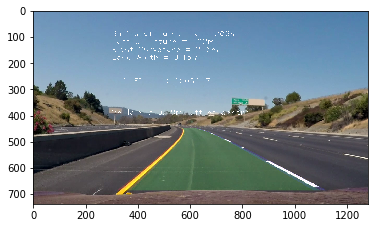

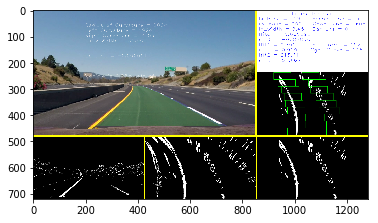

Number of lines detected =  1


In [24]:
reset_lanes = True
images = glob.glob('test_images/t*')
for idx, fname in enumerate(images):
    image = cv2.imread(fname)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    marked_img = lane_marker_pipeline(image)
    showImg(marked_img)
    combined_imgs = img_collage(marked_img)
    showImg(combined_imgs)
    combined_imgs = cv2.cvtColor(combined_imgs, cv2.COLOR_RGB2BGR)
    cv2.imwrite('text_test.jpg',combined_imgs)
    
print("Number of lines detected = ", len(detected_lines))
    

## Explore input image characteristics

Read a sample image to find out its shape and type

## Caliberate Camera

This section caliberates the camera by using chessboard images so that images can be distorted

Chess board shape =  (1280, 720)
Camera caliberated.  mtx =  [[  1.15396093e+03   0.00000000e+00   6.69705359e+02]
 [  0.00000000e+00   1.14802495e+03   3.85656232e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]  dist =  [[ -2.41017968e-01  -5.30720497e-02  -1.15810318e-03  -1.28318543e-04
    2.67124302e-02]]


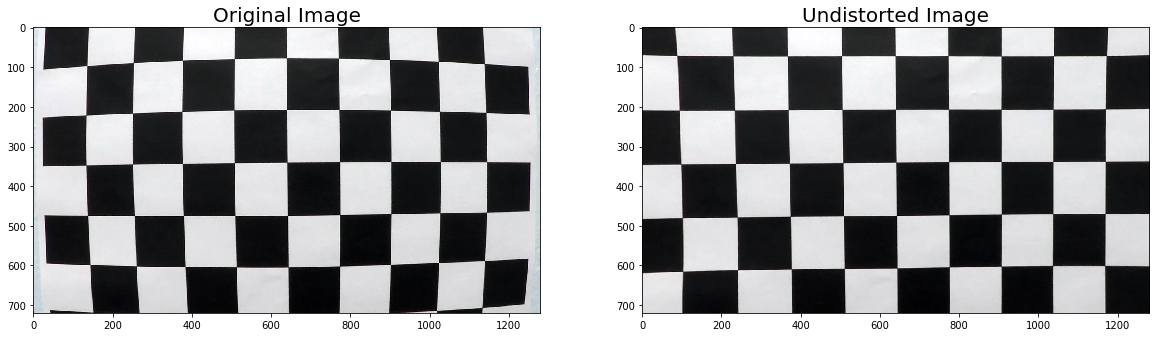

In [9]:
### Caliberate Camera

"""This section caliberates the camera by using chessboard images so that images can be distorted"""

# Chessboard corners
nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)


# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/cal*.jpg')

cv2.startWindowThread() 
# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = grayscale(img)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        write_name = 'camera_cal/corners_found'+str(idx)+'.jpg'
        cv2.imwrite(write_name, img)
#        cv2.imshow('img', img)
#        cv2.waitKey(500)

#cv2.destroyAllWindows()


# Get chessboard image size
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])
print("Chess board shape = ", img_size)

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
print("Camera caliberated.  mtx = ", mtx, " dist = ", dist)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/test_undist.jpg',dst)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=20)
plt.show()

## Compute Perspective Transform

This section calculates the Perspective Transform (M) that can be applied to any images later

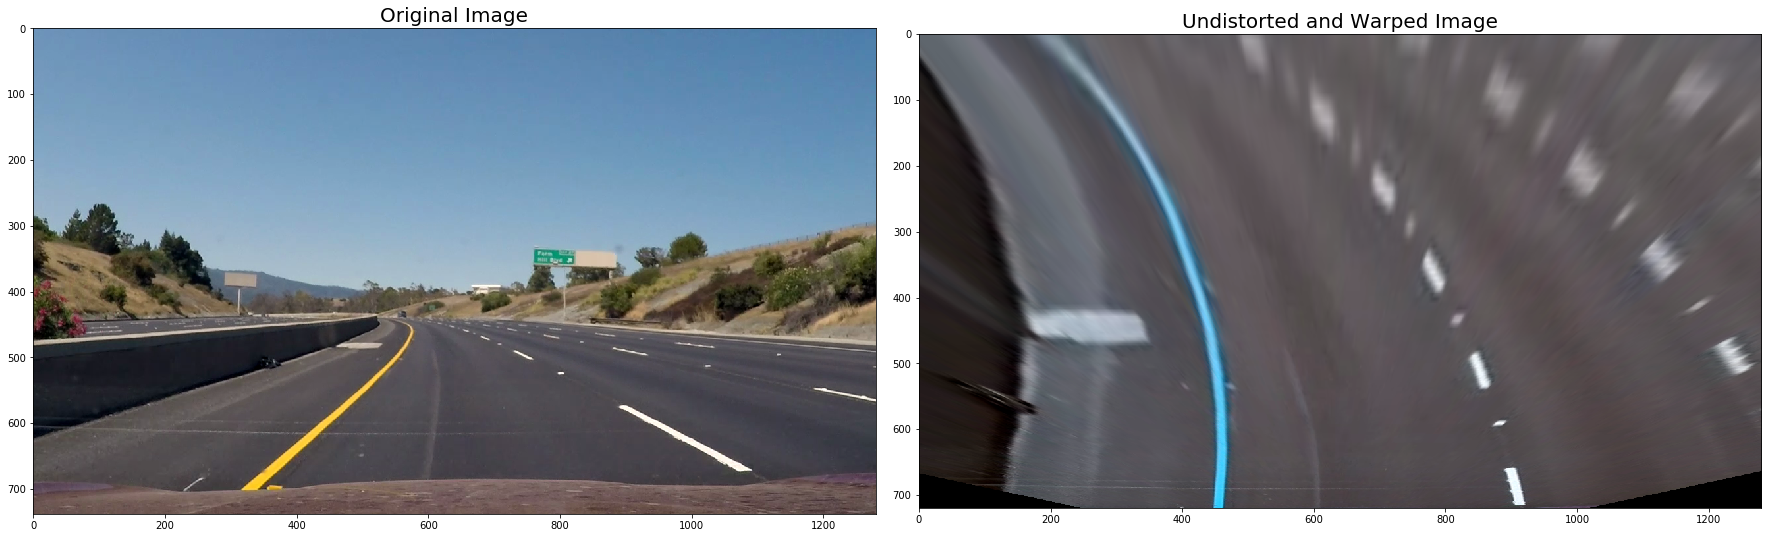

In [10]:
### Compute Perspective Transform (M) and Inverse Transform (Minv)

""" This section calculates the Perspective Transform (M) that can be applied to any images later """

# Read in an image with straight lanes
img = cv2.imread('test_images/straight_lines1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#Convert to gray scale
gray = grayscale(img)

# Undistorting using mtx and dist from camera caliberation
dst = undistort(img)
   
#Set source and destination image co-ordinates
xoffset = 400 # offset for dst points
yoffset = 10 # offset for dst points

#Define 4 source points src = np.float32([[,],[,],[,],[,]]) from the straight lane image
#src = np.float32([[611,441],[669,441],[998,650],[305,650]])
src = np.float32([[599,448],[682,448],[1010,658],[295,658]])
#src = np.float32([[556,478],[731,478],[998,650],[305,650]])
#src = np.float32([[588,455],[694,455],[1011,660],[295,660]])
#src = np.float32([[588,455],[694,455],[998,650],[305,650]]) # Good co-ordinates


# Define 4 destination points dst = np.float32([[,],[,],[,],[,]]) through trial and error
dst = np.float32([[xoffset, yoffset], [img_size[0]-xoffset, yoffset], 
                                     [img_size[0]-xoffset, img_size[1]-yoffset], 
                                     [xoffset, img_size[1]-yoffset]])
    
# Calculate Perspective Transform
perspective_M = cv2.getPerspectiveTransform(src, dst)
    
# Calculate Perspective Inverse Transform
perspective_Minv = cv2.getPerspectiveTransform(dst, src)
    
# Warp the image using the perspective transform M
warped = cv2.warpPerspective(img, perspective_M, gray.shape[::-1], flags=cv2.INTER_LINEAR)

warped_images = []
images = glob.glob('test_images/t*')
for idx, fname in enumerate(images):
    image = cv2.imread(fname)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    warped_image = cv2.warpPerspective(image, perspective_M, gray.shape[::-1], flags=cv2.INTER_LINEAR)
    warped_image = cv2.cvtColor(warped_image, cv2.COLOR_RGB2BGR)
    cv2.imwrite('img_calib.jpg', warped_image)
    
    # Plot the images for review
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(warped_image)
    ax2.set_title('Undistorted and Warped Image', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Compute Lane Width

Compute the lane width from a straight lane image in pixels which can be used as a reference to sanity check future images.


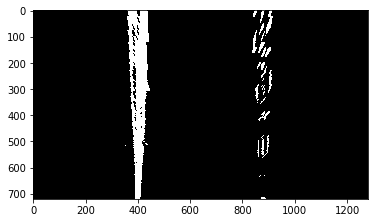

(1280,)
Baseline mid, left, center =  640 398 880
Baeline Lane width in pixels =  482


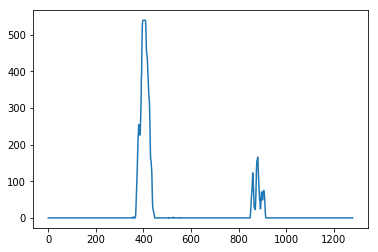

In [11]:
### Determine the lane width using a clean image (straight line image).
### This image will be used for sanity checks on new images

# Read in a baseline image (straight lanes image)
img = cv2.imread('test_images/straight_lines1.jpg')
#img = cv2.imread('test_images/test2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

binary_warped = get_binary_warp(img)
showGrayImg(binary_warped)

# Take a histogram of the bottom quarter of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//4:,:], axis=0)
print(histogram.shape)
plt.plot(histogram)

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
baseline_midpoint = np.int(histogram.shape[0]/2)
baseline_leftx_base = np.argmax(histogram[:baseline_midpoint])
baseline_rightx_base = np.argmax(histogram[baseline_midpoint:]) + baseline_midpoint
baseline_lane_width = baseline_rightx_base - baseline_leftx_base
print("Baseline mid, left, center = ", baseline_midpoint, baseline_leftx_base, baseline_rightx_base)
print("Baeline Lane width in pixels = ", baseline_lane_width)

## Validate pipeline on test images

Use test images to validate teh pipeline.


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!



In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [13]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # Calling pipeline that will return the final output (image where lines are drawn on lanes)
        
    result = lane_marker_pipeline(image)
    result = img_collage(result)

    return result

Let's try the one with the solid white lane on the right first ...

In [81]:
prev_clip_data = [0, 0, 0, 0]
bottom_y = 0
project_video_output = 'project_video_output.mp4'
#clip1 = VideoFileClip("P2.mp4")
clip1 = VideoFileClip("project_video.mp4")
project_video_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_video_clip.write_videofile(project_video_output, audio=False)
print("Number of frames = ", len(detected_lines))

Inside reset
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4



  1%|█                                                                                                                                                                                                     | 7/1261 [00:02<08:32,  2.45it/s]

@ 8  > curve check failure :  352.566540819 64124.3932997



  1%|█▌                                                                                                                                                                                                   | 10/1261 [00:03<08:11,  2.55it/s]

@ 11  > Continuity check failed - right curve variation high :  1074.21635529 2775.46131112



  1%|█▋                                                                                                                                                                                                   | 11/1261 [00:04<08:24,  2.48it/s]

@ 12  > Continuity check failed - right curve variation high :  1188.26795326 2775.46131112



  1%|█▊                                                                                                                                                                                                   | 12/1261 [00:04<08:30,  2.44it/s]

@ 13  > Continuity check failed - right curve variation high :  386.878461999 2775.46131112



  1%|██                                                                                                                                                                                                   | 13/1261 [00:05<08:38,  2.41it/s]

@ 14  > Continuity check failed - right curve variation high :  334.989838593 2775.46131112



  1%|██▏                                                                                                                                                                                                  | 14/1261 [00:05<08:48,  2.36it/s]

Inside reset



  2%|███▋                                                                                                                                                                                                 | 24/1261 [00:09<07:40,  2.69it/s]

@ 25  > Continuity check failed - right curve variation high :  715.957954762 2318.65872899



  2%|███▉                                                                                                                                                                                                 | 25/1261 [00:09<07:41,  2.68it/s]

@ 26  > Continuity check failed - right curve variation high :  694.11911979 2318.65872899



  2%|████                                                                                                                                                                                                 | 26/1261 [00:10<07:49,  2.63it/s]

@ 27  > Continuity check failed - right curve variation high :  595.161581663 2318.65872899



  2%|████▏                                                                                                                                                                                                | 27/1261 [00:10<07:49,  2.63it/s]

@ 28  > Continuity check failed - right curve variation high :  558.450614434 2318.65872899



  2%|████▎                                                                                                                                                                                                | 28/1261 [00:11<07:46,  2.64it/s]

Inside reset



  5%|█████████                                                                                                                                                                                            | 58/1261 [00:21<07:22,  2.72it/s]

@ 59  > Continuity check failed - right curve variation high :  274.812493394 3288.19229619



  5%|█████████▏                                                                                                                                                                                           | 59/1261 [00:22<07:36,  2.63it/s]

@ 60  > Continuity check failed - right curve variation high :  217.318583521 3288.19229619



  5%|█████████▎                                                                                                                                                                                           | 60/1261 [00:22<07:51,  2.55it/s]

@ 61  > Continuity check failed - right curve variation high :  261.290046185 3288.19229619



  5%|█████████▌                                                                                                                                                                                           | 61/1261 [00:23<07:46,  2.57it/s]

@ 62  > Continuity check failed - right curve variation high :  395.875328156 3288.19229619



  5%|█████████▋                                                                                                                                                                                           | 62/1261 [00:23<07:41,  2.60it/s]

Inside reset



  7%|█████████████                                                                                                                                                                                        | 84/1261 [00:32<08:03,  2.43it/s]

@ 85  > left and right curves similarity failure :  419.165109364 10910.6314361



  7%|█████████████▍                                                                                                                                                                                       | 86/1261 [00:32<07:41,  2.54it/s]

@ 87  > Continuity check failed - right curve variation high :  348.080885076 2589.9533863



  7%|█████████████▌                                                                                                                                                                                       | 87/1261 [00:33<07:40,  2.55it/s]

@ 88  > Continuity check failed - right curve variation high :  246.826277875 2589.9533863



  7%|█████████████▋                                                                                                                                                                                       | 88/1261 [00:33<07:36,  2.57it/s]

@ 89  > Continuity check failed - right curve variation high :  282.656633879 2589.9533863



  7%|█████████████▉                                                                                                                                                                                       | 89/1261 [00:33<07:40,  2.54it/s]

@ 90  > Continuity check failed - right curve variation high :  439.710555399 2589.9533863



  7%|██████████████                                                                                                                                                                                       | 90/1261 [00:34<07:36,  2.57it/s]

Inside reset



 12%|████████████████████████▍                                                                                                                                                                           | 157/1261 [00:58<06:31,  2.82it/s]

@ 158  > Continuity check failed - right curve variation high :  287.064244832 614.808838672



 13%|████████████████████████▌                                                                                                                                                                           | 158/1261 [00:59<06:34,  2.80it/s]

@ 159  > Continuity check failed - right curve variation high :  225.474793786 614.808838672



 13%|████████████████████████▋                                                                                                                                                                           | 159/1261 [00:59<06:39,  2.76it/s]

@ 160  > Continuity check failed - right curve variation high :  176.794436536 614.808838672



 13%|████████████████████████▊                                                                                                                                                                           | 160/1261 [00:59<06:39,  2.75it/s]

@ 161  > Continuity check failed - right curve variation high :  168.451906731 614.808838672



 13%|█████████████████████████                                                                                                                                                                           | 161/1261 [01:00<06:42,  2.73it/s]

Inside reset



 14%|██████████████████████████▌                                                                                                                                                                         | 171/1261 [01:03<06:24,  2.83it/s]

@ 172  > Continuity check failed - right curve variation high :  165.154486385 373.218594948



 14%|██████████████████████████▋                                                                                                                                                                         | 172/1261 [01:04<06:29,  2.80it/s]

@ 173  > Continuity check failed - right curve variation high :  141.485887339 373.218594948



 14%|██████████████████████████▉                                                                                                                                                                         | 173/1261 [01:04<06:33,  2.77it/s]

@ 174  > Continuity check failed - right curve variation high :  176.326424224 373.218594948



 16%|███████████████████████████████▏                                                                                                                                                                    | 201/1261 [01:14<06:13,  2.84it/s]

@ 202  > Continuity check failed - right curve variation high :  243.478319945 799.479100717



 16%|███████████████████████████████▍                                                                                                                                                                    | 202/1261 [01:14<06:18,  2.80it/s]

@ 203  > Continuity check failed - right curve variation high :  235.355090323 799.479100717



 16%|███████████████████████████████▌                                                                                                                                                                    | 203/1261 [01:15<06:21,  2.77it/s]

@ 204  > Continuity check failed - right curve variation high :  226.615085321 799.479100717



 16%|███████████████████████████████▋                                                                                                                                                                    | 204/1261 [01:15<06:24,  2.75it/s]

@ 205  > Continuity check failed - right curve variation high :  332.039410527 799.479100717



 16%|███████████████████████████████▊                                                                                                                                                                    | 205/1261 [01:15<06:29,  2.71it/s]

Inside reset



 16%|████████████████████████████████▏                                                                                                                                                                   | 207/1261 [01:16<06:27,  2.72it/s]

@ 208  > Continuity check failed - right curve variation high :  201.120950148 448.595801549



 16%|████████████████████████████████▎                                                                                                                                                                   | 208/1261 [01:16<06:28,  2.71it/s]

@ 209  > Continuity check failed - right curve variation high :  224.146656395 448.595801549



 17%|████████████████████████████████▊                                                                                                                                                                   | 211/1261 [01:18<06:20,  2.76it/s]

@ 212  > Continuity check failed - right curve variation high :  256.933976928 926.513789221



 17%|████████████████████████████████▉                                                                                                                                                                   | 212/1261 [01:18<06:21,  2.75it/s]

@ 213  > Continuity check failed - right curve variation high :  286.707558111 926.513789221



 17%|█████████████████████████████████                                                                                                                                                                   | 213/1261 [01:18<06:23,  2.73it/s]

@ 214  > Continuity check failed - right curve variation high :  240.012321623 926.513789221



 17%|█████████████████████████████████▎                                                                                                                                                                  | 214/1261 [01:19<06:25,  2.71it/s]

@ 215  > Continuity check failed - right curve variation high :  276.7414694 926.513789221



 17%|█████████████████████████████████▍                                                                                                                                                                  | 215/1261 [01:19<06:26,  2.71it/s]

Inside reset



 18%|██████████████████████████████████▎                                                                                                                                                                 | 221/1261 [01:21<06:11,  2.80it/s]

@ 222  > Continuity check failed - right curve variation high :  409.417115877 1058.89891098



 18%|██████████████████████████████████▌                                                                                                                                                                 | 222/1261 [01:22<06:13,  2.78it/s]

@ 223  > Continuity check failed - right curve variation high :  435.238472218 1058.89891098



 18%|██████████████████████████████████▋                                                                                                                                                                 | 223/1261 [01:22<06:16,  2.75it/s]

@ 224  > Continuity check failed - right curve variation high :  177.673306704 1058.89891098



 18%|██████████████████████████████████▊                                                                                                                                                                 | 224/1261 [01:22<06:20,  2.73it/s]

@ 225  > Continuity check failed - right curve variation high :  183.480540269 1058.89891098



 18%|██████████████████████████████████▉                                                                                                                                                                 | 225/1261 [01:23<06:21,  2.71it/s]

Inside reset



 18%|████████████████████████████████████▏                                                                                                                                                               | 233/1261 [01:26<06:05,  2.81it/s]

@ 234  > Continuity check failed - right curve variation high :  202.78105849 465.444470196



 19%|████████████████████████████████████▎                                                                                                                                                               | 234/1261 [01:26<06:08,  2.79it/s]

@ 235  > Continuity check failed - right curve variation high :  181.159904539 465.444470196



 19%|████████████████████████████████████▌                                                                                                                                                               | 235/1261 [01:26<06:11,  2.76it/s]

@ 236  > Continuity check failed - right curve variation high :  201.97004924 465.444470196



 19%|████████████████████████████████████▋                                                                                                                                                               | 236/1261 [01:27<06:15,  2.73it/s]

@ 237  > Continuity check failed - right curve variation high :  218.729104783 465.444470196



 19%|████████████████████████████████████▊                                                                                                                                                               | 237/1261 [01:27<06:15,  2.73it/s]

Inside reset



 21%|█████████████████████████████████████████▊                                                                                                                                                          | 269/1261 [01:38<05:51,  2.82it/s]

@ 270  > Continuity check failed - right curve variation high :  324.22292726 754.666321479



 21%|█████████████████████████████████████████▉                                                                                                                                                          | 270/1261 [01:39<05:56,  2.78it/s]

@ 271  > Continuity check failed - right curve variation high :  265.183423647 754.666321479



 21%|██████████████████████████████████████████                                                                                                                                                          | 271/1261 [01:39<06:00,  2.74it/s]

@ 272  > Continuity check failed - right curve variation high :  325.245532568 754.666321479



 22%|██████████████████████████████████████████▎                                                                                                                                                         | 272/1261 [01:39<06:04,  2.72it/s]

@ 273  > Continuity check failed - right curve variation high :  364.723357846 754.666321479



 22%|██████████████████████████████████████████▍                                                                                                                                                         | 273/1261 [01:40<06:05,  2.70it/s]

Inside reset



 22%|███████████████████████████████████████████▌                                                                                                                                                        | 280/1261 [01:42<05:49,  2.80it/s]

@ 281  > 1st order coefficient similarity failure :  0.323614996457 0.581387882447



 22%|███████████████████████████████████████████▋                                                                                                                                                        | 281/1261 [01:43<05:52,  2.78it/s]

@ 282  > 1st order coefficient similarity failure :  0.319615416749 0.610769186602



 22%|███████████████████████████████████████████▊                                                                                                                                                        | 282/1261 [01:43<05:56,  2.75it/s]

@ 283  > 1st order coefficient similarity failure :  0.316617998811 0.579306221736



 22%|███████████████████████████████████████████▉                                                                                                                                                        | 283/1261 [01:43<05:57,  2.73it/s]

@ 284  > 1st order coefficient similarity failure :  0.300072224269 0.537331792518



 23%|████████████████████████████████████████████▏                                                                                                                                                       | 284/1261 [01:44<05:59,  2.72it/s]

Inside reset



 23%|████████████████████████████████████████████▎                                                                                                                                                       | 285/1261 [01:44<06:02,  2.69it/s]

@ 286  > 1st order coefficient similarity failure :  0.282243459864 0.520756953824



 23%|█████████████████████████████████████████████▏                                                                                                                                                      | 291/1261 [01:46<05:46,  2.80it/s]

@ 292  > 1st order coefficient similarity failure :  0.230413530083 0.417235446936



 23%|█████████████████████████████████████████████▍                                                                                                                                                      | 292/1261 [01:47<05:49,  2.77it/s]

@ 293  > 1st order coefficient similarity failure :  0.222057167944 0.416549737134



 23%|█████████████████████████████████████████████▌                                                                                                                                                      | 293/1261 [01:47<05:53,  2.74it/s]

@ 294  > 1st order coefficient similarity failure :  0.227506527179 0.464072654291



 23%|█████████████████████████████████████████████▋                                                                                                                                                      | 294/1261 [01:47<05:57,  2.70it/s]

@ 295  > 1st order coefficient similarity failure :  0.222812752189 0.427376392091



 23%|█████████████████████████████████████████████▊                                                                                                                                                      | 295/1261 [01:48<05:57,  2.71it/s]

Inside reset
@ 296  > 1st order coefficient similarity failure :  0.199038313722 0.371676254173



 23%|██████████████████████████████████████████████                                                                                                                                                      | 296/1261 [01:48<06:03,  2.66it/s]

Inside reset



 24%|███████████████████████████████████████████████▎                                                                                                                                                    | 304/1261 [01:51<05:41,  2.80it/s]

@ 305  > Continuity check failed - right curve variation high :  1403.06735841 5606.18302791



 24%|███████████████████████████████████████████████▍                                                                                                                                                    | 305/1261 [01:51<05:44,  2.77it/s]

@ 306  > 1st order coefficient similarity failure :  0.134381716596 0.331106931175



 24%|███████████████████████████████████████████████▌                                                                                                                                                    | 306/1261 [01:52<05:49,  2.73it/s]

@ 307  > 1st order coefficient similarity failure :  0.13649830245 0.273795820132



 24%|███████████████████████████████████████████████▋                                                                                                                                                    | 307/1261 [01:52<05:50,  2.72it/s]

@ 308  > 1st order coefficient similarity failure :  0.105664476968 0.30643995615



 24%|███████████████████████████████████████████████▊                                                                                                                                                    | 308/1261 [01:53<05:50,  2.72it/s]

Inside reset
@ 309  > 1st order coefficient similarity failure :  0.0924789550352 0.276343099796



 25%|████████████████████████████████████████████████                                                                                                                                                    | 309/1261 [01:53<06:00,  2.64it/s]

Inside reset
@ 310  > 1st order coefficient similarity failure :  0.0919048408076 0.173688190616



 25%|████████████████████████████████████████████████▏                                                                                                                                                   | 310/1261 [01:53<06:05,  2.60it/s]

Inside reset
@ 311  > 1st order coefficient similarity failure :  0.0636858495755 0.241416933156



 25%|████████████████████████████████████████████████▎                                                                                                                                                   | 311/1261 [01:54<06:09,  2.57it/s]

Inside reset
@ 312  > 1st order coefficient similarity failure :  0.0579483415911 0.266868055467



 25%|████████████████████████████████████████████████▍                                                                                                                                                   | 312/1261 [01:54<06:10,  2.56it/s]

Inside reset
@ 313  > 1st order coefficient similarity failure :  0.0161076594876 0.307336254104



 25%|████████████████████████████████████████████████▋                                                                                                                                                   | 313/1261 [01:55<06:11,  2.55it/s]

Inside reset
@ 314  > 1st order coefficient similarity failure :  0.0137160699472 0.285278392444



 25%|████████████████████████████████████████████████▊                                                                                                                                                   | 314/1261 [01:55<06:13,  2.53it/s]

Inside reset
@ 315  > 1st order coefficient similarity failure :  0.0135999914632 0.274239690392



 25%|████████████████████████████████████████████████▉                                                                                                                                                   | 315/1261 [01:55<06:13,  2.53it/s]

Inside reset
@ 316  > 1st order coefficient similarity failure :  0.00965372441846 0.298643801258



 25%|█████████████████████████████████████████████████                                                                                                                                                   | 316/1261 [01:56<06:12,  2.53it/s]

Inside reset
@ 317  > left and right curves similarity failure :  10543.2947844 434.026317436



 25%|█████████████████████████████████████████████████▎                                                                                                                                                  | 317/1261 [01:56<06:12,  2.53it/s]

Inside reset
@ 318  > 1st order coefficient similarity failure :  -0.0102747697286 0.192500795679



 25%|█████████████████████████████████████████████████▍                                                                                                                                                  | 318/1261 [01:57<06:12,  2.53it/s]

Inside reset
@ 319  > 1st order coefficient similarity failure :  -0.0131110932291 0.195239691993



 25%|█████████████████████████████████████████████████▌                                                                                                                                                  | 319/1261 [01:57<06:13,  2.52it/s]

Inside reset
@ 320  > 1st order coefficient similarity failure :  -0.01881255831 0.171309927691



 25%|█████████████████████████████████████████████████▋                                                                                                                                                  | 320/1261 [01:57<06:15,  2.51it/s]

Inside reset
@ 321  > 1st order coefficient similarity failure :  -0.0268576209049 0.172053018693



 25%|█████████████████████████████████████████████████▉                                                                                                                                                  | 321/1261 [01:58<06:15,  2.51it/s]

Inside reset
@ 322  > 1st order coefficient similarity failure :  -0.0246860581244 0.203678803794



 26%|██████████████████████████████████████████████████                                                                                                                                                  | 322/1261 [01:58<06:15,  2.50it/s]

Inside reset
@ 323  > 1st order coefficient similarity failure :  -0.0212446444169 0.178425987226



 26%|██████████████████████████████████████████████████▏                                                                                                                                                 | 323/1261 [01:59<06:16,  2.49it/s]

Inside reset
@ 324  > 1st order coefficient similarity failure :  -0.00863045230843 0.109451065647



 26%|██████████████████████████████████████████████████▎                                                                                                                                                 | 324/1261 [01:59<06:15,  2.50it/s]

Inside reset
@ 325  > 1st order coefficient similarity failure :  -0.0263105847636 0.177053318672



 26%|██████████████████████████████████████████████████▌                                                                                                                                                 | 325/1261 [01:59<06:15,  2.49it/s]

Inside reset
@ 326  > 1st order coefficient similarity failure :  -0.0237741352787 0.207032646886



 26%|██████████████████████████████████████████████████▋                                                                                                                                                 | 326/1261 [02:00<06:13,  2.50it/s]

Inside reset
@ 327  > 1st order coefficient similarity failure :  -0.032773079038 0.197951007641



 26%|██████████████████████████████████████████████████▊                                                                                                                                                 | 327/1261 [02:00<06:09,  2.53it/s]

Inside reset
@ 328  > 1st order coefficient similarity failure :  -0.0280482715439 0.16760292097



 26%|██████████████████████████████████████████████████▉                                                                                                                                                 | 328/1261 [02:01<06:10,  2.52it/s]

Inside reset
@ 329  > 1st order coefficient similarity failure :  -0.0253147869208 0.0699166699988



 26%|███████████████████████████████████████████████████▏                                                                                                                                                | 329/1261 [02:01<06:10,  2.52it/s]

Inside reset
@ 330  > 1st order coefficient similarity failure :  -0.026482478869 0.208783090171



 26%|███████████████████████████████████████████████████▎                                                                                                                                                | 330/1261 [02:01<06:08,  2.52it/s]

Inside reset
@ 331  > 1st order coefficient similarity failure :  -0.0351970794045 0.183635951381



 26%|███████████████████████████████████████████████████▍                                                                                                                                                | 331/1261 [02:02<06:07,  2.53it/s]

Inside reset
@ 332  > 1st order coefficient similarity failure :  -0.0371051245024 0.0876209817227



 26%|███████████████████████████████████████████████████▌                                                                                                                                                | 332/1261 [02:02<06:08,  2.52it/s]

Inside reset
@ 333  > left and right curves similarity failure :  18863.8654772 1480.12914966



 26%|███████████████████████████████████████████████████▊                                                                                                                                                | 333/1261 [02:03<06:12,  2.49it/s]

Inside reset
@ 334  > curve check failure :  388845.973585 1881.14641056



 26%|███████████████████████████████████████████████████▉                                                                                                                                                | 334/1261 [02:03<06:10,  2.50it/s]

Inside reset
@ 335  > curve check failure :  72700.1910511 1366.71653616



 27%|████████████████████████████████████████████████████                                                                                                                                                | 335/1261 [02:03<06:10,  2.50it/s]

Inside reset
@ 336  > curve check failure :  25455.9350326 2708.23978893



 27%|████████████████████████████████████████████████████▏                                                                                                                                               | 336/1261 [02:04<06:08,  2.51it/s]

Inside reset
@ 337  > curve check failure :  21009.8113153 9312.55852524



 27%|████████████████████████████████████████████████████▍                                                                                                                                               | 337/1261 [02:04<06:08,  2.51it/s]

Inside reset
@ 338  > curve check failure :  8928.20631964 24941.8600667



 27%|████████████████████████████████████████████████████▌                                                                                                                                               | 338/1261 [02:05<06:07,  2.51it/s]

Inside reset
@ 339  > left and right curves similarity failure :  14930.0176652 1437.18413894



 27%|████████████████████████████████████████████████████▋                                                                                                                                               | 339/1261 [02:05<06:06,  2.51it/s]

Inside reset
@ 340  > 1st order coefficient similarity failure :  0.00479747813366 0.202568556663



 27%|████████████████████████████████████████████████████▊                                                                                                                                               | 340/1261 [02:05<06:05,  2.52it/s]

Inside reset
@ 341  > 1st order coefficient similarity failure :  -0.00354390327964 0.223710788734



 27%|█████████████████████████████████████████████████████                                                                                                                                               | 341/1261 [02:06<06:04,  2.52it/s]

Inside reset
@ 342  > 1st order coefficient similarity failure :  -0.00482152824052 0.116083926871



 27%|█████████████████████████████████████████████████████▏                                                                                                                                              | 342/1261 [02:06<06:03,  2.53it/s]

Inside reset
@ 343  > 1st order coefficient similarity failure :  0.00218153049092 0.107385846492



 27%|█████████████████████████████████████████████████████▎                                                                                                                                              | 343/1261 [02:07<06:04,  2.52it/s]

Inside reset
@ 344  > 1st order coefficient similarity failure :  0.0195064929383 0.139042792965



 27%|█████████████████████████████████████████████████████▍                                                                                                                                              | 344/1261 [02:07<06:04,  2.52it/s]

Inside reset
@ 345  > 1st order coefficient similarity failure :  0.00222203295429 0.121058954581



 27%|█████████████████████████████████████████████████████▌                                                                                                                                              | 345/1261 [02:07<06:02,  2.52it/s]

Inside reset
@ 346  > 1st order coefficient similarity failure :  0.00734606546866 0.131885339339



 27%|█████████████████████████████████████████████████████▊                                                                                                                                              | 346/1261 [02:08<06:04,  2.51it/s]

Inside reset
@ 347  > curve check failure :  9143.19757741 24866.1591883



 28%|█████████████████████████████████████████████████████▉                                                                                                                                              | 347/1261 [02:08<06:03,  2.52it/s]

Inside reset
@ 348  > 1st order coefficient similarity failure :  0.00891618219572 0.0643575705638



 28%|██████████████████████████████████████████████████████                                                                                                                                              | 348/1261 [02:09<06:02,  2.52it/s]

Inside reset
@ 349  > left and right curves similarity failure :  19987.2428394 2414.34419072



 28%|██████████████████████████████████████████████████████▏                                                                                                                                             | 349/1261 [02:09<06:03,  2.51it/s]

Inside reset
@ 350  > curve check failure :  85628.3308896 13264.2374924



 28%|██████████████████████████████████████████████████████▍                                                                                                                                             | 350/1261 [02:09<06:06,  2.49it/s]

Inside reset
@ 351  > curve check failure :  27337.7074367 1398.92905063



 28%|██████████████████████████████████████████████████████▌                                                                                                                                             | 351/1261 [02:10<06:05,  2.49it/s]

Inside reset
@ 352  > 1st order coefficient similarity failure :  -0.0199242661598 0.158691231578



 28%|██████████████████████████████████████████████████████▋                                                                                                                                             | 352/1261 [02:10<06:03,  2.50it/s]

Inside reset
@ 353  > 1st order coefficient similarity failure :  -0.000497951282719 0.0923036884025



 28%|██████████████████████████████████████████████████████▊                                                                                                                                             | 353/1261 [02:11<06:01,  2.51it/s]

Inside reset
@ 354  > 1st order coefficient similarity failure :  -0.027687524817 0.160702096047



 28%|███████████████████████████████████████████████████████                                                                                                                                             | 354/1261 [02:11<06:01,  2.51it/s]

Inside reset
@ 355  > 1st order coefficient similarity failure :  -0.0380488098402 0.170866677654



 28%|███████████████████████████████████████████████████████▏                                                                                                                                            | 355/1261 [02:11<06:01,  2.51it/s]

Inside reset
@ 356  > 1st order coefficient similarity failure :  -0.0580034480409 0.173775476795



 28%|███████████████████████████████████████████████████████▎                                                                                                                                            | 356/1261 [02:12<06:01,  2.50it/s]

Inside reset
@ 357  > 1st order coefficient similarity failure :  -0.088607461692 0.11746778639



 28%|███████████████████████████████████████████████████████▍                                                                                                                                            | 357/1261 [02:12<05:58,  2.52it/s]

Inside reset
@ 358  > 1st order coefficient similarity failure :  -0.074102270808 0.109461649773



 28%|███████████████████████████████████████████████████████▋                                                                                                                                            | 358/1261 [02:13<05:58,  2.52it/s]

Inside reset
@ 359  > 1st order coefficient similarity failure :  -0.100153038599 0.0190926666877



 28%|███████████████████████████████████████████████████████▊                                                                                                                                            | 359/1261 [02:13<05:56,  2.53it/s]

Inside reset
@ 360  > 1st order coefficient similarity failure :  -0.0941255989661 0.0349347204257



 29%|███████████████████████████████████████████████████████▉                                                                                                                                            | 360/1261 [02:13<05:55,  2.53it/s]

Inside reset
@ 361  > 1st order coefficient similarity failure :  -0.108976277493 0.0527247095785



 29%|████████████████████████████████████████████████████████                                                                                                                                            | 361/1261 [02:14<05:55,  2.53it/s]

Inside reset
@ 362  > 1st order coefficient similarity failure :  -0.106175976477 0.129059930259



 29%|████████████████████████████████████████████████████████▎                                                                                                                                           | 362/1261 [02:14<05:56,  2.52it/s]

Inside reset
@ 363  > 1st order coefficient similarity failure :  -0.123197812794 0.11486502554



 29%|████████████████████████████████████████████████████████▍                                                                                                                                           | 363/1261 [02:14<05:55,  2.52it/s]

Inside reset
@ 364  > 1st order coefficient similarity failure :  -0.134787068991 0.130237231173



 29%|████████████████████████████████████████████████████████▌                                                                                                                                           | 364/1261 [02:15<05:57,  2.51it/s]

Inside reset
@ 365  > 1st order coefficient similarity failure :  -0.119300102868 0.150492221638



 29%|████████████████████████████████████████████████████████▋                                                                                                                                           | 365/1261 [02:15<05:57,  2.50it/s]

Inside reset
@ 366  > 1st order coefficient similarity failure :  -0.117903334855 0.12830828249



 29%|████████████████████████████████████████████████████████▉                                                                                                                                           | 366/1261 [02:16<05:57,  2.51it/s]

Inside reset
@ 367  > 1st order coefficient similarity failure :  -0.119293268633 0.10503369131



 29%|█████████████████████████████████████████████████████████                                                                                                                                           | 367/1261 [02:16<05:55,  2.51it/s]

Inside reset
@ 368  > 1st order coefficient similarity failure :  -0.114836669331 0.116005470157



 29%|█████████████████████████████████████████████████████████▏                                                                                                                                          | 368/1261 [02:16<05:55,  2.51it/s]

Inside reset
@ 369  > 1st order coefficient similarity failure :  -0.106539770715 0.0442846755783



 29%|█████████████████████████████████████████████████████████▎                                                                                                                                          | 369/1261 [02:17<05:54,  2.51it/s]

Inside reset
@ 370  > 1st order coefficient similarity failure :  -0.0954864453311 0.029158255301



 29%|█████████████████████████████████████████████████████████▌                                                                                                                                          | 370/1261 [02:17<05:53,  2.52it/s]

Inside reset
@ 371  > 1st order coefficient similarity failure :  -0.0892852922268 -0.0114117641373



 29%|█████████████████████████████████████████████████████████▋                                                                                                                                          | 371/1261 [02:18<05:52,  2.52it/s]

Inside reset
@ 372  > 1st order coefficient similarity failure :  -0.0825231555256 -0.0122626845327



 30%|█████████████████████████████████████████████████████████▊                                                                                                                                          | 372/1261 [02:18<05:54,  2.51it/s]

Inside reset



 30%|█████████████████████████████████████████████████████████▉                                                                                                                                          | 373/1261 [02:18<05:53,  2.51it/s]

@ 374  > curve check failure :  26743.5272017 1377.46154909



 30%|██████████████████████████████████████████████████████████▏                                                                                                                                         | 374/1261 [02:19<05:44,  2.57it/s]

@ 375  > 1st order coefficient similarity failure :  -0.0391249626348 0.024942832552



 30%|██████████████████████████████████████████████████████████▎                                                                                                                                         | 375/1261 [02:19<05:42,  2.59it/s]

@ 376  > 1st order coefficient similarity failure :  -0.0253654247564 0.125137481916



 30%|██████████████████████████████████████████████████████████▍                                                                                                                                         | 376/1261 [02:20<05:39,  2.61it/s]

@ 377  > 1st order coefficient similarity failure :  -0.0192353665794 0.138215298742



 30%|██████████████████████████████████████████████████████████▌                                                                                                                                         | 377/1261 [02:20<05:37,  2.62it/s]

Inside reset
@ 378  > 1st order coefficient similarity failure :  -0.0101394269404 0.135434831415



 30%|██████████████████████████████████████████████████████████▊                                                                                                                                         | 378/1261 [02:20<05:39,  2.60it/s]

Inside reset
@ 379  > 1st order coefficient similarity failure :  -0.0115957026655 0.0970150289453



 30%|██████████████████████████████████████████████████████████▉                                                                                                                                         | 379/1261 [02:21<05:40,  2.59it/s]

Inside reset
@ 380  > 1st order coefficient similarity failure :  0.00170038637621 0.121063353183



 30%|███████████████████████████████████████████████████████████                                                                                                                                         | 380/1261 [02:21<05:44,  2.56it/s]

Inside reset
@ 381  > 1st order coefficient similarity failure :  0.0148047114645 0.115915971833



 30%|███████████████████████████████████████████████████████████▏                                                                                                                                        | 381/1261 [02:22<05:44,  2.55it/s]

Inside reset
@ 382  > 1st order coefficient similarity failure :  0.019305121037 0.0775017143457



 30%|███████████████████████████████████████████████████████████▍                                                                                                                                        | 382/1261 [02:22<05:46,  2.54it/s]

Inside reset
@ 383  > 1st order coefficient similarity failure :  0.0217876529177 0.0565530668594



 30%|███████████████████████████████████████████████████████████▌                                                                                                                                        | 383/1261 [02:22<05:47,  2.52it/s]

Inside reset
@ 384  > 1st order coefficient similarity failure :  0.018889537221 -0.00329514975382



 30%|███████████████████████████████████████████████████████████▋                                                                                                                                        | 384/1261 [02:23<05:50,  2.50it/s]

Inside reset
@ 385  > 1st order coefficient similarity failure :  0.0251951595396 -0.0111942936715



 31%|███████████████████████████████████████████████████████████▊                                                                                                                                        | 385/1261 [02:23<05:52,  2.48it/s]

Inside reset
@ 386  > 1st order coefficient similarity failure :  0.0274382987692 -0.0107484184639



 31%|███████████████████████████████████████████████████████████▉                                                                                                                                        | 386/1261 [02:24<05:54,  2.47it/s]

Inside reset
@ 387  > left and right curves similarity failure :  1835.06097386 12064.9503925



 31%|████████████████████████████████████████████████████████████▏                                                                                                                                       | 387/1261 [02:24<05:53,  2.48it/s]

Inside reset
@ 388  > 1st order coefficient similarity failure :  0.0387305522958 -0.0673392893021



 31%|████████████████████████████████████████████████████████████▎                                                                                                                                       | 388/1261 [02:24<05:49,  2.50it/s]

Inside reset
@ 389  > 1st order coefficient similarity failure :  0.0449110260544 -0.0935622207155



 31%|████████████████████████████████████████████████████████████▍                                                                                                                                       | 389/1261 [02:25<05:47,  2.51it/s]

Inside reset
@ 390  > 1st order coefficient similarity failure :  0.0425193548548 -0.113499353939



 31%|████████████████████████████████████████████████████████████▌                                                                                                                                       | 390/1261 [02:25<05:49,  2.49it/s]

Inside reset
@ 391  > 1st order coefficient similarity failure :  0.0405443563363 -0.129152612219



 31%|████████████████████████████████████████████████████████████▊                                                                                                                                       | 391/1261 [02:26<05:48,  2.50it/s]

Inside reset
@ 392  > 1st order coefficient similarity failure :  0.0417963875438 -0.121521386981



 31%|████████████████████████████████████████████████████████████▉                                                                                                                                       | 392/1261 [02:26<05:48,  2.49it/s]

Inside reset
@ 393  > curve check failure :  30348.8759522 2248.56927104



 31%|█████████████████████████████████████████████████████████████                                                                                                                                       | 393/1261 [02:26<05:47,  2.50it/s]

Inside reset
@ 394  > curve check failure :  39491.8285421 2554.14175284



 31%|█████████████████████████████████████████████████████████████▏                                                                                                                                      | 394/1261 [02:27<05:44,  2.51it/s]

Inside reset
@ 395  > 1st order coefficient similarity failure :  0.012739899975 0.0341480326566



 31%|█████████████████████████████████████████████████████████████▍                                                                                                                                      | 395/1261 [02:27<05:45,  2.51it/s]

Inside reset
@ 396  > curve check failure :  50775.8832589 2127.51071229



 31%|█████████████████████████████████████████████████████████████▌                                                                                                                                      | 396/1261 [02:28<05:44,  2.51it/s]

Inside reset
@ 397  > 1st order coefficient similarity failure :  0.0181768745865 0.0562925228159



 31%|█████████████████████████████████████████████████████████████▋                                                                                                                                      | 397/1261 [02:28<05:45,  2.50it/s]

Inside reset
@ 398  > 1st order coefficient similarity failure :  0.0218877519493 0.0957394970027



 32%|█████████████████████████████████████████████████████████████▊                                                                                                                                      | 398/1261 [02:28<05:45,  2.50it/s]

Inside reset
@ 399  > curve check failure :  78405.4734266 1408.89901058



 32%|██████████████████████████████████████████████████████████████                                                                                                                                      | 399/1261 [02:29<05:45,  2.50it/s]

Inside reset



 32%|██████████████████████████████████████████████████████████████▏                                                                                                                                     | 400/1261 [02:29<05:40,  2.53it/s]

@ 401  > curve check failure :  27750.7265951 943.500430378



 32%|██████████████████████████████████████████████████████████████▎                                                                                                                                     | 401/1261 [02:30<05:35,  2.56it/s]

@ 402  > 1st order coefficient similarity failure :  0.0216908836118 -0.0123104431346



 32%|██████████████████████████████████████████████████████████████▍                                                                                                                                     | 402/1261 [02:30<05:31,  2.59it/s]

@ 403  > left and right curves similarity failure :  16564.017287 725.895722346



 32%|██████████████████████████████████████████████████████████████▋                                                                                                                                     | 403/1261 [02:30<05:28,  2.61it/s]

@ 404  > left and right curves similarity failure :  15072.2995465 607.765547119



 32%|██████████████████████████████████████████████████████████████▊                                                                                                                                     | 404/1261 [02:31<05:26,  2.62it/s]

Inside reset
@ 405  > curve check failure :  53155.2295954 682.528129869



 32%|██████████████████████████████████████████████████████████████▉                                                                                                                                     | 405/1261 [02:31<05:30,  2.59it/s]

Inside reset
@ 406  > curve check failure :  26179.5788028 515.537031671



 32%|███████████████████████████████████████████████████████████████                                                                                                                                     | 406/1261 [02:31<05:32,  2.57it/s]

Inside reset
@ 407  > curve check failure :  37658.150142 749.325023552



 32%|███████████████████████████████████████████████████████████████▎                                                                                                                                    | 407/1261 [02:32<05:38,  2.52it/s]

Inside reset
@ 408  > curve check failure :  19382.1410471 27952.5477872



 32%|███████████████████████████████████████████████████████████████▍                                                                                                                                    | 408/1261 [02:32<05:38,  2.52it/s]

Inside reset
@ 409  > left and right curves similarity failure :  19469.2950029 1371.03426176



 32%|███████████████████████████████████████████████████████████████▌                                                                                                                                    | 409/1261 [02:33<05:36,  2.53it/s]

Inside reset
@ 410  > 1st order coefficient similarity failure :  0.0487223488155 0.0896023670566



 33%|███████████████████████████████████████████████████████████████▋                                                                                                                                    | 410/1261 [02:33<05:42,  2.49it/s]

Inside reset
@ 411  > 1st order coefficient similarity failure :  0.0473680808501 0.0886912010487



 33%|███████████████████████████████████████████████████████████████▉                                                                                                                                    | 411/1261 [02:33<05:41,  2.49it/s]

Inside reset



 33%|████████████████████████████████████████████████████████████████                                                                                                                                    | 412/1261 [02:34<05:41,  2.48it/s]

@ 413  > 1st order coefficient similarity failure :  0.0568667938977 -0.0182593727196



 33%|████████████████████████████████████████████████████████████████▏                                                                                                                                   | 413/1261 [02:34<05:37,  2.52it/s]

@ 414  > 1st order coefficient similarity failure :  0.0598315822719 -0.045398027533



 33%|████████████████████████████████████████████████████████████████▎                                                                                                                                   | 414/1261 [02:35<05:32,  2.55it/s]

@ 415  > 1st order coefficient similarity failure :  0.0487048858585 -0.100581893323



 33%|████████████████████████████████████████████████████████████████▌                                                                                                                                   | 415/1261 [02:35<05:29,  2.57it/s]

@ 416  > 1st order coefficient similarity failure :  0.0726575939627 -0.0802597773507



 33%|████████████████████████████████████████████████████████████████▋                                                                                                                                   | 416/1261 [02:35<05:27,  2.58it/s]

Inside reset
@ 417  > 1st order coefficient similarity failure :  0.0649687442544 -0.0658397534455



 33%|████████████████████████████████████████████████████████████████▊                                                                                                                                   | 417/1261 [02:36<05:31,  2.55it/s]

Inside reset
@ 418  > 1st order coefficient similarity failure :  0.0607942179173 -0.0221335019419



 33%|████████████████████████████████████████████████████████████████▉                                                                                                                                   | 418/1261 [02:36<05:37,  2.50it/s]

Inside reset



 33%|█████████████████████████████████████████████████████████████████▎                                                                                                                                  | 420/1261 [02:37<05:24,  2.59it/s]

@ 421  > 1st order coefficient similarity failure :  0.0505912597647 0.101213349921



 34%|█████████████████████████████████████████████████████████████████▉                                                                                                                                  | 424/1261 [02:38<05:09,  2.70it/s]

@ 425  > 1st order coefficient similarity failure :  0.0348911307575 -0.0400288327146



 34%|██████████████████████████████████████████████████████████████████                                                                                                                                  | 425/1261 [02:39<05:11,  2.68it/s]

@ 426  > left and right curves similarity failure :  12405.3505921 1570.91980054



 34%|██████████████████████████████████████████████████████████████████▏                                                                                                                                 | 426/1261 [02:39<05:12,  2.68it/s]

@ 427  > curve check failure :  67964.237343 1165.81977892



 34%|██████████████████████████████████████████████████████████████████▎                                                                                                                                 | 427/1261 [02:40<05:10,  2.69it/s]

@ 428  > 1st order coefficient similarity failure :  0.0234625394811 -0.0479490219752



 34%|██████████████████████████████████████████████████████████████████▌                                                                                                                                 | 428/1261 [02:40<05:13,  2.66it/s]

Inside reset
@ 429  > 1st order coefficient similarity failure :  0.0122609029135 0.0351783363883



 34%|██████████████████████████████████████████████████████████████████▋                                                                                                                                 | 429/1261 [02:40<05:19,  2.60it/s]

Inside reset
@ 430  > 1st order coefficient similarity failure :  0.000903394599883 0.0957389553283



 34%|██████████████████████████████████████████████████████████████████▊                                                                                                                                 | 430/1261 [02:41<05:22,  2.58it/s]

Inside reset
@ 431  > 1st order coefficient similarity failure :  0.0119005616297 0.0690796165272



 34%|██████████████████████████████████████████████████████████████████▉                                                                                                                                 | 431/1261 [02:41<05:24,  2.56it/s]

Inside reset
@ 432  > 1st order coefficient similarity failure :  0.00233597405088 0.122699295324



 34%|███████████████████████████████████████████████████████████████████▏                                                                                                                                | 432/1261 [02:42<05:26,  2.54it/s]

Inside reset
@ 433  > 1st order coefficient similarity failure :  0.0155188092113 0.0924453590179



 34%|███████████████████████████████████████████████████████████████████▎                                                                                                                                | 433/1261 [02:42<05:26,  2.54it/s]

Inside reset
@ 434  > 1st order coefficient similarity failure :  -0.0080840289532 0.135514066265



 34%|███████████████████████████████████████████████████████████████████▍                                                                                                                                | 434/1261 [02:42<05:27,  2.52it/s]

Inside reset
@ 435  > 1st order coefficient similarity failure :  -0.0106124327232 0.0863514183509



 34%|███████████████████████████████████████████████████████████████████▌                                                                                                                                | 435/1261 [02:43<05:26,  2.53it/s]

Inside reset
@ 436  > 1st order coefficient similarity failure :  -0.0178207041689 0.0359734325391



 35%|███████████████████████████████████████████████████████████████████▊                                                                                                                                | 436/1261 [02:43<05:28,  2.51it/s]

Inside reset



 35%|███████████████████████████████████████████████████████████████████▉                                                                                                                                | 437/1261 [02:44<05:24,  2.54it/s]

@ 438  > 1st order coefficient similarity failure :  -0.0314537786126 -0.06515233723



 35%|████████████████████████████████████████████████████████████████████                                                                                                                                | 438/1261 [02:44<05:18,  2.59it/s]

@ 439  > 1st order coefficient similarity failure :  -0.0571682390242 0.113394712687



 35%|████████████████████████████████████████████████████████████████████▏                                                                                                                               | 439/1261 [02:44<05:15,  2.61it/s]

@ 440  > 1st order coefficient similarity failure :  -0.0768263711519 0.18169045838



 35%|████████████████████████████████████████████████████████████████████▍                                                                                                                               | 440/1261 [02:45<05:12,  2.63it/s]

@ 441  > 1st order coefficient similarity failure :  -0.0694725121711 0.174591762008



 35%|████████████████████████████████████████████████████████████████████▌                                                                                                                               | 441/1261 [02:45<05:10,  2.64it/s]

Inside reset
@ 442  > 1st order coefficient similarity failure :  -0.0622801759045 0.143341527997



 35%|████████████████████████████████████████████████████████████████████▋                                                                                                                               | 442/1261 [02:45<05:16,  2.58it/s]

Inside reset
@ 443  > 1st order coefficient similarity failure :  -0.0401505806018 0.129103796984



 35%|████████████████████████████████████████████████████████████████████▊                                                                                                                               | 443/1261 [02:46<05:18,  2.57it/s]

Inside reset
@ 444  > 1st order coefficient similarity failure :  -0.0384128362306 0.121569617652



 35%|█████████████████████████████████████████████████████████████████████                                                                                                                               | 444/1261 [02:46<05:22,  2.54it/s]

Inside reset
@ 445  > 1st order coefficient similarity failure :  -0.0406992893699 0.132295091449



 35%|█████████████████████████████████████████████████████████████████████▏                                                                                                                              | 445/1261 [02:47<05:22,  2.53it/s]

Inside reset
@ 446  > 1st order coefficient similarity failure :  -0.0344805571667 0.0883503746787



 35%|█████████████████████████████████████████████████████████████████████▎                                                                                                                              | 446/1261 [02:47<05:22,  2.53it/s]

Inside reset
@ 447  > 1st order coefficient similarity failure :  -0.037457887184 -0.00448509098566



 35%|█████████████████████████████████████████████████████████████████████▍                                                                                                                              | 447/1261 [02:47<05:21,  2.53it/s]

Inside reset
@ 448  > curve check failure :  48415.3436845 1459.89822886



 36%|█████████████████████████████████████████████████████████████████████▋                                                                                                                              | 448/1261 [02:48<05:24,  2.50it/s]

Inside reset
@ 449  > curve check failure :  67764.1898428 8224.092277



 36%|█████████████████████████████████████████████████████████████████████▊                                                                                                                              | 449/1261 [02:48<05:25,  2.50it/s]

Inside reset
@ 450  > curve check failure :  28235.5227642 6116.8685221



 36%|█████████████████████████████████████████████████████████████████████▉                                                                                                                              | 450/1261 [02:49<05:24,  2.50it/s]

Inside reset
@ 451  > 1st order coefficient similarity failure :  -0.014812163797 0.103764260949



 36%|██████████████████████████████████████████████████████████████████████                                                                                                                              | 451/1261 [02:49<05:25,  2.49it/s]

Inside reset
@ 452  > 1st order coefficient similarity failure :  -0.00647969626112 0.0911374487647



 36%|██████████████████████████████████████████████████████████████████████▎                                                                                                                             | 452/1261 [02:49<05:24,  2.50it/s]

Inside reset
@ 453  > 1st order coefficient similarity failure :  0.000109602064723 0.0894179693525



 36%|██████████████████████████████████████████████████████████████████████▍                                                                                                                             | 453/1261 [02:50<05:24,  2.49it/s]

Inside reset
@ 454  > 1st order coefficient similarity failure :  -0.000441708856493 0.0980182368258



 36%|██████████████████████████████████████████████████████████████████████▌                                                                                                                             | 454/1261 [02:50<05:24,  2.49it/s]

Inside reset
@ 455  > 1st order coefficient similarity failure :  0.00199394243215 0.063528772598



 36%|██████████████████████████████████████████████████████████████████████▋                                                                                                                             | 455/1261 [02:51<05:22,  2.50it/s]

Inside reset
@ 456  > 1st order coefficient similarity failure :  0.000642367661813 0.0522063099108



 36%|██████████████████████████████████████████████████████████████████████▉                                                                                                                             | 456/1261 [02:51<05:24,  2.48it/s]

Inside reset
@ 457  > 1st order coefficient similarity failure :  0.00395544811881 0.00946829542415



 36%|███████████████████████████████████████████████████████████████████████                                                                                                                             | 457/1261 [02:51<05:23,  2.48it/s]

Inside reset
@ 458  > 1st order coefficient similarity failure :  0.00907709672495 -0.0261686774755



 36%|███████████████████████████████████████████████████████████████████████▏                                                                                                                            | 458/1261 [02:52<05:24,  2.48it/s]

Inside reset
@ 459  > 1st order coefficient similarity failure :  0.00518800196916 -0.0551360235019



 36%|███████████████████████████████████████████████████████████████████████▎                                                                                                                            | 459/1261 [02:52<05:24,  2.47it/s]

Inside reset
@ 460  > 1st order coefficient similarity failure :  0.0032537650039 -0.120420014187



 36%|███████████████████████████████████████████████████████████████████████▍                                                                                                                            | 460/1261 [02:53<05:22,  2.49it/s]

Inside reset
@ 461  > 1st order coefficient similarity failure :  0.00830788895393 -0.178491340034



 37%|███████████████████████████████████████████████████████████████████████▋                                                                                                                            | 461/1261 [02:53<05:23,  2.47it/s]

Inside reset
@ 462  > 1st order coefficient similarity failure :  0.0143731755878 -0.154023908632



 37%|███████████████████████████████████████████████████████████████████████▊                                                                                                                            | 462/1261 [02:53<05:22,  2.47it/s]

Inside reset
@ 463  > 1st order coefficient similarity failure :  0.0300259285393 -0.146396537637



 37%|███████████████████████████████████████████████████████████████████████▉                                                                                                                            | 463/1261 [02:54<05:20,  2.49it/s]

Inside reset
@ 464  > 1st order coefficient similarity failure :  0.0198166536494 -0.0354837561357



 37%|████████████████████████████████████████████████████████████████████████                                                                                                                            | 464/1261 [02:54<05:19,  2.49it/s]

Inside reset
@ 465  > curve check failure :  2407.5563948 22968.6489321



 37%|████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 465/1261 [02:55<05:20,  2.48it/s]

Inside reset
@ 466  > 1st order coefficient similarity failure :  -0.00262757203443 0.0357014082431



 37%|████████████████████████████████████████████████████████████████████████▍                                                                                                                           | 466/1261 [02:55<05:20,  2.48it/s]

Inside reset
@ 467  > 1st order coefficient similarity failure :  -0.00894472831471 0.0267807608866



 37%|████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 467/1261 [02:55<05:17,  2.50it/s]

Inside reset
@ 468  > 1st order coefficient similarity failure :  -0.0162012376315 0.0311664129878



 37%|████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 468/1261 [02:56<05:18,  2.49it/s]

Inside reset
@ 469  > curve check failure :  45025.8797103 10650.5615387



 37%|████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 469/1261 [02:56<05:18,  2.49it/s]

Inside reset
@ 470  > curve check failure :  31877.823563 6041.9291567



 37%|█████████████████████████████████████████████████████████████████████████                                                                                                                           | 470/1261 [02:57<05:18,  2.48it/s]

Inside reset
@ 471  > 1st order coefficient similarity failure :  -0.0261125617198 -0.0493401226365



 37%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 471/1261 [02:57<05:18,  2.48it/s]

Inside reset
@ 472  > 1st order coefficient similarity failure :  -0.0241604458371 -0.0627804087488



 37%|█████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 472/1261 [02:58<05:18,  2.48it/s]

Inside reset
@ 473  > 1st order coefficient similarity failure :  -0.0295601110814 -0.1335636305



 38%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 473/1261 [02:58<05:16,  2.49it/s]

Inside reset
@ 474  > 1st order coefficient similarity failure :  -0.0272869649996 -0.0838681939632



 38%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 474/1261 [02:58<05:15,  2.49it/s]

Inside reset
@ 475  > 1st order coefficient similarity failure :  -0.00989805664748 -0.104894352472



 38%|█████████████████████████████████████████████████████████████████████████▊                                                                                                                          | 475/1261 [02:59<05:15,  2.49it/s]

Inside reset
@ 476  > 1st order coefficient similarity failure :  -0.0166808705434 -0.101705492357



 38%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                          | 476/1261 [02:59<05:16,  2.48it/s]

Inside reset
@ 477  > 1st order coefficient similarity failure :  -0.0200259744774 -0.0902536405363



 38%|██████████████████████████████████████████████████████████████████████████▏                                                                                                                         | 477/1261 [03:00<05:16,  2.48it/s]

Inside reset
@ 478  > 1st order coefficient similarity failure :  -0.0105017460529 -0.0609620728181



 38%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                         | 478/1261 [03:00<05:16,  2.47it/s]

Inside reset
@ 479  > 1st order coefficient similarity failure :  -0.0092199928774 -0.0647065921098



 38%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 479/1261 [03:00<05:15,  2.48it/s]

Inside reset
@ 480  > 1st order coefficient similarity failure :  -0.00311680595497 -0.0834795512625



 38%|██████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 480/1261 [03:01<05:16,  2.47it/s]

Inside reset
@ 481  > 1st order coefficient similarity failure :  -0.0129901742317 0.0420989459124



 38%|██████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 481/1261 [03:01<05:14,  2.48it/s]

Inside reset
@ 482  > 1st order coefficient similarity failure :  -0.00516578751026 0.0204722837627



 38%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                         | 482/1261 [03:02<05:15,  2.47it/s]

Inside reset
@ 483  > 1st order coefficient similarity failure :  -0.0162123335552 0.052028878



 38%|███████████████████████████████████████████████████████████████████████████                                                                                                                         | 483/1261 [03:02<05:14,  2.48it/s]

Inside reset
@ 484  > 1st order coefficient similarity failure :  -0.0117357930717 0.0572570419229



 38%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                        | 484/1261 [03:02<05:14,  2.47it/s]

Inside reset
@ 485  > 1st order coefficient similarity failure :  -0.0113268822525 0.0338489354413



 38%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 485/1261 [03:03<05:16,  2.45it/s]

Inside reset
@ 486  > 1st order coefficient similarity failure :  -0.0236077953036 -0.0866951779151



 39%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                        | 486/1261 [03:03<05:15,  2.45it/s]

Inside reset
@ 487  > 1st order coefficient similarity failure :  -0.0249065515564 -0.115031903728



 39%|███████████████████████████████████████████████████████████████████████████▋                                                                                                                        | 487/1261 [03:04<05:11,  2.48it/s]

Inside reset
@ 488  > left and right curves similarity failure :  14178.0127346 2642.27579116



 39%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                        | 488/1261 [03:04<05:13,  2.46it/s]

Inside reset
@ 489  > curve check failure :  36856.5167394 730.498886201



 39%|████████████████████████████████████████████████████████████████████████████                                                                                                                        | 489/1261 [03:04<05:12,  2.47it/s]

Inside reset
@ 490  > curve check failure :  70562.5441566 713.18238236



 39%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 490/1261 [03:05<05:11,  2.47it/s]

Inside reset
@ 491  > curve check failure :  58680.6127408 753.948638907



 39%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 491/1261 [03:05<05:09,  2.48it/s]

Inside reset
@ 492  > curve check failure :  30772.0030809 711.506574624



 39%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                       | 492/1261 [03:06<05:11,  2.47it/s]

Inside reset
@ 493  > curve check failure :  47917.9199466 1073.10082889



 39%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                       | 493/1261 [03:06<05:10,  2.47it/s]

Inside reset
@ 494  > curve check failure :  194314.641931 950.207386027



 39%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 494/1261 [03:06<05:09,  2.47it/s]

Inside reset
@ 495  > curve check failure :  27699.9417194 1322.41983088



 39%|████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 495/1261 [03:07<05:09,  2.48it/s]

Inside reset
@ 496  > curve check failure :  21984.2179118 2672.57257427



 39%|█████████████████████████████████████████████████████████████████████████████                                                                                                                       | 496/1261 [03:07<05:07,  2.49it/s]

Inside reset
@ 497  > curve check failure :  23128.0391316 2532.46112902



 39%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 497/1261 [03:08<05:05,  2.50it/s]

Inside reset
@ 498  > curve check failure :  23145.0678537 1147.24393183



 39%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 498/1261 [03:08<05:06,  2.49it/s]

Inside reset
@ 499  > 1st order coefficient similarity failure :  0.0203282945887 -0.0920804705212



 40%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 499/1261 [03:08<05:06,  2.49it/s]

Inside reset
@ 500  > 1st order coefficient similarity failure :  0.0185136224172 -0.109951512707



 40%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 500/1261 [03:09<05:05,  2.49it/s]

Inside reset
@ 501  > 1st order coefficient similarity failure :  0.0276821852749 -0.116811266013



 40%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 501/1261 [03:09<05:04,  2.50it/s]

Inside reset
@ 502  > 1st order coefficient similarity failure :  0.0410484387961 -0.121784246264



 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                      | 502/1261 [03:10<05:05,  2.48it/s]

Inside reset
@ 503  > 1st order coefficient similarity failure :  0.0591787370269 -0.0734374096899



 40%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 503/1261 [03:10<05:07,  2.46it/s]

Inside reset
@ 504  > 1st order coefficient similarity failure :  0.0453045777122 -0.0899238317662



 40%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                                     | 504/1261 [03:10<05:07,  2.46it/s]

Inside reset
@ 505  > 1st order coefficient similarity failure :  0.0514323737853 -0.0141268826942



 40%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 505/1261 [03:11<05:07,  2.46it/s]

Inside reset



 40%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 506/1261 [03:11<05:04,  2.48it/s]

@ 507  > curve check failure :  26206.3990035 1200.45343577



 40%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                                     | 507/1261 [03:12<04:57,  2.53it/s]

@ 508  > 1st order coefficient similarity failure :  0.0143330716406 0.0947396242133



 40%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 508/1261 [03:12<04:54,  2.56it/s]

@ 509  > 1st order coefficient similarity failure :  0.021153028067 0.129527754635



 40%|███████████████████████████████████████████████████████████████████████████████                                                                                                                     | 509/1261 [03:12<04:50,  2.58it/s]

@ 510  > 1st order coefficient similarity failure :  0.0177995193846 0.033380786114



 40%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 510/1261 [03:13<04:48,  2.61it/s]

Inside reset
@ 511  > curve check failure :  6714.36569407 24768.769851



 41%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 511/1261 [03:13<04:51,  2.57it/s]

Inside reset
@ 512  > curve check failure :  28065.5953292 2274.6445197



 41%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 512/1261 [03:14<04:53,  2.55it/s]

Inside reset
@ 513  > curve check failure :  21029.034361 5568.70406575



 41%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                                    | 513/1261 [03:14<04:55,  2.53it/s]

Inside reset
@ 514  > 1st order coefficient similarity failure :  0.0352775898593 -0.0274487317751



 41%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 514/1261 [03:14<04:55,  2.52it/s]

Inside reset
@ 515  > 1st order coefficient similarity failure :  0.0526592344408 -0.0475074897248



 41%|████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 515/1261 [03:15<04:56,  2.52it/s]

Inside reset
@ 516  > 1st order coefficient similarity failure :  0.0641693706082 -0.0494024165509



 41%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 516/1261 [03:15<04:55,  2.52it/s]

Inside reset
@ 517  > 1st order coefficient similarity failure :  0.0476489748671 -0.0559634867221



 41%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                   | 517/1261 [03:16<04:54,  2.53it/s]

Inside reset
@ 518  > left and right curves similarity failure :  1867.38306079 12031.6984541



 41%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                                   | 518/1261 [03:16<04:54,  2.52it/s]

Inside reset
@ 519  > 1st order coefficient similarity failure :  0.0696972541279 0.00980304331167



 41%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 519/1261 [03:16<04:56,  2.51it/s]

Inside reset
@ 520  > 1st order coefficient similarity failure :  0.0869276313767 0.218281395886



 41%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 520/1261 [03:17<04:54,  2.51it/s]

Inside reset
@ 521  > 1st order coefficient similarity failure :  0.0870211873124 0.33522837527



 41%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 521/1261 [03:17<04:53,  2.52it/s]

Inside reset
@ 522  > 1st order coefficient similarity failure :  0.0988369093389 0.389390998788



 41%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 522/1261 [03:18<04:54,  2.51it/s]

Inside reset
@ 523  > curve check failure :  159681.666684 192.836879193



 41%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 523/1261 [03:18<04:54,  2.51it/s]

Inside reset
@ 524  > 2nd order coefficient similarity failure :  0.000108647264755 -0.000425410396822



 42%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 524/1261 [03:18<04:56,  2.49it/s]

Inside reset
@ 525  > 1st order coefficient similarity failure :  -0.113727387205 0.176934753318



 42%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 525/1261 [03:19<04:54,  2.50it/s]

Inside reset
@ 526  > 1st order coefficient similarity failure :  -0.207422096245 0.211542206354



 42%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 526/1261 [03:19<04:54,  2.50it/s]

Inside reset
@ 527  > 1st order coefficient similarity failure :  -0.0629695356508 0.152834247928



 42%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 527/1261 [03:20<04:53,  2.50it/s]

Inside reset
@ 528  > 1st order coefficient similarity failure :  -0.0794724357863 0.122822183622



 42%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 528/1261 [03:20<04:53,  2.50it/s]

Inside reset



 42%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 529/1261 [03:20<04:52,  2.50it/s]

@ 530  > 1st order coefficient similarity failure :  -0.070936932755 -0.213024325326



 42%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 530/1261 [03:21<04:46,  2.55it/s]

@ 531  > Continuity check failed - right curve variation high :  439.897755017 2645.29875638



 42%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 531/1261 [03:21<04:42,  2.58it/s]

@ 532  > 1st order coefficient similarity failure :  -0.0640363732011 -0.25971821748



 42%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 532/1261 [03:21<04:42,  2.58it/s]

@ 533  > 1st order coefficient similarity failure :  -0.0612425857435 -0.219072373831



 42%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 533/1261 [03:22<04:39,  2.61it/s]

Inside reset
@ 534  > 1st order coefficient similarity failure :  -0.0532837594398 -0.108604823658



 42%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 534/1261 [03:22<04:41,  2.58it/s]

Inside reset
@ 535  > 1st order coefficient similarity failure :  -0.0592188653698 -0.143885124874



 42%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 535/1261 [03:23<04:42,  2.57it/s]

Inside reset
@ 536  > 1st order coefficient similarity failure :  -0.0558910107335 -0.454008021752



 43%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 536/1261 [03:23<04:44,  2.55it/s]

Inside reset
@ 537  > curve check failure :  207559.240995 496.611674148



 43%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 537/1261 [03:23<04:45,  2.54it/s]

Inside reset
@ 538  > left and right curves similarity failure :  11439.8010245 340.277049875



 43%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 538/1261 [03:24<04:45,  2.53it/s]

Inside reset
@ 539  > 1st order coefficient similarity failure :  0.011707362743 -0.101271501948



 43%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                                                | 539/1261 [03:24<04:46,  2.52it/s]

Inside reset
@ 540  > left and right curves similarity failure :  15429.6179952 901.11571593



 43%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                | 540/1261 [03:25<04:46,  2.52it/s]

Inside reset
@ 541  > 1st order coefficient similarity failure :  0.0710830802289 -0.159032928954



 43%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 541/1261 [03:25<04:46,  2.52it/s]

Inside reset
@ 542  > 1st order coefficient similarity failure :  0.0793160932438 -0.178894722688



 43%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 542/1261 [03:25<04:47,  2.50it/s]

Inside reset
@ 543  > 1st order coefficient similarity failure :  0.0751494646451 -0.199257536407



 43%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 543/1261 [03:26<04:47,  2.50it/s]

Inside reset
@ 544  > 1st order coefficient similarity failure :  0.0972350056444 -0.203152126561



 43%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                               | 544/1261 [03:26<04:46,  2.51it/s]

Inside reset
@ 545  > 1st order coefficient similarity failure :  0.100932601274 -0.236364028386



 43%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 545/1261 [03:27<04:43,  2.52it/s]

Inside reset
@ 546  > 1st order coefficient similarity failure :  0.0683243829876 -0.28109976246



 43%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 546/1261 [03:27<04:43,  2.52it/s]

Inside reset
@ 547  > 1st order coefficient similarity failure :  0.0945603448057 -0.294656353779



 43%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 547/1261 [03:27<04:44,  2.51it/s]

Inside reset
@ 548  > 1st order coefficient similarity failure :  0.0626120308081 -0.299749634873



 43%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 548/1261 [03:28<04:44,  2.50it/s]

Inside reset
@ 549  > 1st order coefficient similarity failure :  0.0738812197225 -0.287169167832



 44%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                              | 549/1261 [03:28<04:45,  2.49it/s]

Inside reset
@ 550  > 1st order coefficient similarity failure :  0.105902819687 -0.313744298106



 44%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 550/1261 [03:29<04:45,  2.49it/s]

Inside reset
@ 551  > 1st order coefficient similarity failure :  0.0835072089431 -0.311361436729



 44%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                              | 551/1261 [03:29<04:44,  2.50it/s]

Inside reset
@ 552  > 1st order coefficient similarity failure :  0.100950265938 -0.303697612693



 44%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 552/1261 [03:29<04:43,  2.50it/s]

Inside reset
@ 553  > 1st order coefficient similarity failure :  0.109995286356 -0.219631881481



 44%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 553/1261 [03:30<04:43,  2.49it/s]

Inside reset
@ 554  > 1st order coefficient similarity failure :  0.0807434472007 -0.0528859451644



 44%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 554/1261 [03:30<04:43,  2.50it/s]

Inside reset
@ 555  > left and right curves similarity failure :  15879.5468236 571.199855063



 44%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 555/1261 [03:31<04:44,  2.49it/s]

Inside reset
@ 556  > 1st order coefficient similarity failure :  0.0596987267571 -0.105335119333



 44%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 556/1261 [03:31<04:44,  2.48it/s]

Inside reset
@ 557  > 1st order coefficient similarity failure :  0.151817258225 -0.177075494968



 44%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 557/1261 [03:31<04:41,  2.50it/s]

Inside reset
@ 558  > 1st order coefficient similarity failure :  0.0567966406178 -0.169964163353



 44%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 558/1261 [03:32<04:39,  2.51it/s]

Inside reset
@ 559  > lane width failure :  4.03008298755



 44%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                             | 559/1261 [03:32<04:41,  2.49it/s]

Inside reset
@ 560  > lane width failure :  4.2143153527



 44%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 560/1261 [03:33<04:41,  2.49it/s]

Inside reset
@ 561  > lane width failure :  4.22966804979



 44%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 561/1261 [03:33<04:40,  2.49it/s]

Inside reset
@ 562  > lane width failure :  4.61348547718



 45%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 562/1261 [03:33<04:42,  2.48it/s]

Inside reset
@ 563  > lane width failure :  4.42157676349



 45%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                            | 563/1261 [03:34<04:39,  2.49it/s]

Inside reset
@ 564  > lane width failure :  4.11452282158



 45%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 564/1261 [03:34<04:37,  2.51it/s]

Inside reset
@ 565  > lane width failure :  4.0377593361



 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 565/1261 [03:35<04:38,  2.50it/s]

Inside reset



 45%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 566/1261 [03:35<04:35,  2.52it/s]

@ 567  > Continuity check failed - left curve variation high :  320.12114536 1487.74713423



 45%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                           | 567/1261 [03:35<04:27,  2.59it/s]

@ 568  > 1st order coefficient similarity failure :  0.0874440806112 0.200036344122



 45%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 568/1261 [03:36<04:24,  2.62it/s]

@ 569  > Continuity check failed - left curve variation high :  537.230469913 1487.74713423



 45%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 570/1261 [03:36<04:18,  2.67it/s]

@ 571  > curve check failure :  45425.9879492 1535.95293733



 45%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 571/1261 [03:37<04:17,  2.68it/s]

@ 572  > Continuity check failed - left curve variation high :  1379.1594574 3054.02806858



 45%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                           | 572/1261 [03:37<04:19,  2.66it/s]

@ 573  > 1st order coefficient similarity failure :  0.146060894328 0.0282192540444



 45%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 573/1261 [03:38<04:20,  2.64it/s]

@ 574  > Continuity check failed - left curve variation high :  959.470427109 3054.02806858



 46%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 574/1261 [03:38<04:18,  2.66it/s]

Inside reset
@ 575  > 1st order coefficient similarity failure :  0.0616037344513 -0.000213170978864



 46%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                          | 575/1261 [03:38<04:20,  2.64it/s]

Inside reset
@ 576  > 1st order coefficient similarity failure :  0.210578510853 -0.117644034698



 46%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 576/1261 [03:39<04:22,  2.61it/s]

Inside reset
@ 577  > 1st order coefficient similarity failure :  0.16726137108 -0.168797327001



 46%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 577/1261 [03:39<04:24,  2.59it/s]

Inside reset
@ 578  > 1st order coefficient similarity failure :  0.132572388153 -0.185606838819



 46%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 578/1261 [03:40<04:24,  2.58it/s]

Inside reset
@ 579  > 1st order coefficient similarity failure :  0.153924660791 -0.189222286011



 46%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 579/1261 [03:40<04:26,  2.56it/s]

Inside reset
@ 580  > 1st order coefficient similarity failure :  0.168019080567 -0.189662464292



 46%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 580/1261 [03:40<04:26,  2.55it/s]

Inside reset
@ 581  > 1st order coefficient similarity failure :  0.188800940891 -0.177751478226



 46%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 581/1261 [03:41<04:25,  2.56it/s]

Inside reset
@ 582  > 1st order coefficient similarity failure :  0.213219645901 -0.183668560646



 46%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 582/1261 [03:41<04:26,  2.55it/s]

Inside reset
@ 583  > 1st order coefficient similarity failure :  0.0818333408171 -0.21105030212



 46%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 583/1261 [03:42<04:26,  2.55it/s]

Inside reset



 46%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 584/1261 [03:42<04:24,  2.56it/s]

@ 585  > Continuity check failed - right curve variation high :  445.402825597 1390.97227663



 47%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 587/1261 [03:43<04:08,  2.71it/s]

@ 588  > 1st order coefficient similarity failure :  -0.00473700514129 -0.0416992636305



 47%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 588/1261 [03:43<04:08,  2.71it/s]

@ 589  > 1st order coefficient similarity failure :  0.0341674237844 -0.014352265727



 47%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 589/1261 [03:44<04:08,  2.71it/s]

@ 590  > 1st order coefficient similarity failure :  0.0421284112962 -0.00740497470395



 47%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 590/1261 [03:44<04:09,  2.69it/s]

@ 591  > 1st order coefficient similarity failure :  0.0758616099478 -0.0540554733886



 47%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 591/1261 [03:45<04:11,  2.66it/s]

Inside reset
@ 592  > 1st order coefficient similarity failure :  0.198957076829 -0.0124961175158



 47%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 592/1261 [03:45<04:13,  2.64it/s]

Inside reset
@ 593  > 1st order coefficient similarity failure :  0.148864854265 -0.0592090728008



 47%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 593/1261 [03:45<04:14,  2.63it/s]

Inside reset
@ 594  > 1st order coefficient similarity failure :  0.156460549713 -0.0533730328143



 47%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 594/1261 [03:46<04:16,  2.60it/s]

Inside reset
@ 595  > 1st order coefficient similarity failure :  0.0118147812198 -0.122583485208



 47%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 595/1261 [03:46<04:16,  2.60it/s]

Inside reset
@ 596  > 1st order coefficient similarity failure :  0.230028332082 -0.170043288467



 47%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                       | 596/1261 [03:46<04:18,  2.58it/s]

Inside reset
@ 597  > 1st order coefficient similarity failure :  0.12821682698 -0.190814508133



 47%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 597/1261 [03:47<04:19,  2.56it/s]

Inside reset
@ 598  > 1st order coefficient similarity failure :  -0.0270001502176 -0.244350826904



 47%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 598/1261 [03:47<04:20,  2.55it/s]

Inside reset
@ 599  > 1st order coefficient similarity failure :  -0.0685171541794 -0.276626498231



 48%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 599/1261 [03:48<04:20,  2.54it/s]

Inside reset
@ 600  > lane width failure :  4.13755186722



 48%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 600/1261 [03:48<04:19,  2.55it/s]

Inside reset
@ 601  > lane width failure :  4.16825726141



 48%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 601/1261 [03:48<04:19,  2.54it/s]

Inside reset
@ 602  > lane width failure :  4.19128630705



 48%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 602/1261 [03:49<04:19,  2.54it/s]

Inside reset
@ 603  > lane width failure :  4.17593360996



 48%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 603/1261 [03:49<04:18,  2.55it/s]

Inside reset
@ 604  > lane width failure :  4.13755186722



 48%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 604/1261 [03:50<04:18,  2.54it/s]

Inside reset
@ 605  > lane width failure :  4.08381742739



 48%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 605/1261 [03:50<04:18,  2.54it/s]

Inside reset



 49%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 617/1261 [03:54<03:55,  2.73it/s]

@ 618  > Continuity check failed - right curve variation high :  470.197086641 1003.27739101



 49%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 618/1261 [03:55<03:55,  2.73it/s]

@ 619  > Continuity check failed - right curve variation high :  418.122937302 1003.27739101



 49%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 619/1261 [03:55<03:56,  2.71it/s]

@ 620  > Continuity check failed - right curve variation high :  469.818955982 1003.27739101



 49%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 620/1261 [03:55<03:58,  2.68it/s]

@ 621  > Continuity check failed - right curve variation high :  486.235199077 1003.27739101



 49%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 621/1261 [03:56<03:59,  2.67it/s]

Inside reset



 50%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 630/1261 [03:59<03:46,  2.78it/s]

@ 631  > Continuity check failed - right curve variation high :  596.407502438 5334.45286883



 50%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 631/1261 [03:59<03:49,  2.75it/s]

@ 632  > Continuity check failed - right curve variation high :  688.09301675 5334.45286883



 50%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 632/1261 [04:00<03:50,  2.72it/s]

@ 633  > Continuity check failed - right curve variation high :  500.679876166 5334.45286883



 50%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 634/1261 [04:01<03:52,  2.70it/s]

@ 635  > Continuity check failed - right curve variation high :  546.469799026 3466.9558465



 50%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 635/1261 [04:01<03:53,  2.68it/s]

@ 636  > Continuity check failed - right curve variation high :  393.694595287 3466.9558465



 50%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 636/1261 [04:01<03:53,  2.68it/s]

@ 637  > Continuity check failed - right curve variation high :  296.993782563 3466.9558465



 51%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 637/1261 [04:02<03:53,  2.67it/s]

@ 638  > Continuity check failed - right curve variation high :  298.638269535 3466.9558465



 51%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 638/1261 [04:02<03:53,  2.67it/s]

Inside reset



 51%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 643/1261 [04:04<03:44,  2.75it/s]

@ 644  > left and right curves similarity failure :  505.014337191 14391.343993



 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 653/1261 [04:08<03:37,  2.79it/s]

@ 654  > curve check failure :  324.750397964 21814.0921146



 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 655/1261 [04:08<03:39,  2.76it/s]

@ 656  > Continuity check failed - right curve variation high :  1507.65906196 3097.93207823



 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 656/1261 [04:09<03:39,  2.75it/s]

@ 657  > Continuity check failed - right curve variation high :  1189.60911074 3097.93207823



 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 657/1261 [04:09<03:42,  2.71it/s]

@ 658  > Continuity check failed - right curve variation high :  884.558980253 3097.93207823



 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 658/1261 [04:09<03:44,  2.68it/s]

@ 659  > Continuity check failed - right curve variation high :  1344.4870253 3097.93207823



 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 659/1261 [04:10<03:45,  2.67it/s]

Inside reset



 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 671/1261 [04:14<03:31,  2.79it/s]

@ 672  > Continuity check failed - right curve variation high :  787.078329125 1792.34034798



 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 691/1261 [04:21<03:26,  2.76it/s]

@ 692  > Continuity check failed - right curve variation high :  529.829321527 1183.09909986



 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 731/1261 [04:36<03:11,  2.77it/s]

@ 732  > Continuity check failed - right curve variation high :  1214.05341877 3527.98229591



 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 732/1261 [04:36<03:12,  2.75it/s]

@ 733  > Continuity check failed - right curve variation high :  759.454958907 3527.98229591



 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 733/1261 [04:37<03:14,  2.72it/s]

@ 734  > Continuity check failed - right curve variation high :  686.16404645 3527.98229591



 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 734/1261 [04:37<03:15,  2.70it/s]

@ 735  > Continuity check failed - right curve variation high :  582.409982084 3527.98229591



 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 735/1261 [04:37<03:16,  2.68it/s]

Inside reset



 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 758/1261 [04:46<03:01,  2.77it/s]

@ 759  > left and right curves similarity failure :  352.166391467 10774.3773872



 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 762/1261 [04:47<03:01,  2.74it/s]

@ 763  > Continuity check failed - right curve variation high :  3143.05692308 6944.55912965



 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 763/1261 [04:48<03:05,  2.68it/s]

@ 764  > 2nd order coefficient similarity failure :  0.000339808461776 -0.000362117733126



 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 764/1261 [04:48<03:05,  2.68it/s]

@ 765  > 2nd order coefficient similarity failure :  0.000339052416666 -0.000363135906082



 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 765/1261 [04:48<03:05,  2.67it/s]

@ 766  > curve check failure :  326.126642155 72661.1388238



 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 766/1261 [04:49<03:05,  2.67it/s]

Inside reset



 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 768/1261 [04:49<03:04,  2.67it/s]

@ 769  > 1st order coefficient similarity failure :  -0.576257457294 -0.106934827647



 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 769/1261 [04:50<03:03,  2.68it/s]

@ 770  > 1st order coefficient similarity failure :  -0.587512793382 -0.11679725498



 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 770/1261 [04:50<03:03,  2.68it/s]

@ 771  > 1st order coefficient similarity failure :  -0.58268280829 -0.135914080497



 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 771/1261 [04:51<03:03,  2.66it/s]

@ 772  > 1st order coefficient similarity failure :  -0.563754851062 -0.107843810549



 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 772/1261 [04:51<03:03,  2.66it/s]

Inside reset
@ 773  > 1st order coefficient similarity failure :  -0.541069267618 -0.108604414642



 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 773/1261 [04:51<03:06,  2.61it/s]

Inside reset



 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 774/1261 [04:52<03:08,  2.58it/s]

@ 775  > curve check failure :  371.927034416 449476.076559



 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 775/1261 [04:52<03:07,  2.60it/s]

@ 776  > Continuity check failed - right curve variation high :  2408.47228806 8881.34293546



 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 776/1261 [04:52<03:05,  2.61it/s]

@ 777  > Continuity check failed - right curve variation high :  2177.93607411 8881.34293546



 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 777/1261 [04:53<03:04,  2.62it/s]

@ 778  > Continuity check failed - right curve variation high :  4031.73231462 8881.34293546



 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 778/1261 [04:53<03:03,  2.63it/s]

Inside reset



 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 779/1261 [04:54<03:04,  2.61it/s]

@ 780  > curve check failure :  459.146892804 27862.9091422



 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 780/1261 [04:54<03:04,  2.61it/s]

@ 781  > curve check failure :  489.592961163 23318.0358472



 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 783/1261 [04:55<02:58,  2.68it/s]

@ 784  > Continuity check failed - right curve variation high :  1658.74307024 5013.27549165



 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 784/1261 [04:55<02:59,  2.66it/s]

@ 785  > Continuity check failed - right curve variation high :  1246.81156209 5013.27549165



 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 785/1261 [04:56<02:59,  2.66it/s]

@ 786  > Continuity check failed - right curve variation high :  755.59948757 5013.27549165



 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 786/1261 [04:56<02:58,  2.65it/s]

@ 787  > Continuity check failed - right curve variation high :  786.484255818 5013.27549165



 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 787/1261 [04:57<02:59,  2.65it/s]

Inside reset



 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 792/1261 [04:58<02:53,  2.70it/s]

@ 793  > left and right curves similarity failure :  643.540706734 14786.1518052



 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 794/1261 [04:59<02:53,  2.69it/s]

@ 795  > Continuity check failed - right curve variation high :  2851.12558602 7386.12866735



 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 795/1261 [05:00<02:53,  2.68it/s]

@ 796  > Continuity check failed - right curve variation high :  2427.58712551 7386.12866735



 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 799/1261 [05:01<02:49,  2.73it/s]

@ 800  > 1st order coefficient similarity failure :  -0.372264679655 -0.053248364039



 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 800/1261 [05:01<02:50,  2.71it/s]

@ 801  > 1st order coefficient similarity failure :  -0.367066549253 -0.0899371711944



 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 802/1261 [05:02<02:50,  2.70it/s]

@ 803  > curve check failure :  456.993713407 50380.6480043



 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 803/1261 [05:03<02:51,  2.67it/s]

@ 804  > Continuity check failed - right curve variation high :  1110.58534402 2905.85917935



 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 804/1261 [05:03<02:51,  2.66it/s]

@ 805  > Continuity check failed - right curve variation high :  698.938273364 2905.85917935



 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 805/1261 [05:03<02:51,  2.66it/s]

@ 806  > Continuity check failed - right curve variation high :  658.627179865 2905.85917935



 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 806/1261 [05:04<02:51,  2.66it/s]

Inside reset



 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 852/1261 [05:20<02:29,  2.74it/s]

@ 853  > Continuity check failed - right curve variation high :  3889.12341376 9945.21483453



 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 853/1261 [05:21<02:30,  2.70it/s]

@ 854  > Continuity check failed - right curve variation high :  2637.71891237 9945.21483453



 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 854/1261 [05:21<02:33,  2.65it/s]

@ 855  > Continuity check failed - right curve variation high :  1483.27147222 9945.21483453



 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 855/1261 [05:22<02:32,  2.66it/s]

@ 856  > Continuity check failed - right curve variation high :  1195.18577938 9945.21483453



 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 856/1261 [05:22<02:32,  2.65it/s]

Inside reset
@ 857  > lane width failure :  4.01473029046



 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 857/1261 [05:22<02:34,  2.61it/s]

Inside reset



 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 870/1261 [05:27<02:22,  2.75it/s]

@ 871  > Continuity check failed - right curve variation high :  871.751529179 3721.87597119



 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 871/1261 [05:28<02:23,  2.72it/s]

@ 872  > Continuity check failed - right curve variation high :  1008.05033896 3721.87597119



 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 872/1261 [05:28<02:24,  2.70it/s]

@ 873  > Continuity check failed - right curve variation high :  598.740260568 3721.87597119



 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 873/1261 [05:28<02:25,  2.67it/s]

@ 874  > Continuity check failed - right curve variation high :  588.091874332 3721.87597119



 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 874/1261 [05:29<02:26,  2.63it/s]

Inside reset



 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 875/1261 [05:29<02:27,  2.62it/s]

@ 876  > left and right curves similarity failure :  407.40792761 11053.11184



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 881/1261 [05:31<02:18,  2.74it/s]

@ 882  > 1st order coefficient similarity failure :  -0.308475458055 -0.0235917978032



 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 882/1261 [05:32<02:20,  2.71it/s]

@ 883  > Continuity check failed - right curve variation high :  1624.25830087 5496.7300628



 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 883/1261 [05:32<02:21,  2.66it/s]

@ 884  > Continuity check failed - right curve variation high :  1031.88339392 5496.7300628



 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 884/1261 [05:32<02:22,  2.65it/s]

@ 885  > Continuity check failed - right curve variation high :  1119.82910752 5496.7300628



 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 885/1261 [05:33<02:22,  2.64it/s]

Inside reset



 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 887/1261 [05:34<02:21,  2.64it/s]

@ 888  > curve check failure :  739.937584126 34737.7017742



 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 894/1261 [05:36<02:15,  2.72it/s]

@ 895  > Continuity check failed - right curve variation high :  1798.54563465 10482.0645294



 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 895/1261 [05:37<02:15,  2.69it/s]

@ 896  > Continuity check failed - right curve variation high :  4572.72307008 10482.0645294



 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 896/1261 [05:37<02:17,  2.66it/s]

@ 897  > left and right curves similarity failure :  803.807540634 13069.023586



 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 897/1261 [05:37<02:17,  2.64it/s]

@ 898  > Continuity check failed - right curve variation high :  3478.89128861 10482.0645294



 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 898/1261 [05:38<02:18,  2.63it/s]

Inside reset



 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 899/1261 [05:38<02:18,  2.62it/s]

@ 900  > Continuity check failed - right curve variation high :  1995.0332155 4236.51537645



 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 900/1261 [05:38<02:18,  2.61it/s]

@ 901  > Continuity check failed - right curve variation high :  961.474539575 4236.51537645



 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 901/1261 [05:39<02:18,  2.59it/s]

@ 902  > Continuity check failed - right curve variation high :  962.299677543 4236.51537645



 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 902/1261 [05:39<02:18,  2.60it/s]

@ 903  > Continuity check failed - right curve variation high :  863.073956556 4236.51537645



 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 903/1261 [05:40<02:17,  2.60it/s]

Inside reset



 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 923/1261 [05:47<02:04,  2.72it/s]

@ 924  > Continuity check failed - right curve variation high :  2039.32834192 4832.19033274



 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 924/1261 [05:47<02:05,  2.68it/s]

@ 925  > Continuity check failed - right curve variation high :  1004.47602831 4832.19033274



 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 925/1261 [05:48<02:05,  2.67it/s]

@ 926  > Continuity check failed - right curve variation high :  659.663575301 4832.19033274



 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 926/1261 [05:48<02:05,  2.66it/s]

@ 927  > Continuity check failed - right curve variation high :  712.185515686 4832.19033274



 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 927/1261 [05:48<02:07,  2.63it/s]

Inside reset



 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 948/1261 [05:56<01:55,  2.72it/s]

@ 949  > Continuity check failed - right curve variation high :  2306.02251715 10076.2479609



 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 949/1261 [05:57<01:57,  2.66it/s]

@ 950  > Continuity check failed - right curve variation high :  1740.36631034 10076.2479609



 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 950/1261 [05:57<01:58,  2.63it/s]

@ 951  > Continuity check failed - right curve variation high :  1593.26740417 10076.2479609



 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 951/1261 [05:57<01:58,  2.62it/s]

@ 952  > curve check failure :  513.48980027 25422.1014589



 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 952/1261 [05:58<01:58,  2.60it/s]

Inside reset



 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 965/1261 [06:03<01:50,  2.69it/s]

@ 966  > 1st order coefficient similarity failure :  -0.304649213586 -0.0107897619505



 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 966/1261 [06:03<01:50,  2.67it/s]

@ 967  > 1st order coefficient similarity failure :  -0.425563101176 0.0122293220817



 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 967/1261 [06:03<01:51,  2.64it/s]

@ 968  > 2nd order coefficient similarity failure :  0.000229275142087 -0.000280120362883



 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 968/1261 [06:04<01:51,  2.62it/s]

@ 969  > 1st order coefficient similarity failure :  -0.399261760556 0.0672049898123



 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 969/1261 [06:04<01:52,  2.61it/s]

Inside reset
@ 970  > 1st order coefficient similarity failure :  -0.33548380074 0.0697103057308



 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 970/1261 [06:05<01:53,  2.56it/s]

Inside reset
@ 971  > 1st order coefficient similarity failure :  -0.335161917501 0.0877202440223



 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 971/1261 [06:05<01:55,  2.52it/s]

Inside reset
@ 972  > 1st order coefficient similarity failure :  -0.29351194843 0.125393054969



 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 972/1261 [06:05<01:56,  2.48it/s]

Inside reset
@ 973  > 1st order coefficient similarity failure :  -0.239909273332 0.100250834071



 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 973/1261 [06:06<01:57,  2.44it/s]

Inside reset
@ 974  > curve check failure :  34215.3061649 336.018647135



 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 974/1261 [06:06<01:58,  2.42it/s]

Inside reset
@ 975  > 1st order coefficient similarity failure :  -0.19581382317 0.24096679628



 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 975/1261 [06:07<01:58,  2.42it/s]

Inside reset
@ 976  > 2nd order coefficient similarity failure :  2.68572753506e-05 -0.000929434557161



 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 976/1261 [06:07<01:59,  2.39it/s]

Inside reset
@ 977  > 2nd order coefficient similarity failure :  6.31532619136e-05 -0.00122157177943



 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 977/1261 [06:08<01:57,  2.41it/s]

Inside reset
@ 978  > 1st order coefficient similarity failure :  -0.231345947849 0.178985913525



 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 978/1261 [06:08<01:57,  2.41it/s]

Inside reset



 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 979/1261 [06:08<01:58,  2.39it/s]

@ 980  > 1st order coefficient similarity failure :  -0.160063784543 -0.287261344043



 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 980/1261 [06:09<01:55,  2.43it/s]

@ 981  > curve check failure :  567211.957789 466.46653132



 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 981/1261 [06:09<01:52,  2.49it/s]

@ 982  > left and right curves similarity failure :  13274.6152577 680.954039739



 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 982/1261 [06:10<01:51,  2.51it/s]

@ 983  > Continuity check failed - left curve variation high :  639.945754924 1418.41894003



 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 983/1261 [06:10<01:49,  2.53it/s]

Inside reset



 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 986/1261 [06:11<01:45,  2.61it/s]

@ 987  > 1st order coefficient similarity failure :  -0.205779582349 -0.416682920489



 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 987/1261 [06:11<01:44,  2.61it/s]

@ 988  > 1st order coefficient similarity failure :  -0.268411055572 -0.478032188511



 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 988/1261 [06:12<01:44,  2.60it/s]

@ 989  > 1st order coefficient similarity failure :  -0.14512244551 -0.598374336229



 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 989/1261 [06:12<01:44,  2.60it/s]

@ 990  > 1st order coefficient similarity failure :  -0.270387529109 -0.522786954233



 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 990/1261 [06:13<01:45,  2.57it/s]

Inside reset
@ 991  > 1st order coefficient similarity failure :  -0.223946014556 -0.72003618453



 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 991/1261 [06:13<01:46,  2.54it/s]

Inside reset
@ 992  > 1st order coefficient similarity failure :  -0.235244894544 -0.733575541295



 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 992/1261 [06:13<01:48,  2.47it/s]

Inside reset



 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 995/1261 [06:15<01:44,  2.55it/s]

@ 996  > 1st order coefficient similarity failure :  -0.222067352935 -0.391361342165



 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 996/1261 [06:15<01:43,  2.56it/s]

@ 997  > 1st order coefficient similarity failure :  -0.191732622194 -0.367408189



 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 997/1261 [06:15<01:42,  2.57it/s]

@ 998  > Continuity check failed - left curve variation high :  436.759379568 1026.98734693



 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 1000/1261 [06:16<01:39,  2.62it/s]

@ 1001  > 1st order coefficient similarity failure :  -0.0813472425346 -0.167577542401



 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 1001/1261 [06:17<01:39,  2.62it/s]

@ 1002  > curve check failure :  32328.831026 565.570221263



 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 1002/1261 [06:17<01:39,  2.60it/s]

@ 1003  > 1st order coefficient similarity failure :  -0.0406554727075 -0.0764521977167



 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 1003/1261 [06:18<01:39,  2.60it/s]

@ 1004  > Continuity check failed - right curve variation high :  508.021450742 1587.59621016



 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 1004/1261 [06:18<01:40,  2.57it/s]

Inside reset
@ 1005  > lane width failure :  4.27572614108



 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 1005/1261 [06:18<01:41,  2.52it/s]

Inside reset
@ 1006  > lane width failure :  4.01473029046



 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 1006/1261 [06:19<01:41,  2.51it/s]

Inside reset
@ 1007  > lane width failure :  4.04543568465



 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 1007/1261 [06:19<01:41,  2.49it/s]

Inside reset



 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 1008/1261 [06:20<01:42,  2.46it/s]

@ 1009  > Continuity check failed - left curve variation high :  400.344223972 891.262991486



 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 1015/1261 [06:22<01:32,  2.66it/s]

@ 1016  > 1st order coefficient similarity failure :  -0.194308734779 -0.609005695147



 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 1016/1261 [06:23<01:33,  2.63it/s]

@ 1017  > 1st order coefficient similarity failure :  -0.147399357652 -0.654831603168



 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 1019/1261 [06:24<01:31,  2.63it/s]

@ 1020  > left and right curves similarity failure :  670.852468947 15394.8442209



 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 1020/1261 [06:24<01:32,  2.61it/s]

@ 1021  > Continuity check failed - right curve variation high :  1573.71792152 3281.24799609



 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 1025/1261 [06:26<01:28,  2.67it/s]

@ 1026  > Continuity check failed - right curve variation high :  490.389672459 2862.81889327



 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 1026/1261 [06:27<01:29,  2.63it/s]

@ 1027  > Continuity check failed - right curve variation high :  649.826948765 2862.81889327



 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 1027/1261 [06:27<01:29,  2.61it/s]

@ 1028  > Continuity check failed - right curve variation high :  646.769225317 2862.81889327



 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 1028/1261 [06:27<01:29,  2.60it/s]

@ 1029  > Continuity check failed - right curve variation high :  417.01491182 2862.81889327



 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 1029/1261 [06:28<01:29,  2.60it/s]

Inside reset
@ 1030  > lane width failure :  4.06846473029



 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 1030/1261 [06:28<01:30,  2.57it/s]

Inside reset
@ 1031  > lane width failure :  4.00705394191



 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 1031/1261 [06:29<01:32,  2.50it/s]

Inside reset
@ 1032  > lane width failure :  4.01473029046



 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 1032/1261 [06:29<01:32,  2.47it/s]

Inside reset



 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 1033/1261 [06:29<01:32,  2.46it/s]

@ 1034  > lane width failure :  4.03209863966



 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 1034/1261 [06:30<01:31,  2.49it/s]

@ 1035  > lane width failure :  4.03209863966



 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 1035/1261 [06:30<01:29,  2.52it/s]

@ 1036  > lane width failure :  4.03209863966



 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 1036/1261 [06:31<01:28,  2.54it/s]

@ 1037  > lane width failure :  4.03209863966



 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 1037/1261 [06:31<01:27,  2.56it/s]

Inside reset
@ 1038  > lane width failure :  4.0531120332



 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 1038/1261 [06:31<01:28,  2.51it/s]

Inside reset
@ 1039  > lane width failure :  4.00705394191



 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 1039/1261 [06:32<01:29,  2.47it/s]

Inside reset



 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1045/1261 [06:34<01:23,  2.58it/s]

@ 1046  > Continuity check failed - right curve variation high :  777.035766336 1790.46637045



 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 1055/1261 [06:38<01:17,  2.67it/s]

@ 1056  > Continuity check failed - right curve variation high :  757.428014472 1687.9500223



 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 1056/1261 [06:38<01:16,  2.67it/s]

@ 1057  > Continuity check failed - right curve variation high :  553.304073045 1687.9500223



 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 1057/1261 [06:39<01:17,  2.63it/s]

@ 1058  > Continuity check failed - right curve variation high :  654.121611938 1687.9500223



 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 1058/1261 [06:39<01:19,  2.57it/s]

@ 1059  > Continuity check failed - right curve variation high :  461.325962662 1687.9500223



 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 1059/1261 [06:39<01:18,  2.57it/s]

Inside reset



 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 1071/1261 [06:44<01:10,  2.68it/s]

@ 1072  > Continuity check failed - right curve variation high :  876.994831336 1828.26024375



 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 1073/1261 [06:45<01:10,  2.67it/s]

@ 1074  > Continuity check failed - right curve variation high :  2091.9548183 6572.03165782



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 1074/1261 [06:45<01:11,  2.63it/s]

@ 1075  > Continuity check failed - right curve variation high :  919.577222569 6572.03165782



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 1075/1261 [06:45<01:11,  2.60it/s]

@ 1076  > Continuity check failed - right curve variation high :  2093.55837648 6572.03165782



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 1077/1261 [06:46<01:10,  2.62it/s]

@ 1078  > left and right curves similarity failure :  555.420174199 10682.3220211



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 1078/1261 [06:47<01:10,  2.61it/s]

@ 1079  > left and right curves similarity failure :  586.738018769 13554.8389868



 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 1079/1261 [06:47<01:09,  2.60it/s]

@ 1080  > curve check failure :  579.10523463 42797.4798428



 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 1080/1261 [06:47<01:09,  2.59it/s]

@ 1081  > Continuity check failed - right curve variation high :  3520.70526883 8586.68589044



 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 1081/1261 [06:48<01:09,  2.60it/s]

Inside reset



 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 1082/1261 [06:48<01:09,  2.57it/s]

@ 1083  > 1st order coefficient similarity failure :  -0.341544815445 -0.0448519603852



 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 1083/1261 [06:48<01:09,  2.56it/s]

@ 1084  > 1st order coefficient similarity failure :  -0.317221138615 0.0349442061495



 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 1084/1261 [06:49<01:08,  2.57it/s]

@ 1085  > Continuity check failed - right curve variation high :  1263.96676921 3286.68054548



 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 1085/1261 [06:49<01:08,  2.56it/s]

@ 1086  > Continuity check failed - right curve variation high :  1044.40600464 3286.68054548



 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 1086/1261 [06:50<01:08,  2.57it/s]

Inside reset



 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 1093/1261 [06:52<01:06,  2.52it/s]

@ 1094  > curve check failure :  1284.24374507 92736.7614288



 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 1097/1261 [06:54<01:05,  2.51it/s]

@ 1098  > Continuity check failed - right curve variation high :  1326.37569204 9635.82169655



 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 1098/1261 [06:54<01:05,  2.49it/s]

@ 1099  > Continuity check failed - right curve variation high :  800.953121147 9635.82169655



 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 1099/1261 [06:55<01:04,  2.50it/s]

@ 1100  > Continuity check failed - right curve variation high :  1035.18414698 9635.82169655



 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 1100/1261 [06:55<01:04,  2.51it/s]

@ 1101  > Continuity check failed - right curve variation high :  1841.0025361 9635.82169655



 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 1101/1261 [06:56<01:03,  2.53it/s]

Inside reset



 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 1105/1261 [06:57<00:59,  2.64it/s]

@ 1106  > left and right curves similarity failure :  875.127079458 11434.4609536



 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 1126/1261 [07:05<00:50,  2.65it/s]

@ 1127  > curve check failure :  548.070107149 103924.197357



 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 1128/1261 [07:06<00:51,  2.60it/s]

@ 1129  > Continuity check failed - right curve variation high :  966.019100584 3281.76232845



 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 1131/1261 [07:07<00:50,  2.56it/s]

@ 1132  > left and right curves similarity failure :  685.29444433 17181.5039874



 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 1132/1261 [07:07<00:50,  2.53it/s]

@ 1133  > left and right curves similarity failure :  778.644132189 16546.1515968



 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 1135/1261 [07:09<00:51,  2.47it/s]

@ 1136  > curve check failure :  899.051006687 53322.674227



 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 1136/1261 [07:09<00:51,  2.43it/s]

@ 1137  > Continuity check failed - right curve variation high :  1026.57357213 4527.6660853



 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 1137/1261 [07:09<00:50,  2.47it/s]

@ 1138  > Continuity check failed - right curve variation high :  1290.22995206 4527.6660853



 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 1138/1261 [07:10<00:49,  2.50it/s]

@ 1139  > Continuity check failed - right curve variation high :  733.912117638 4527.6660853



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1139/1261 [07:10<00:48,  2.51it/s]

Inside reset



 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 1144/1261 [07:12<00:44,  2.65it/s]

@ 1145  > Continuity check failed - right curve variation high :  1149.58875155 3789.53099939



 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 1145/1261 [07:12<00:44,  2.60it/s]

@ 1146  > Continuity check failed - right curve variation high :  1878.06620658 3789.53099939



 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 1146/1261 [07:13<00:45,  2.55it/s]

@ 1147  > Continuity check failed - right curve variation high :  945.401266485 3789.53099939



 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1147/1261 [07:13<00:45,  2.53it/s]

@ 1148  > Continuity check failed - right curve variation high :  671.591390349 3789.53099939



 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 1148/1261 [07:14<00:45,  2.48it/s]

Inside reset



 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 1156/1261 [07:17<00:39,  2.67it/s]

@ 1157  > Continuity check failed - right curve variation high :  510.071312977 1367.54624045



 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1178/1261 [07:25<00:30,  2.68it/s]

@ 1179  > Continuity check failed - right curve variation high :  623.356066876 1592.70356859



 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1183/1261 [07:27<00:28,  2.73it/s]

@ 1184  > left and right curves similarity failure :  614.722669574 12734.0726609



 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1185/1261 [07:27<00:28,  2.69it/s]

@ 1186  > 1st order coefficient similarity failure :  -0.345690204989 -0.0816058960485



 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1187/1261 [07:28<00:27,  2.70it/s]

@ 1188  > Continuity check failed - right curve variation high :  586.140460623 3263.67883858



 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1188/1261 [07:29<00:27,  2.68it/s]

@ 1189  > Continuity check failed - right curve variation high :  534.168305983 3263.67883858



 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 1189/1261 [07:29<00:27,  2.61it/s]

@ 1190  > Continuity check failed - right curve variation high :  1265.32571742 3263.67883858



 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 1190/1261 [07:29<00:27,  2.60it/s]

@ 1191  > Continuity check failed - right curve variation high :  1529.30079972 3263.67883858



 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1191/1261 [07:30<00:26,  2.60it/s]

Inside reset



 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1192/1261 [07:30<00:26,  2.57it/s]

@ 1193  > Continuity check failed - right curve variation high :  1574.73798951 3458.49100697



 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1194/1261 [07:31<00:25,  2.62it/s]

@ 1195  > Continuity check failed - right curve variation high :  1083.16174056 2239.12008967



 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1195/1261 [07:31<00:25,  2.60it/s]

@ 1196  > Continuity check failed - right curve variation high :  585.141537816 2239.12008967



 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1196/1261 [07:32<00:24,  2.61it/s]

@ 1197  > Continuity check failed - right curve variation high :  860.295523536 2239.12008967



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1199/1261 [07:33<00:23,  2.69it/s]

@ 1200  > 1st order coefficient similarity failure :  -0.290129243928 -0.0127677990961



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1200/1261 [07:33<00:22,  2.68it/s]

@ 1201  > Continuity check failed - right curve variation high :  560.574273951 1193.98908902



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1201/1261 [07:33<00:22,  2.66it/s]

@ 1202  > Continuity check failed - right curve variation high :  569.359963009 1193.98908902



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1202/1261 [07:34<00:22,  2.65it/s]

@ 1203  > Continuity check failed - right curve variation high :  592.997250289 1193.98908902



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 1203/1261 [07:34<00:22,  2.63it/s]

Inside reset



 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1207/1261 [07:36<00:19,  2.72it/s]

@ 1208  > 1st order coefficient similarity failure :  -0.433592188307 -0.0706685145896



 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 1210/1261 [07:37<00:18,  2.72it/s]

@ 1211  > Continuity check failed - right curve variation high :  562.74070386 1565.40336978



 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1211/1261 [07:37<00:18,  2.71it/s]

@ 1212  > Continuity check failed - right curve variation high :  494.534487058 1565.40336978



 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1212/1261 [07:38<00:18,  2.69it/s]

@ 1213  > Continuity check failed - right curve variation high :  504.251018854 1565.40336978



 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1213/1261 [07:38<00:17,  2.68it/s]

@ 1214  > Continuity check failed - right curve variation high :  393.906324269 1565.40336978



 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1214/1261 [07:38<00:17,  2.68it/s]

Inside reset



 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1218/1261 [07:40<00:15,  2.74it/s]

@ 1219  > Continuity check failed - right curve variation high :  815.127575433 3843.44369626



 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1219/1261 [07:40<00:15,  2.70it/s]

@ 1220  > 2nd order coefficient similarity failure :  0.00017326990704 -0.000408647450564



 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1220/1261 [07:41<00:15,  2.68it/s]

@ 1221  > 2nd order coefficient similarity failure :  0.000173015906502 -0.000354319181056



 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1221/1261 [07:41<00:15,  2.66it/s]

@ 1222  > 1st order coefficient similarity failure :  -0.36440478663 -0.00706128555677



 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1222/1261 [07:41<00:14,  2.65it/s]

Inside reset



 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1228/1261 [07:43<00:11,  2.76it/s]

@ 1229  > 1st order coefficient similarity failure :  -0.228450387606 -0.453451496462



 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1230/1261 [07:44<00:11,  2.72it/s]

@ 1231  > 1st order coefficient similarity failure :  -0.212577397965 0.0676341164132



 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1231/1261 [07:45<00:11,  2.70it/s]

@ 1232  > 1st order coefficient similarity failure :  -0.218527704567 0.0517527895325



 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1234/1261 [07:46<00:09,  2.71it/s]

@ 1235  > Continuity check failed - right curve variation high :  1092.26204357 2652.43289971



 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1237/1261 [07:47<00:08,  2.72it/s]

@ 1238  > Continuity check failed - right curve variation high :  937.629315707 2639.43953331



 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1238/1261 [07:47<00:08,  2.67it/s]

@ 1239  > 1st order coefficient similarity failure :  -0.170770798927 -0.00824441792892



 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1239/1261 [07:48<00:08,  2.64it/s]

@ 1240  > 1st order coefficient similarity failure :  -0.159366934018 -0.000264396193606



 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1240/1261 [07:48<00:07,  2.64it/s]

@ 1241  > Continuity check failed - right curve variation high :  951.110287359 2639.43953331



 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1241/1261 [07:48<00:07,  2.62it/s]

Inside reset
@ 1242  > 1st order coefficient similarity failure :  -0.157233239151 -0.0147435715355



 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1242/1261 [07:49<00:08,  2.37it/s]

Inside reset
@ 1243  > 1st order coefficient similarity failure :  -0.128789890686 -0.0263686863682



 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1243/1261 [07:49<00:07,  2.31it/s]

Inside reset
@ 1244  > 1st order coefficient similarity failure :  -0.127301390066 -0.0122508170869



 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1244/1261 [07:50<00:07,  2.33it/s]

Inside reset



 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1245/1261 [07:50<00:06,  2.36it/s]

@ 1246  > 1st order coefficient similarity failure :  -0.102045374858 0.0119692074281



 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1249/1261 [07:52<00:04,  2.45it/s]

@ 1250  > Continuity check failed - left curve variation high :  4573.52606848 9921.04057692



 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1251/1261 [07:53<00:03,  2.56it/s]

@ 1252  > 1st order coefficient similarity failure :  -0.0651082001633 0.000842463586042



 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1252/1261 [07:53<00:03,  2.58it/s]

@ 1253  > 1st order coefficient similarity failure :  -0.0545935183344 -0.00888155208574



 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1253/1261 [07:53<00:03,  2.56it/s]

@ 1254  > 1st order coefficient similarity failure :  -0.0513988414604 0.00321186693181



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1255/1261 [07:54<00:02,  2.49it/s]

@ 1256  > 1st order coefficient similarity failure :  -0.0387368187666 -0.0861340741977



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1256/1261 [07:55<00:01,  2.51it/s]

@ 1257  > 1st order coefficient similarity failure :  -0.0312662619784 -0.173294390775



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1257/1261 [07:55<00:01,  2.50it/s]

@ 1258  > 1st order coefficient similarity failure :  -0.0334118918556 -0.146098146711



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1258/1261 [07:55<00:01,  2.53it/s]

@ 1259  > curve check failure :  29263.2356284 1005.17295661



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1259/1261 [07:56<00:00,  2.48it/s]

Inside reset
@ 1260  > 1st order coefficient similarity failure :  -0.0045606098916 -0.118882145021



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1260/1261 [07:56<00:00,  2.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 7min 57s
Number of frames =  1261


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_output))

## Challenge Video

Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [65]:
prev_clip_data = [0, 0, 0, 0]
bottom_y = 0
challenge_output = 'challenge_video_output.mp4'
clip2 = VideoFileClip('challenge_video.mp4')
challenge_video_clip = clip2.fl_image(process_image)
%time challenge_video_clip.write_videofile(challenge_output, audio=False)

Inside reset
1st order coefficient similarity failure :  0.44786534166 0.0875328993478
[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4



  0%|                                                                                                                                                                                                               | 0/485 [00:00<?, ?it/s]

Inside reset
1st order coefficient similarity failure :  0.44786534166 0.0875328993478



  0%|▍                                                                                                                                                                                                      | 1/485 [00:00<03:31,  2.29it/s]

Inside reset
2nd order coefficient similarity failure :  -0.000912131653952 -0.000203550724503



  0%|▊                                                                                                                                                                                                      | 2/485 [00:00<03:30,  2.29it/s]

Inside reset
2nd order coefficient similarity failure :  -0.00103234520344 0.000915484564346



  1%|█▏                                                                                                                                                                                                     | 3/485 [00:01<03:33,  2.25it/s]

Inside reset
2nd order coefficient similarity failure :  -0.00138077409356 -0.000241784292043



  1%|█▋                                                                                                                                                                                                     | 4/485 [00:01<03:35,  2.24it/s]

Inside reset
2nd order coefficient similarity failure :  -0.00137472604551 -0.000188490830569



  1%|██                                                                                                                                                                                                     | 5/485 [00:02<03:36,  2.22it/s]

Inside reset
2nd order coefficient similarity failure :  -0.00102962160849 -0.000185892136166



  1%|██▍                                                                                                                                                                                                    | 6/485 [00:02<03:32,  2.25it/s]

Inside reset
2nd order coefficient similarity failure :  -0.000721252799045 -4.25561808812e-05



  1%|██▊                                                                                                                                                                                                    | 7/485 [00:03<03:27,  2.31it/s]

Inside reset



  2%|███▎                                                                                                                                                                                                   | 8/485 [00:03<03:20,  2.38it/s]

Continuity check failed - right curve variation high :  247.795510719 513.607392264



  2%|███▋                                                                                                                                                                                                   | 9/485 [00:03<03:17,  2.41it/s]

Continuity check failed - right curve variation high :  191.338354272 513.607392264



  4%|███████▎                                                                                                                                                                                              | 18/485 [00:07<03:00,  2.59it/s]

1st order coefficient similarity failure :  0.713114506865 1.40455864415



  5%|██████████▌                                                                                                                                                                                           | 26/485 [00:10<02:46,  2.75it/s]

1st order coefficient similarity failure :  1.31724825017 2.41226595278



 10%|████████████████████▍                                                                                                                                                                                 | 50/485 [00:18<02:35,  2.80it/s]

1st order coefficient similarity failure :  1.17265322765 2.79330634144



 11%|████████████████████▊                                                                                                                                                                                 | 51/485 [00:19<02:36,  2.77it/s]

2nd order coefficient similarity failure :  -0.00138026076695 -0.00253056966444



 12%|██████████████████████▊                                                                                                                                                                               | 56/485 [00:21<02:36,  2.74it/s]

lane width failure :  4.00043119509



 12%|███████████████████████▎                                                                                                                                                                              | 57/485 [00:21<02:35,  2.76it/s]

lane width failure :  4.00043119509



 12%|███████████████████████▋                                                                                                                                                                              | 58/485 [00:21<02:35,  2.75it/s]

lane width failure :  4.00043119509



 12%|████████████████████████                                                                                                                                                                              | 59/485 [00:22<02:35,  2.73it/s]

lane width failure :  4.00043119509



 12%|████████████████████████▍                                                                                                                                                                             | 60/485 [00:22<02:36,  2.71it/s]

Inside reset
2nd order coefficient similarity failure :  0.00238605037237 -0.00113292729411



 13%|████████████████████████▉                                                                                                                                                                             | 61/485 [00:22<02:37,  2.70it/s]

Inside reset
lane width failure :  4.26037344398



 13%|█████████████████████████▎                                                                                                                                                                            | 62/485 [00:23<02:40,  2.64it/s]

Inside reset
1st order coefficient similarity failure :  0.355333109973 1.35030950302



 13%|█████████████████████████▋                                                                                                                                                                            | 63/485 [00:23<02:40,  2.63it/s]

Inside reset
2nd order coefficient similarity failure :  0.00225330316909 -0.00120049132869



 13%|██████████████████████████▏                                                                                                                                                                           | 64/485 [00:24<02:44,  2.56it/s]

Inside reset
2nd order coefficient similarity failure :  -0.000326349785427 -0.00104819520027



 13%|██████████████████████████▌                                                                                                                                                                           | 65/485 [00:24<02:44,  2.55it/s]

Inside reset
2nd order coefficient similarity failure :  0.00246126953018 -0.00118343811171



 14%|██████████████████████████▉                                                                                                                                                                           | 66/485 [00:24<02:44,  2.55it/s]

Inside reset
2nd order coefficient similarity failure :  -0.0002600276497 -0.00152266259585



 14%|███████████████████████████▎                                                                                                                                                                          | 67/485 [00:25<02:44,  2.54it/s]

Inside reset
2nd order coefficient similarity failure :  -0.000867411724566 -0.00168169958575



 14%|███████████████████████████▊                                                                                                                                                                          | 68/485 [00:25<02:44,  2.54it/s]

Inside reset
2nd order coefficient similarity failure :  9.55553892923e-05 -0.00143390913825



 14%|████████████████████████████▏                                                                                                                                                                         | 69/485 [00:26<02:43,  2.55it/s]

Inside reset
lane width failure :  4.38319502075



 14%|████████████████████████████▌                                                                                                                                                                         | 70/485 [00:26<02:43,  2.54it/s]

Inside reset
2nd order coefficient similarity failure :  0.000457077498838 -0.000794347644327



 15%|████████████████████████████▉                                                                                                                                                                         | 71/485 [00:26<02:43,  2.53it/s]

Inside reset
lane width failure :  4.06846473029



 15%|█████████████████████████████▍                                                                                                                                                                        | 72/485 [00:27<02:42,  2.54it/s]

Inside reset
lane width failure :  4.16825726141



 15%|█████████████████████████████▊                                                                                                                                                                        | 73/485 [00:27<02:40,  2.56it/s]

Inside reset
lane width failure :  4.19128630705



 15%|██████████████████████████████▏                                                                                                                                                                       | 74/485 [00:28<02:41,  2.55it/s]

Inside reset
lane width failure :  4.28340248963



 15%|██████████████████████████████▌                                                                                                                                                                       | 75/485 [00:28<02:38,  2.58it/s]

Inside reset
lane width failure :  4.29107883817



 16%|███████████████████████████████                                                                                                                                                                       | 76/485 [00:28<02:38,  2.57it/s]

Inside reset
lane width failure :  4.3755186722



 16%|███████████████████████████████▍                                                                                                                                                                      | 77/485 [00:29<02:43,  2.49it/s]

Inside reset
lane width failure :  4.44460580913



 16%|███████████████████████████████▊                                                                                                                                                                      | 78/485 [00:29<02:41,  2.52it/s]

Inside reset
lane width failure :  4.39854771784



 16%|████████████████████████████████▎                                                                                                                                                                     | 79/485 [00:30<02:42,  2.50it/s]

Inside reset
lane width failure :  4.49066390041



 16%|████████████████████████████████▋                                                                                                                                                                     | 80/485 [00:30<02:41,  2.51it/s]

Inside reset
lane width failure :  4.47531120332



 17%|█████████████████████████████████                                                                                                                                                                     | 81/485 [00:30<02:41,  2.51it/s]

Inside reset
2nd order coefficient similarity failure :  0.000721627294832 -0.000945061087612



 17%|█████████████████████████████████▍                                                                                                                                                                    | 82/485 [00:31<02:38,  2.54it/s]

Inside reset
lane width failure :  2.19543568465



 17%|█████████████████████████████████▉                                                                                                                                                                    | 83/485 [00:31<02:45,  2.43it/s]

Inside reset
lane width failure :  2.21078838174



 17%|██████████████████████████████████▎                                                                                                                                                                   | 84/485 [00:32<02:44,  2.44it/s]

Inside reset
lane width failure :  2.0112033195



 18%|██████████████████████████████████▋                                                                                                                                                                   | 85/485 [00:32<02:40,  2.49it/s]

Inside reset
2nd order coefficient similarity failure :  0.000813453896373 0.000169733774598



 18%|███████████████████████████████████                                                                                                                                                                   | 86/485 [00:32<02:43,  2.44it/s]

Inside reset
lane width failure :  2.31058091286



 18%|███████████████████████████████████▌                                                                                                                                                                  | 87/485 [00:33<02:43,  2.43it/s]

Inside reset
lane width failure :  2.3643153527



 18%|███████████████████████████████████▉                                                                                                                                                                  | 88/485 [00:33<02:40,  2.48it/s]

Inside reset
lane width failure :  2.97074688797



 18%|████████████████████████████████████▎                                                                                                                                                                 | 89/485 [00:34<02:45,  2.40it/s]

Inside reset
1st order coefficient similarity failure :  -1.50338617147 -0.282901153536



 19%|████████████████████████████████████▋                                                                                                                                                                 | 90/485 [00:34<02:46,  2.37it/s]

Inside reset



 19%|█████████████████████████████████████▏                                                                                                                                                                | 91/485 [00:34<02:45,  2.38it/s]

lane width failure :  4.12047405557



 19%|█████████████████████████████████████▌                                                                                                                                                                | 92/485 [00:35<02:40,  2.45it/s]

lane width failure :  4.12047405557



 19%|█████████████████████████████████████▉                                                                                                                                                                | 93/485 [00:35<02:34,  2.54it/s]

lane width failure :  4.12047405557



 19%|██████████████████████████████████████▍                                                                                                                                                               | 94/485 [00:36<02:32,  2.56it/s]

lane width failure :  4.12047405557



 20%|██████████████████████████████████████▊                                                                                                                                                               | 95/485 [00:36<02:31,  2.58it/s]

Inside reset
lane width failure :  2.8632780083



 20%|███████████████████████████████████████▏                                                                                                                                                              | 96/485 [00:36<02:33,  2.54it/s]

Inside reset
lane width failure :  2.80954356846



 20%|███████████████████████████████████████▌                                                                                                                                                              | 97/485 [00:37<02:34,  2.51it/s]

Inside reset
lane width failure :  2.80954356846



 20%|████████████████████████████████████████                                                                                                                                                              | 98/485 [00:37<02:31,  2.56it/s]

Inside reset
lane width failure :  2.78651452282



 20%|████████████████████████████████████████▍                                                                                                                                                             | 99/485 [00:38<02:32,  2.53it/s]

Inside reset
lane width failure :  2.94004149378



 21%|████████████████████████████████████████▌                                                                                                                                                            | 100/485 [00:38<02:38,  2.43it/s]

Inside reset
2nd order coefficient similarity failure :  0.00159642096279 0.00037841604081



 21%|█████████████████████████████████████████                                                                                                                                                            | 101/485 [00:38<02:37,  2.44it/s]

Inside reset
lane width failure :  2.8632780083



 21%|█████████████████████████████████████████▍                                                                                                                                                           | 102/485 [00:39<02:34,  2.48it/s]

Inside reset
lane width failure :  2.94771784232



 21%|█████████████████████████████████████████▊                                                                                                                                                           | 103/485 [00:39<02:36,  2.43it/s]

Inside reset
2nd order coefficient similarity failure :  0.00155504588495 -0.000131147371479



 21%|██████████████████████████████████████████▏                                                                                                                                                          | 104/485 [00:40<02:36,  2.44it/s]

Inside reset
2nd order coefficient similarity failure :  0.00135526374607 -0.000166462995661



 22%|██████████████████████████████████████████▋                                                                                                                                                          | 105/485 [00:40<02:38,  2.40it/s]

Inside reset
2nd order coefficient similarity failure :  0.0015555035016 -0.000159734812252



 22%|███████████████████████████████████████████                                                                                                                                                          | 106/485 [00:41<02:38,  2.39it/s]

Inside reset
lane width failure :  2.95539419087



 22%|███████████████████████████████████████████▍                                                                                                                                                         | 107/485 [00:41<02:34,  2.44it/s]

Inside reset
lane width failure :  2.97074688797



 22%|███████████████████████████████████████████▊                                                                                                                                                         | 108/485 [00:41<02:33,  2.45it/s]

Inside reset
lane width failure :  2.97074688797



 22%|████████████████████████████████████████████▎                                                                                                                                                        | 109/485 [00:42<02:35,  2.42it/s]

Inside reset
2nd order coefficient similarity failure :  0.00204540019249 0.000176363131466



 23%|████████████████████████████████████████████▋                                                                                                                                                        | 110/485 [00:42<02:35,  2.42it/s]

Inside reset
2nd order coefficient similarity failure :  0.00168486406049 -0.000394072868977



 23%|█████████████████████████████████████████████                                                                                                                                                        | 111/485 [00:43<02:36,  2.39it/s]

Inside reset
2nd order coefficient similarity failure :  0.00160730286215 -0.000268439567209



 23%|█████████████████████████████████████████████▍                                                                                                                                                       | 112/485 [00:43<02:32,  2.45it/s]

Inside reset
lane width failure :  2.93236514523



 23%|█████████████████████████████████████████████▉                                                                                                                                                       | 113/485 [00:43<02:31,  2.45it/s]

Inside reset
lane width failure :  2.92468879668



 24%|██████████████████████████████████████████████▎                                                                                                                                                      | 114/485 [00:44<02:29,  2.49it/s]

Inside reset
lane width failure :  2.97074688797



 24%|██████████████████████████████████████████████▋                                                                                                                                                      | 115/485 [00:44<02:28,  2.50it/s]

Inside reset
2nd order coefficient similarity failure :  0.000763614195758 9.7274384713e-05



 24%|███████████████████████████████████████████████                                                                                                                                                      | 116/485 [00:45<02:29,  2.47it/s]

Inside reset
2nd order coefficient similarity failure :  0.00168773658653 0.000164624954286



 24%|███████████████████████████████████████████████▌                                                                                                                                                     | 117/485 [00:45<02:29,  2.47it/s]

Inside reset
2nd order coefficient similarity failure :  0.00146476986298 -0.000315182036159



 24%|███████████████████████████████████████████████▉                                                                                                                                                     | 118/485 [00:45<02:31,  2.42it/s]

Inside reset
lane width failure :  2.80186721992



 25%|████████████████████████████████████████████████▎                                                                                                                                                    | 119/485 [00:46<02:28,  2.47it/s]

Inside reset
lane width failure :  2.80186721992



 25%|████████████████████████████████████████████████▋                                                                                                                                                    | 120/485 [00:46<02:26,  2.49it/s]

Inside reset
lane width failure :  2.80186721992



 25%|█████████████████████████████████████████████████▏                                                                                                                                                   | 121/485 [00:47<02:24,  2.51it/s]

Inside reset
lane width failure :  2.87863070539



 25%|█████████████████████████████████████████████████▌                                                                                                                                                   | 122/485 [00:47<02:23,  2.53it/s]

Inside reset
lane width failure :  2.87863070539



 25%|█████████████████████████████████████████████████▉                                                                                                                                                   | 123/485 [00:47<02:22,  2.55it/s]

Inside reset
lane width failure :  2.93236514523



 26%|██████████████████████████████████████████████████▎                                                                                                                                                  | 124/485 [00:48<02:22,  2.53it/s]

Inside reset
lane width failure :  2.94004149378



 26%|██████████████████████████████████████████████████▊                                                                                                                                                  | 125/485 [00:48<02:23,  2.51it/s]

Inside reset
lane width failure :  2.99377593361



 26%|███████████████████████████████████████████████████▏                                                                                                                                                 | 126/485 [00:49<02:22,  2.51it/s]

Inside reset
lane width failure :  2.99377593361



 26%|███████████████████████████████████████████████████▌                                                                                                                                                 | 127/485 [00:49<02:20,  2.55it/s]

Inside reset
1st order coefficient similarity failure :  -0.852033960224 -0.142726282928



 26%|███████████████████████████████████████████████████▉                                                                                                                                                 | 128/485 [00:49<02:23,  2.49it/s]

Inside reset
2nd order coefficient similarity failure :  0.000529915512774 2.96344696015e-05



 27%|████████████████████████████████████████████████████▍                                                                                                                                                | 129/485 [00:50<02:21,  2.51it/s]

Inside reset
lane width failure :  2.43340248963



 27%|████████████████████████████████████████████████████▊                                                                                                                                                | 130/485 [00:50<02:22,  2.49it/s]

Inside reset
lane width failure :  1.75020746888



 27%|█████████████████████████████████████████████████████▏                                                                                                                                               | 131/485 [00:51<02:19,  2.53it/s]

Inside reset
lane width failure :  1.72717842324



 27%|█████████████████████████████████████████████████████▌                                                                                                                                               | 132/485 [00:51<02:18,  2.54it/s]

Inside reset
lane width failure :  1.71950207469



 27%|██████████████████████████████████████████████████████                                                                                                                                               | 133/485 [00:51<02:18,  2.55it/s]

Inside reset
lane width failure :  1.71950207469



 28%|██████████████████████████████████████████████████████▍                                                                                                                                              | 134/485 [00:52<02:17,  2.55it/s]

Inside reset
lane width failure :  1.71182572614



 28%|██████████████████████████████████████████████████████▊                                                                                                                                              | 135/485 [00:52<02:15,  2.59it/s]

Inside reset
lane width failure :  1.71950207469



 28%|███████████████████████████████████████████████████████▏                                                                                                                                             | 136/485 [00:52<02:16,  2.55it/s]

Inside reset
lane width failure :  1.75020746888



 28%|███████████████████████████████████████████████████████▋                                                                                                                                             | 137/485 [00:53<02:16,  2.54it/s]

Inside reset
lane width failure :  1.78091286307



 28%|████████████████████████████████████████████████████████                                                                                                                                             | 138/485 [00:53<02:17,  2.53it/s]

Inside reset
lane width failure :  1.40477178423



 29%|████████████████████████████████████████████████████████▍                                                                                                                                            | 139/485 [00:54<02:15,  2.56it/s]

Inside reset
lane width failure :  1.79626556017



 29%|████████████████████████████████████████████████████████▊                                                                                                                                            | 140/485 [00:54<02:15,  2.55it/s]

Inside reset
lane width failure :  1.28195020747



 29%|█████████████████████████████████████████████████████████▎                                                                                                                                           | 141/485 [00:54<02:14,  2.55it/s]

Inside reset
lane width failure :  2.48713692946



 29%|█████████████████████████████████████████████████████████▋                                                                                                                                           | 142/485 [00:55<02:14,  2.55it/s]

Inside reset
lane width failure :  2.37966804979



 29%|██████████████████████████████████████████████████████████                                                                                                                                           | 143/485 [00:55<02:17,  2.49it/s]

Inside reset
lane width failure :  2.46410788382



 30%|██████████████████████████████████████████████████████████▍                                                                                                                                          | 144/485 [00:56<02:18,  2.45it/s]

Inside reset
lane width failure :  2.90165975104



 30%|██████████████████████████████████████████████████████████▉                                                                                                                                          | 145/485 [00:56<02:19,  2.44it/s]

Inside reset
lane width failure :  2.60228215768



 30%|███████████████████████████████████████████████████████████▎                                                                                                                                         | 146/485 [00:57<02:18,  2.45it/s]

Inside reset
2nd order coefficient similarity failure :  0.000321629411893 -0.000747361270483



 30%|███████████████████████████████████████████████████████████▋                                                                                                                                         | 147/485 [00:57<02:17,  2.46it/s]

Inside reset
2nd order coefficient similarity failure :  0.000337832087767 -0.00102606971525



 31%|████████████████████████████████████████████████████████████                                                                                                                                         | 148/485 [00:57<02:19,  2.42it/s]

Inside reset
2nd order coefficient similarity failure :  0.000405117839938 -0.00116665667113



 31%|████████████████████████████████████████████████████████████▌                                                                                                                                        | 149/485 [00:58<02:19,  2.40it/s]

Inside reset
lane width failure :  2.76348547718



 31%|████████████████████████████████████████████████████████████▉                                                                                                                                        | 150/485 [00:58<02:17,  2.43it/s]

Inside reset
lane width failure :  2.61763485477



 31%|█████████████████████████████████████████████████████████████▎                                                                                                                                       | 151/485 [00:59<02:23,  2.33it/s]

Inside reset
lane width failure :  2.7020746888



 31%|█████████████████████████████████████████████████████████████▋                                                                                                                                       | 152/485 [00:59<02:19,  2.39it/s]

Inside reset
lane width failure :  2.70975103734



 32%|██████████████████████████████████████████████████████████████▏                                                                                                                                      | 153/485 [00:59<02:15,  2.45it/s]

Inside reset
lane width failure :  2.73278008299



 32%|██████████████████████████████████████████████████████████████▌                                                                                                                                      | 154/485 [01:00<02:13,  2.48it/s]

Inside reset
lane width failure :  2.77883817427



 32%|██████████████████████████████████████████████████████████████▉                                                                                                                                      | 155/485 [01:00<02:13,  2.47it/s]

Inside reset
2nd order coefficient similarity failure :  0.000577162790668 -0.000353961913957



 32%|███████████████████████████████████████████████████████████████▎                                                                                                                                     | 156/485 [01:01<02:11,  2.49it/s]

Inside reset
2nd order coefficient similarity failure :  0.000571459434258 -0.000589138775199



 32%|███████████████████████████████████████████████████████████████▊                                                                                                                                     | 157/485 [01:01<02:11,  2.49it/s]

Inside reset
lane width failure :  2.98609958506



 33%|████████████████████████████████████████████████████████████████▏                                                                                                                                    | 158/485 [01:01<02:10,  2.51it/s]

Inside reset
2nd order coefficient similarity failure :  0.000560630773794 -0.000274868983963



 33%|████████████████████████████████████████████████████████████████▌                                                                                                                                    | 159/485 [01:02<02:11,  2.47it/s]

Inside reset
2nd order coefficient similarity failure :  0.00058171008091 -0.000144197173647



 33%|████████████████████████████████████████████████████████████████▉                                                                                                                                    | 160/485 [01:02<02:15,  2.40it/s]

Inside reset
lane width failure :  2.94771784232



 33%|█████████████████████████████████████████████████████████████████▍                                                                                                                                   | 161/485 [01:03<02:14,  2.40it/s]

Inside reset
lane width failure :  2.94771784232



 33%|█████████████████████████████████████████████████████████████████▊                                                                                                                                   | 162/485 [01:03<02:12,  2.43it/s]

Inside reset
lane width failure :  2.61763485477



 34%|██████████████████████████████████████████████████████████████████▏                                                                                                                                  | 163/485 [01:03<02:10,  2.47it/s]

Inside reset
lane width failure :  2.95539419087



 34%|██████████████████████████████████████████████████████████████████▌                                                                                                                                  | 164/485 [01:04<02:09,  2.49it/s]

Inside reset
lane width failure :  2.67904564315



 34%|███████████████████████████████████████████████████████████████████                                                                                                                                  | 165/485 [01:04<02:08,  2.48it/s]

Inside reset
lane width failure :  2.70975103734



 34%|███████████████████████████████████████████████████████████████████▍                                                                                                                                 | 166/485 [01:05<02:09,  2.46it/s]

Inside reset
lane width failure :  2.76348547718



 34%|███████████████████████████████████████████████████████████████████▊                                                                                                                                 | 167/485 [01:05<02:09,  2.46it/s]

Inside reset
lane width failure :  2.80186721992



 35%|████████████████████████████████████████████████████████████████████▏                                                                                                                                | 168/485 [01:06<02:09,  2.45it/s]

Inside reset
lane width failure :  2.81721991701



 35%|████████████████████████████████████████████████████████████████████▋                                                                                                                                | 169/485 [01:06<02:07,  2.48it/s]

Inside reset
lane width failure :  2.8479253112



 35%|█████████████████████████████████████████████████████████████████████                                                                                                                                | 170/485 [01:06<02:07,  2.47it/s]

Inside reset
lane width failure :  2.88630705394



 35%|█████████████████████████████████████████████████████████████████████▍                                                                                                                               | 171/485 [01:07<02:08,  2.44it/s]

Inside reset
lane width failure :  2.88630705394



 35%|█████████████████████████████████████████████████████████████████████▊                                                                                                                               | 172/485 [01:07<02:06,  2.48it/s]

Inside reset
lane width failure :  2.84024896266



 36%|██████████████████████████████████████████████████████████████████████▎                                                                                                                              | 173/485 [01:08<02:08,  2.43it/s]

Inside reset
1st order coefficient similarity failure :  -1.20060760817 -0.180037806303



 36%|██████████████████████████████████████████████████████████████████████▋                                                                                                                              | 174/485 [01:08<02:07,  2.45it/s]

Inside reset
lane width failure :  2.92468879668



 36%|███████████████████████████████████████████████████████████████████████                                                                                                                              | 175/485 [01:08<02:07,  2.43it/s]

Inside reset
lane width failure :  2.94004149378



 36%|███████████████████████████████████████████████████████████████████████▍                                                                                                                             | 176/485 [01:09<02:06,  2.45it/s]

Inside reset
lane width failure :  2.97074688797



 36%|███████████████████████████████████████████████████████████████████████▉                                                                                                                             | 177/485 [01:09<02:08,  2.40it/s]

Inside reset
lane width failure :  2.96307053942



 37%|████████████████████████████████████████████████████████████████████████▎                                                                                                                            | 178/485 [01:10<02:09,  2.38it/s]

Inside reset
2nd order coefficient similarity failure :  0.000759455801229 -0.000285607501036



 37%|████████████████████████████████████████████████████████████████████████▋                                                                                                                            | 179/485 [01:10<02:08,  2.38it/s]

Inside reset
2nd order coefficient similarity failure :  0.000783128035404 -0.000505302263282



 37%|█████████████████████████████████████████████████████████████████████████                                                                                                                            | 180/485 [01:10<02:07,  2.40it/s]

Inside reset
2nd order coefficient similarity failure :  0.000721280159514 -0.000391346244811



 37%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 181/485 [01:11<02:08,  2.36it/s]

Inside reset
lane width failure :  2.83257261411



 38%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 182/485 [01:11<02:07,  2.38it/s]

Inside reset
lane width failure :  2.87095435685



 38%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 183/485 [01:12<02:07,  2.36it/s]

Inside reset
lane width failure :  2.96307053942



 38%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 184/485 [01:12<02:04,  2.42it/s]

Inside reset
lane width failure :  2.94004149378



 38%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                         | 185/485 [01:13<02:04,  2.41it/s]

Inside reset
lane width failure :  2.79419087137



 38%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 186/485 [01:13<02:03,  2.43it/s]

Inside reset
lane width failure :  2.87863070539



 39%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                         | 187/485 [01:13<02:03,  2.41it/s]

Inside reset
lane width failure :  2.85560165975



 39%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                        | 188/485 [01:14<02:04,  2.39it/s]

Inside reset
lane width failure :  2.97842323651



 39%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                        | 189/485 [01:14<02:07,  2.32it/s]

Inside reset
lane width failure :  2.94771784232



 39%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 190/485 [01:15<02:08,  2.30it/s]

Inside reset
lane width failure :  2.90933609959



 39%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                       | 191/485 [01:15<02:10,  2.25it/s]

Inside reset
lane width failure :  2.82489626556



 40%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 192/485 [01:16<02:06,  2.31it/s]

Inside reset
lane width failure :  2.97842323651



 40%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 193/485 [01:16<02:02,  2.38it/s]

Inside reset
lane width failure :  2.89398340249



 40%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 194/485 [01:16<02:00,  2.41it/s]

Inside reset
lane width failure :  2.91701244813



 40%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 195/485 [01:17<01:58,  2.44it/s]

Inside reset
lane width failure :  2.95539419087



 40%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 196/485 [01:17<01:57,  2.45it/s]

Inside reset
lane width failure :  2.97842323651



 41%|████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 197/485 [01:18<01:58,  2.44it/s]

Inside reset
1st order coefficient similarity failure :  -1.55881225267 -0.191431506123



 41%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 198/485 [01:18<01:58,  2.43it/s]

Inside reset
lane width failure :  2.8479253112



 41%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 199/485 [01:18<01:57,  2.44it/s]

Inside reset
lane width failure :  2.92468879668



 41%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 200/485 [01:19<01:54,  2.48it/s]

Inside reset
lane width failure :  2.90933609959



 41%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 201/485 [01:19<01:52,  2.53it/s]

Inside reset
2nd order coefficient similarity failure :  0.000991924133361 -0.000760283469572



 42%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                   | 202/485 [01:20<01:51,  2.53it/s]

Inside reset
1st order coefficient similarity failure :  -1.64024941916 -0.0546589627177



 42%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 203/485 [01:20<01:50,  2.56it/s]

Inside reset
lane width failure :  2.80186721992



 42%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 204/485 [01:20<01:52,  2.50it/s]

Inside reset
lane width failure :  2.84024896266



 42%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 205/485 [01:21<02:02,  2.29it/s]

Inside reset
lane width failure :  2.82489626556



 42%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 206/485 [01:21<01:59,  2.34it/s]

Inside reset
lane width failure :  2.93236514523



 43%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 207/485 [01:22<01:56,  2.38it/s]

Inside reset
lane width failure :  2.91701244813



 43%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 208/485 [01:22<01:55,  2.40it/s]

Inside reset
lane width failure :  2.92468879668



 43%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                | 209/485 [01:23<01:53,  2.44it/s]

Inside reset
2nd order coefficient similarity failure :  0.00109267745289 -0.000702761629257



 43%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 210/485 [01:23<01:51,  2.46it/s]

Inside reset
lane width failure :  2.93236514523



 44%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 211/485 [01:23<01:50,  2.47it/s]

Inside reset
lane width failure :  2.99377593361



 44%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 212/485 [01:24<01:49,  2.49it/s]

Inside reset
lane width failure :  2.84024896266



 44%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 213/485 [01:24<01:49,  2.48it/s]

Inside reset
lane width failure :  2.85560165975



 44%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 214/485 [01:25<01:49,  2.48it/s]

Inside reset
lane width failure :  2.85560165975



 44%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 215/485 [01:25<01:48,  2.48it/s]

Inside reset
lane width failure :  2.94004149378



 45%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 216/485 [01:25<01:48,  2.48it/s]

Inside reset
lane width failure :  2.8632780083



 45%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 217/485 [01:26<01:47,  2.49it/s]

Inside reset
lane width failure :  2.99377593361



 45%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                            | 218/485 [01:26<01:46,  2.51it/s]

Inside reset
lane width failure :  2.90165975104



 45%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 219/485 [01:27<01:46,  2.49it/s]

Inside reset
2nd order coefficient similarity failure :  0.00110074602863 -0.000672741298279



 45%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 220/485 [01:27<01:46,  2.50it/s]

Inside reset
2nd order coefficient similarity failure :  0.00110979718833 -0.00130463934633



 46%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 221/485 [01:27<01:46,  2.49it/s]

Inside reset
2nd order coefficient similarity failure :  0.00103351257366 -0.00118874197002



 46%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 222/485 [01:28<01:46,  2.47it/s]

Inside reset
2nd order coefficient similarity failure :  0.00103052905594 -0.000802585375622



 46%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 223/485 [01:28<01:45,  2.47it/s]

Inside reset
lane width failure :  2.93236514523



 46%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 224/485 [01:29<01:44,  2.49it/s]

Inside reset
lane width failure :  2.93236514523



 46%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 225/485 [01:29<01:44,  2.49it/s]

Inside reset
lane width failure :  2.99377593361



 47%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 226/485 [01:29<01:44,  2.49it/s]

Inside reset
curve check failure :  361.259086699 55886.1767474



 47%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 227/485 [01:30<01:43,  2.49it/s]

Inside reset
lane width failure :  2.84024896266



 47%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 228/485 [01:30<01:43,  2.49it/s]

Inside reset
2nd order coefficient similarity failure :  -0.000442974712243 9.758220307e-05



 47%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 229/485 [01:31<01:42,  2.49it/s]

Inside reset
lane width failure :  2.96307053942



 47%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 230/485 [01:31<01:42,  2.50it/s]

Inside reset
lane width failure :  2.97842323651



 48%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 231/485 [01:31<01:41,  2.51it/s]

Inside reset
2nd order coefficient similarity failure :  0.00106033157774 -0.0014999563481



 48%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                      | 232/485 [01:32<01:40,  2.51it/s]

Inside reset
2nd order coefficient similarity failure :  -0.000601815344147 -0.00108972188039



 48%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 233/485 [01:32<01:40,  2.50it/s]

Inside reset
2nd order coefficient similarity failure :  0.000970680606715 -0.00119557357452



 48%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 234/485 [01:33<01:40,  2.49it/s]

Inside reset
2nd order coefficient similarity failure :  0.00103977413343 -0.0010385206978



 48%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 235/485 [01:33<01:40,  2.49it/s]

Inside reset
lane width failure :  2.98609958506



 49%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 236/485 [01:33<01:39,  2.50it/s]

Inside reset
2nd order coefficient similarity failure :  -0.000162415324169 5.87136838405e-05



 49%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 237/485 [01:34<01:39,  2.48it/s]

Inside reset
lane width failure :  2.79419087137



 49%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 238/485 [01:34<01:39,  2.48it/s]

Inside reset
lane width failure :  2.77116182573



 49%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 239/485 [01:35<01:38,  2.49it/s]

Inside reset
lane width failure :  2.81721991701



 49%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 240/485 [01:35<01:38,  2.48it/s]

Inside reset
lane width failure :  2.87863070539



 50%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 241/485 [01:35<01:38,  2.48it/s]

Inside reset
lane width failure :  2.94004149378



 50%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 242/485 [01:36<01:37,  2.49it/s]

Inside reset
lane width failure :  2.93236514523



 50%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 243/485 [01:36<01:37,  2.48it/s]

Inside reset
lane width failure :  2.95539419087



 50%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 244/485 [01:37<01:36,  2.49it/s]

Inside reset
lane width failure :  2.96307053942



 51%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 245/485 [01:37<01:35,  2.50it/s]

Inside reset
lane width failure :  2.89398340249



 51%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 246/485 [01:37<01:35,  2.51it/s]

Inside reset
lane width failure :  2.88630705394



 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 247/485 [01:38<01:35,  2.50it/s]

Inside reset
1st order coefficient similarity failure :  -0.295593027585 0.261086408041



 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 248/485 [01:38<01:34,  2.52it/s]

Inside reset
2nd order coefficient similarity failure :  -0.000523168951264 3.95760590813e-05



 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 249/485 [01:39<01:35,  2.48it/s]

Inside reset
lane width failure :  2.94004149378



 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 250/485 [01:39<01:34,  2.50it/s]

Inside reset
lane width failure :  2.84024896266



 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 251/485 [01:39<01:33,  2.51it/s]

Inside reset
lane width failure :  2.77116182573



 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 252/485 [01:40<01:32,  2.53it/s]

Inside reset
lane width failure :  2.95539419087



 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 253/485 [01:40<01:32,  2.51it/s]

Inside reset
lane width failure :  2.87095435685



 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 254/485 [01:41<01:31,  2.52it/s]

Inside reset
lane width failure :  2.92468879668



 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 255/485 [01:41<01:31,  2.52it/s]

Inside reset
2nd order coefficient similarity failure :  0.00129312208868 -0.000201300280892



 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 256/485 [01:41<01:30,  2.53it/s]

Inside reset
1st order coefficient similarity failure :  -1.76423819441 -0.374291815866



 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 257/485 [01:42<01:30,  2.53it/s]

Inside reset
2nd order coefficient similarity failure :  0.00132599998148 0.000158786233406



 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 258/485 [01:42<01:29,  2.53it/s]

Inside reset
1st order coefficient similarity failure :  -1.82376089746 -0.0995091781505



 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 259/485 [01:43<01:29,  2.53it/s]

Inside reset
lane width failure :  2.95539419087



 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 260/485 [01:43<01:28,  2.55it/s]

Inside reset
lane width failure :  2.98609958506



 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 261/485 [01:43<01:28,  2.54it/s]

Inside reset
curve check failure :  22933.0029779 2740.32118327



 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 262/485 [01:44<01:27,  2.55it/s]

Inside reset
1st order coefficient similarity failure :  -0.619895893574 0.0821147504226



 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 263/485 [01:44<01:26,  2.56it/s]

Inside reset
curve check failure :  34364.0457384 854.592938379



 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 264/485 [01:44<01:27,  2.53it/s]

Inside reset
1st order coefficient similarity failure :  -0.459216004768 0.357130321626



 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 265/485 [01:45<01:27,  2.53it/s]

Inside reset



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 266/485 [01:45<01:26,  2.54it/s]

2nd order coefficient similarity failure :  0.00106317958233 0.00210038131711



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 267/485 [01:46<01:24,  2.57it/s]

2nd order coefficient similarity failure :  0.00101609759187 0.00221826351551



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 268/485 [01:46<01:23,  2.59it/s]

2nd order coefficient similarity failure :  0.000998032122753 0.00222946892827



 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 269/485 [01:46<01:23,  2.60it/s]

2nd order coefficient similarity failure :  0.00104315120023 0.00233129729401



 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 270/485 [01:47<01:22,  2.62it/s]

Inside reset
lane width failure :  2.97842323651



 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 271/485 [01:47<01:22,  2.59it/s]

Inside reset
lane width failure :  2.98609958506



 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 272/485 [01:48<01:22,  2.57it/s]

Inside reset
2nd order coefficient similarity failure :  5.36768849645e-05 0.000507063514832



 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 273/485 [01:48<01:22,  2.57it/s]

Inside reset
lane width failure :  2.97074688797



 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 274/485 [01:48<01:22,  2.56it/s]

Inside reset
lane width failure :  2.98609958506



 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 275/485 [01:49<01:22,  2.55it/s]

Inside reset
2nd order coefficient similarity failure :  -6.59828064628e-05 0.000429463924029



 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 276/485 [01:49<01:22,  2.54it/s]

Inside reset
lane width failure :  2.98609958506



 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 277/485 [01:50<01:22,  2.53it/s]

Inside reset
lane width failure :  2.96307053942



 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 278/485 [01:50<01:20,  2.56it/s]

Inside reset
2nd order coefficient similarity failure :  -0.000700594384309 -1.515045638e-05



 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 279/485 [01:50<01:20,  2.55it/s]

Inside reset
lane width failure :  2.98609958506



 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 280/485 [01:51<01:20,  2.55it/s]

Inside reset
lane width failure :  2.97842323651



 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 281/485 [01:51<01:20,  2.52it/s]

Inside reset
lane width failure :  2.94771784232



 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 282/485 [01:51<01:19,  2.55it/s]

Inside reset
lane width failure :  2.82489626556



 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 283/485 [01:52<01:19,  2.56it/s]

Inside reset
2nd order coefficient similarity failure :  0.000679108516903 0.00204982026199



 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 284/485 [01:52<01:18,  2.55it/s]

Inside reset
lane width failure :  2.98609958506



 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 285/485 [01:53<01:19,  2.53it/s]

Inside reset
2nd order coefficient similarity failure :  0.000610118838218 0.0016229155565



 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 286/485 [01:53<01:20,  2.46it/s]

Inside reset
2nd order coefficient similarity failure :  0.000583294411911 0.00138722056778



 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 287/485 [01:54<01:21,  2.42it/s]

Inside reset
2nd order coefficient similarity failure :  0.000588412971997 0.00109118500967



 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 288/485 [01:54<01:20,  2.44it/s]

Inside reset



 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 289/485 [01:54<01:19,  2.46it/s]

2nd order coefficient similarity failure :  0.000525152026542 0.00104351872728



 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 290/485 [01:55<01:17,  2.53it/s]

2nd order coefficient similarity failure :  0.000516232928072 0.000992377330521



 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 291/485 [01:55<01:15,  2.56it/s]

2nd order coefficient similarity failure :  0.000513241862384 0.0010663919787



 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 292/485 [01:55<01:14,  2.60it/s]

2nd order coefficient similarity failure :  0.000495974467485 0.000986181375276



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 293/485 [01:56<01:13,  2.61it/s]

Inside reset
2nd order coefficient similarity failure :  0.000487707079792 0.00145310341957



 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 294/485 [01:56<01:13,  2.59it/s]

Inside reset
lane width failure :  2.93236514523



 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 295/485 [01:57<01:13,  2.57it/s]

Inside reset
2nd order coefficient similarity failure :  0.0004635516666 -9.43165162058e-05



 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 296/485 [01:57<01:13,  2.56it/s]

Inside reset
1st order coefficient similarity failure :  -0.990930642969 -0.235954634528



 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 297/485 [01:57<01:14,  2.54it/s]

Inside reset



 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 298/485 [01:58<01:14,  2.53it/s]

lane width failure :  4.14057069876



 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 299/485 [01:58<01:12,  2.56it/s]

lane width failure :  4.14057069876



 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 300/485 [01:59<01:12,  2.56it/s]

lane width failure :  4.14057069876



 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 301/485 [01:59<01:11,  2.56it/s]

lane width failure :  4.14057069876



 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 302/485 [01:59<01:11,  2.57it/s]

Inside reset
lane width failure :  2.94004149378



 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 303/485 [02:00<01:11,  2.55it/s]

Inside reset
lane width failure :  2.99377593361



 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 304/485 [02:00<01:11,  2.53it/s]

Inside reset
lane width failure :  2.94004149378



 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 305/485 [02:01<01:11,  2.51it/s]

Inside reset
lane width failure :  2.8479253112



 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 306/485 [02:01<01:11,  2.50it/s]

Inside reset
lane width failure :  2.89398340249



 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 307/485 [02:01<01:11,  2.50it/s]

Inside reset
lane width failure :  2.92468879668



 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 308/485 [02:02<01:10,  2.51it/s]

Inside reset
lane width failure :  2.89398340249



 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 309/485 [02:02<01:10,  2.51it/s]

Inside reset
lane width failure :  2.87095435685



 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 310/485 [02:03<01:10,  2.49it/s]

Inside reset
lane width failure :  2.91701244813



 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 311/485 [02:03<01:09,  2.50it/s]

Inside reset
2nd order coefficient similarity failure :  0.000261475030593 -0.000677364195592



 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 312/485 [02:03<01:08,  2.51it/s]

Inside reset
2nd order coefficient similarity failure :  0.000259463217957 -0.000698872155045



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 313/485 [02:04<01:08,  2.49it/s]

Inside reset
lane width failure :  2.89398340249



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 314/485 [02:04<01:08,  2.50it/s]

Inside reset
2nd order coefficient similarity failure :  0.000230789855659 -0.000598677602772



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 315/485 [02:05<01:07,  2.51it/s]

Inside reset
lane width failure :  2.97074688797



 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 316/485 [02:05<01:07,  2.50it/s]

Inside reset
2nd order coefficient similarity failure :  0.000208047281741 -0.000240898873023



 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 317/485 [02:05<01:07,  2.47it/s]

Inside reset
2nd order coefficient similarity failure :  0.000207078453613 -0.000323820452069



 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 318/485 [02:06<01:07,  2.47it/s]

Inside reset
lane width failure :  2.93236514523



 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 319/485 [02:06<01:07,  2.46it/s]

Inside reset
lane width failure :  2.96307053942



 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 320/485 [02:07<01:06,  2.49it/s]

Inside reset
lane width failure :  2.94771784232



 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 321/485 [02:07<01:05,  2.50it/s]

Inside reset
2nd order coefficient similarity failure :  0.000191069330041 -9.82068011921e-05



 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 322/485 [02:07<01:04,  2.52it/s]

Inside reset
2nd order coefficient similarity failure :  0.000192814534728 -0.000166341360146



 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 323/485 [02:08<01:03,  2.54it/s]

Inside reset
lane width failure :  2.26452282158



 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 324/485 [02:08<01:03,  2.53it/s]

Inside reset
lane width failure :  2.25684647303



 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 325/485 [02:09<01:03,  2.54it/s]

Inside reset
lane width failure :  2.24917012448



 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 326/485 [02:09<01:02,  2.52it/s]

Inside reset
lane width failure :  2.3643153527



 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 327/485 [02:09<01:02,  2.53it/s]

Inside reset
lane width failure :  2.8479253112



 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 328/485 [02:10<01:02,  2.53it/s]

Inside reset
lane width failure :  2.83257261411



 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 329/485 [02:10<01:01,  2.54it/s]

Inside reset
lane width failure :  2.3643153527



 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 330/485 [02:11<01:00,  2.55it/s]

Inside reset
lane width failure :  2.80954356846



 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 331/485 [02:11<01:00,  2.56it/s]

Inside reset
lane width failure :  2.90933609959



 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 332/485 [02:11<00:59,  2.55it/s]

Inside reset
lane width failure :  2.94004149378



 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 333/485 [02:12<00:59,  2.55it/s]

Inside reset
lane width failure :  2.5101659751



 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 334/485 [02:12<00:58,  2.57it/s]

Inside reset
lane width failure :  2.8479253112



 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 335/485 [02:12<00:58,  2.56it/s]

Inside reset
lane width failure :  2.77116182573



 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 336/485 [02:13<00:58,  2.55it/s]

Inside reset
lane width failure :  2.54854771784



 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 337/485 [02:13<00:57,  2.55it/s]

Inside reset
lane width failure :  2.73278008299



 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 338/485 [02:14<00:57,  2.54it/s]

Inside reset
lane width failure :  2.80954356846



 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 339/485 [02:14<00:57,  2.53it/s]

Inside reset
lane width failure :  2.87095435685



 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 340/485 [02:14<00:57,  2.54it/s]

Inside reset
lane width failure :  2.79419087137



 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 341/485 [02:15<00:56,  2.54it/s]

Inside reset
lane width failure :  2.87095435685



 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 342/485 [02:15<00:56,  2.54it/s]

Inside reset
lane width failure :  2.83257261411



 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 343/485 [02:16<00:55,  2.54it/s]

Inside reset
lane width failure :  2.89398340249



 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 344/485 [02:16<00:55,  2.54it/s]

Inside reset
lane width failure :  2.97842323651



 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 345/485 [02:16<00:54,  2.55it/s]

Inside reset
2nd order coefficient similarity failure :  0.000152164174042 -0.000130510806109



 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 346/485 [02:17<00:54,  2.53it/s]

Inside reset
2nd order coefficient similarity failure :  8.99471738367e-05 -3.74076404279e-05



 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 347/485 [02:17<00:55,  2.49it/s]

Inside reset
lane width failure :  2.95539419087



 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 348/485 [02:18<00:54,  2.49it/s]

Inside reset
2nd order coefficient similarity failure :  7.99581216009e-05 -1.68293080452e-05



 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 349/485 [02:18<00:54,  2.50it/s]

Inside reset
lane width failure :  2.8632780083



 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 350/485 [02:18<00:54,  2.48it/s]

Inside reset
lane width failure :  2.95539419087



 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 351/485 [02:19<00:53,  2.50it/s]

Inside reset
lane width failure :  2.94004149378



 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 352/485 [02:19<00:53,  2.49it/s]

Inside reset
lane width failure :  2.91701244813



 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 353/485 [02:20<00:52,  2.51it/s]

Inside reset
lane width failure :  2.94004149378



 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 354/485 [02:20<00:52,  2.49it/s]

Inside reset
lane width failure :  2.91701244813



 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 355/485 [02:20<00:51,  2.50it/s]

Inside reset
lane width failure :  2.96307053942



 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 356/485 [02:21<00:51,  2.50it/s]

Inside reset
lane width failure :  2.97842323651



 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 357/485 [02:21<00:51,  2.49it/s]

Inside reset
1st order coefficient similarity failure :  -0.465602848344 -0.111739440021



 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 358/485 [02:22<00:51,  2.49it/s]

Inside reset
2nd order coefficient similarity failure :  0.00010810950347 -5.24585717777e-05



 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 359/485 [02:22<00:50,  2.48it/s]

Inside reset
lane width failure :  2.6867219917



 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 360/485 [02:22<00:50,  2.49it/s]

Inside reset
lane width failure :  2.70975103734



 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 361/485 [02:23<00:50,  2.47it/s]

Inside reset
lane width failure :  2.62531120332



 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 362/485 [02:23<00:49,  2.48it/s]

Inside reset
lane width failure :  2.76348547718



 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 363/485 [02:24<00:49,  2.48it/s]

Inside reset
lane width failure :  2.67136929461



 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 364/485 [02:24<00:48,  2.47it/s]

Inside reset
lane width failure :  2.77116182573



 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 365/485 [02:24<00:48,  2.47it/s]

Inside reset
lane width failure :  2.37199170124



 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 366/485 [02:25<00:48,  2.48it/s]

Inside reset
lane width failure :  2.77883817427



 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 367/485 [02:25<00:47,  2.49it/s]

Inside reset
lane width failure :  2.77883817427



 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 368/485 [02:26<00:47,  2.47it/s]

Inside reset
lane width failure :  2.77116182573



 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 369/485 [02:26<00:46,  2.49it/s]

Inside reset
lane width failure :  2.87095435685



 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 370/485 [02:26<00:46,  2.48it/s]

Inside reset
lane width failure :  2.89398340249



 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 371/485 [02:27<00:46,  2.46it/s]

Inside reset
lane width failure :  2.64834024896



 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 372/485 [02:27<00:45,  2.49it/s]

Inside reset
lane width failure :  2.84024896266



 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 373/485 [02:28<00:45,  2.49it/s]

Inside reset
lane width failure :  2.87095435685



 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 374/485 [02:28<00:44,  2.47it/s]

Inside reset
lane width failure :  2.88630705394



 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 375/485 [02:29<00:44,  2.48it/s]

Inside reset
lane width failure :  2.88630705394



 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 376/485 [02:29<00:43,  2.49it/s]

Inside reset
lane width failure :  2.97074688797



 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 377/485 [02:29<00:43,  2.49it/s]

Inside reset
lane width failure :  2.97074688797



 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 378/485 [02:30<00:43,  2.48it/s]

Inside reset
lane width failure :  2.95539419087



 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 379/485 [02:30<00:42,  2.48it/s]

Inside reset
lane width failure :  2.92468879668



 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 380/485 [02:31<00:42,  2.50it/s]

Inside reset
lane width failure :  2.8479253112



 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 381/485 [02:31<00:41,  2.50it/s]

Inside reset
lane width failure :  2.94771784232



 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 382/485 [02:31<00:41,  2.51it/s]

Inside reset
lane width failure :  2.93236514523



 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 383/485 [02:32<00:40,  2.50it/s]

Inside reset



 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 384/485 [02:32<00:40,  2.50it/s]

Continuity check failed - right curve variation high :  330.938342041 736.360419088



 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 385/485 [02:32<00:39,  2.54it/s]

2nd order coefficient similarity failure :  0.000224360351029 0.000472376183644



 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 386/485 [02:33<00:38,  2.56it/s]

2nd order coefficient similarity failure :  0.000238151195481 0.000542166008342



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 387/485 [02:33<00:37,  2.59it/s]

2nd order coefficient similarity failure :  0.000240348580086 0.000452625254713



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 388/485 [02:34<00:37,  2.62it/s]

Inside reset
lane width failure :  2.94004149378



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 389/485 [02:34<00:37,  2.59it/s]

Inside reset



 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 399/485 [02:38<00:31,  2.76it/s]

2nd order coefficient similarity failure :  0.000420324319729 0.000750524204753



 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 409/485 [02:41<00:27,  2.75it/s]

Continuity check failed - right curve variation high :  259.039865618 611.378006964



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 410/485 [02:42<00:27,  2.73it/s]

Continuity check failed - right curve variation high :  271.492645927 611.378006964



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 411/485 [02:42<00:27,  2.70it/s]

Continuity check failed - right curve variation high :  218.548108921 611.378006964



 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 412/485 [02:42<00:27,  2.67it/s]

Continuity check failed - right curve variation high :  266.531543845 611.378006964



 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 413/485 [02:43<00:26,  2.67it/s]

Inside reset



 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 424/485 [02:47<00:22,  2.68it/s]

lane width failure :  4.02749012313



 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 425/485 [02:47<00:22,  2.65it/s]

lane width failure :  4.02749012313



 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 426/485 [02:48<00:22,  2.62it/s]

lane width failure :  4.02749012313



 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 427/485 [02:48<00:22,  2.61it/s]

lane width failure :  4.02749012313



 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 428/485 [02:48<00:22,  2.58it/s]

Inside reset



 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 431/485 [02:50<00:20,  2.61it/s]

2nd order coefficient similarity failure :  0.000768919497968 0.000155262114288



 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 432/485 [02:50<00:20,  2.59it/s]

2nd order coefficient similarity failure :  0.000741644406484 3.67618676876e-05



 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 433/485 [02:50<00:19,  2.61it/s]

left and right curves similarity failure :  144.145287386 11934.4450144



 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 434/485 [02:51<00:19,  2.59it/s]

curve check failure :  133.567089489 50301.673168



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 435/485 [02:51<00:19,  2.59it/s]

Inside reset
1st order coefficient similarity failure :  -0.567199761418 -0.060561271988



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 436/485 [02:52<00:19,  2.52it/s]

Inside reset
1st order coefficient similarity failure :  -0.641612400498 -0.0942245749464



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 437/485 [02:52<00:19,  2.50it/s]

Inside reset
2nd order coefficient similarity failure :  0.000662460254998 4.15377407764e-05



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 438/485 [02:52<00:18,  2.47it/s]

Inside reset
1st order coefficient similarity failure :  -0.547136765765 -0.0907478060642



 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 439/485 [02:53<00:18,  2.46it/s]

Inside reset
2nd order coefficient similarity failure :  0.000643785351413 -4.75554786682e-05



 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 440/485 [02:53<00:18,  2.46it/s]

Inside reset
lane width failure :  4.00705394191



 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 441/485 [02:54<00:17,  2.47it/s]

Inside reset
lane width failure :  4.01473029046



 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 442/485 [02:54<00:17,  2.45it/s]

Inside reset
lane width failure :  4.04543568465



 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 443/485 [02:54<00:17,  2.44it/s]

Inside reset
2nd order coefficient similarity failure :  0.000395297172807 8.30569907651e-05



 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 444/485 [02:55<00:16,  2.46it/s]

Inside reset
lane width failure :  4.00705394191



 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 445/485 [02:55<00:16,  2.47it/s]

Inside reset
1st order coefficient similarity failure :  -0.579011463342 -0.0787857772074



 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 446/485 [02:56<00:15,  2.46it/s]

Inside reset
1st order coefficient similarity failure :  -0.540771657059 0.0329983118803



 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 447/485 [02:56<00:15,  2.45it/s]

Inside reset
1st order coefficient similarity failure :  -0.477699144287 -0.0529281244667



 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 448/485 [02:56<00:15,  2.44it/s]

Inside reset
2nd order coefficient similarity failure :  0.000104631434003 0.000245466744228



 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 449/485 [02:57<00:14,  2.44it/s]

Inside reset
1st order coefficient similarity failure :  -0.491126135054 0.000929079666472



 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 450/485 [02:57<00:14,  2.44it/s]

Inside reset
lane width failure :  4.16058091286



 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 451/485 [02:58<00:13,  2.44it/s]

Inside reset
lane width failure :  4.15290456432



 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 452/485 [02:58<00:13,  2.45it/s]

Inside reset
lane width failure :  2.83257261411



 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 453/485 [02:59<00:13,  2.44it/s]

Inside reset
lane width failure :  2.87863070539



 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 454/485 [02:59<00:12,  2.45it/s]

Inside reset
lane width failure :  2.88630705394



 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 455/485 [02:59<00:12,  2.45it/s]

Inside reset
lane width failure :  2.92468879668



 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 456/485 [03:00<00:11,  2.45it/s]

Inside reset
lane width failure :  2.8479253112



 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 457/485 [03:00<00:11,  2.44it/s]

Inside reset
lane width failure :  2.87863070539



 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 458/485 [03:01<00:11,  2.45it/s]

Inside reset
lane width failure :  2.84024896266



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 459/485 [03:01<00:10,  2.44it/s]

Inside reset
lane width failure :  2.83257261411



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 460/485 [03:01<00:10,  2.45it/s]

Inside reset
lane width failure :  2.84024896266



 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 461/485 [03:02<00:09,  2.46it/s]

Inside reset
lane width failure :  2.87095435685



 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 462/485 [03:02<00:09,  2.46it/s]

Inside reset
lane width failure :  2.8632780083



 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 463/485 [03:03<00:09,  2.43it/s]

Inside reset
lane width failure :  2.87095435685



 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 464/485 [03:03<00:08,  2.42it/s]

Inside reset
lane width failure :  2.98609958506



 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 465/485 [03:03<00:08,  2.41it/s]

Inside reset
1st order coefficient similarity failure :  -0.334395115513 -0.624037481916



 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 466/485 [03:04<00:07,  2.42it/s]

Inside reset
lane width failure :  2.93236514523



 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 467/485 [03:04<00:07,  2.44it/s]

Inside reset
lane width failure :  2.96307053942



 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 468/485 [03:05<00:06,  2.43it/s]

Inside reset
lane width failure :  2.94771784232



 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 469/485 [03:05<00:06,  2.45it/s]

Inside reset
lane width failure :  2.97842323651



 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 470/485 [03:05<00:06,  2.44it/s]

Inside reset
2nd order coefficient similarity failure :  0.000717702194634 0.000148214058957



 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 471/485 [03:06<00:05,  2.43it/s]

Inside reset
2nd order coefficient similarity failure :  0.000750869489501 0.000102941977399



 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 472/485 [03:06<00:05,  2.43it/s]

Inside reset
2nd order coefficient similarity failure :  0.00071317042216 0.000164409287663



 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 473/485 [03:07<00:04,  2.44it/s]

Inside reset
2nd order coefficient similarity failure :  0.000764127817577 0.000150317042105



 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 474/485 [03:07<00:04,  2.44it/s]

Inside reset
2nd order coefficient similarity failure :  0.000725649776827 0.000153846248784



 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 475/485 [03:08<00:04,  2.45it/s]

Inside reset
2nd order coefficient similarity failure :  0.00074464196404 0.000108360180788



 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 476/485 [03:08<00:03,  2.45it/s]

Inside reset
curve check failure :  121.795582066 44758.3760127



 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 477/485 [03:08<00:03,  2.45it/s]

Inside reset
1st order coefficient similarity failure :  -0.737463197321 -0.173372473268



 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 478/485 [03:09<00:02,  2.47it/s]

Inside reset



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 485/485 [03:11<00:00,  2.69it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

Wall time: 3min 12s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Harder Challenge Video

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
prev_clip_data = [0, 0, 0, 0]
bottom_y = 0
harder_challenge_output = 'harder_challenge_video_output.mp4'
clip2 = VideoFileClip('harder_challenge_video.mp4')
harder_challenge_clip = clip2.fl_image(process_image)
%time harder_challenge_clip.write_videofile(harder_challenge_output, audio=False)

## HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

In [ ]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    This section iterates through the line co-ordinates returned by Hough transform and
    calculates the average slope (m) and intercept (b) for left lane and right lane seperately.
    Positive slope is considered as right lane and negative slope is considered as left lane.
    
    The following filters are applied :
        1. Lines with slope^2 outside the range of 0.1 and 100 are filtered out as horizontal lines
        2. Lines with slope < 0 (left lane) but lying to the right of center are filtered
        3. Lines with slope > 0 (right lane) but lying to the left of center are filtered
        4. Lines with slope & intercept beyond the allowed variance are filtered.

    The mean of slope and intercept of valid left side lines is calculated as the left lane slope & intecept.
    The mean of slope and intercept of valid right side lines is calculated as the left lane slope & intecept.

    The left and right lanes are extrapolated by determining top and bottom x values using y = mx + b
    for y = top and bottom edge of mask
    
    The extrapolated lines are then drawn to produce the image.
    """

    global prev_clip_data                    # Array that holds the slope & intercept of previous clip
    global bottom_y                          # Variable that holds the bottom most y value

    prev_left_slope = prev_clip_data[0]      # Variable that holds the slope of left lane from previous clip
    prev_left_intercept = prev_clip_data[1]  # Variable that holds the intercept of left lane from previous clip
    prev_right_slope = prev_clip_data[2]     # Variable that holds the slope of right lane from previous clip
    prev_right_intercept = prev_clip_data[3] # Variable that holds the intercept of right lane from previous clip

    left_lane_slope_accumulator = 0.0        # Variable used to accumulate left lane slope to calculate mean
    left_lane_intercept_accumulator = 0.0    # Variable used to accumulate left lane intercept to calculate mean
    left_lane_line_counter = 0               # Variable used to count the number of valid left lanes
    left_lane_intercept_average = 0.0        # Variable used to hold the left lane intercept average
    right_lane_slope_accumulator = 0.0       # Variable used to accumulate right lane slope to calculate mean       
    right_lane_intercept_accumulator = 0.0   # Variable used to accumulate right lane intercept to calculate mean
    right_lane_line_counter = 0              # Variable used to count the number of valid right lanes
    right_lane_slope_average = 0.0           # Variable used to hold the right lane intercept average
    right_lane_intercept_average = 0.0       # Variable used to hold the right lane intercept average

    top_y = int(img.shape[0] * TOP_Y_FACTOR) # Calculates the top edge of mask to be used in extrapolation

    if prev_left_slope == 0:                 # Identifies the very first clip and uses logic without prev clip reference
        for line in lines:
            for x1, y1, x2, y2 in line:
                slope, intercept = np.polyfit([x1, x2], [y1, y2], 1)   # Calculate slope & intercept
                if((slope*slope) > 0.1) & ((slope*slope) < 100):       # Filters out horizontal lines 
#                    cv2.line(img, (x1, y1), (x2, y2), color=[0, 255, 0], thickness=2)
                    if slope < 0:                                      # Identifies lane position as left or right
                        left_lane_slope_accumulator += slope
                        left_lane_intercept_accumulator += intercept
                        left_lane_line_counter += 1
                    else:
                        right_lane_slope_accumulator += slope
                        right_lane_intercept_accumulator += intercept
                        right_lane_line_counter += 1
                else:
#                    print ('ignoring line ', line, ' as outlier ', slope, intercept)
#                    cv2.line(img, (x1, y1), (x2, y2), color=[0, 0, 255], thickness=2)
                    pass
        
        """
        Below section calculates the mean of slope and intercept for left and right lanes seperately using 
        filtered out lines.  
        """
        if left_lane_line_counter != 0:                                    # handle division by zero scenario
            left_lane_slope_average = left_lane_slope_accumulator / left_lane_line_counter
            left_lane_intercept_average = left_lane_intercept_accumulator / left_lane_line_counter
            left_lane_top_x = (top_y - left_lane_intercept_average)/ left_lane_slope_average
            left_lane_bottom_x = (bottom_y - left_lane_intercept_average) / left_lane_slope_average
            cv2.line(img, (int(left_lane_bottom_x), bottom_y), (int(left_lane_top_x), top_y), color, thickness)

        if right_lane_line_counter != 0:                                    # handle division by zero scenario
            right_lane_slope_average = right_lane_slope_accumulator / right_lane_line_counter
            right_lane_intercept_average = right_lane_intercept_accumulator / right_lane_line_counter
            right_lane_top_x = (top_y - right_lane_intercept_average) / right_lane_slope_average
            right_lane_bottom_x = (bottom_y - right_lane_intercept_average) / right_lane_slope_average
            cv2.line(img, (int(right_lane_bottom_x), bottom_y), (int(right_lane_top_x), top_y), color, thickness)

        prev_clip_data = [left_lane_slope_average, left_lane_intercept_average, 
                             right_lane_slope_average, right_lane_intercept_average]
#        print('current clip data =', prev_clip_data)

    else:
        left_lane_slope_accumulator = prev_left_slope                 # Use slope and intercept from previous
        left_lane_intercept_accumulator = prev_left_intercept         # clip as one of the valid lines. This  
        left_lane_line_counter = 1                                    # will help increase the weight for valid
        right_lane_slope_accumulator = prev_right_slope               # lines in current clip and also act as 
        right_lane_intercept_accumulator = prev_right_intercept       # reference in case no line could be detected
        right_lane_line_counter = 1
        
        for line in lines:
            for x1, y1, x2, y2 in line:
                slope, intercept = np.polyfit([x1, x2], [y1, y2], 1)  # calculate slope & intercept
                if((slope*slope) > 0.1) & ((slope*slope) < 100):      # filter out horizontal lines
                    if slope < 0:                                     # Line slope < 0 is considered left lane line
                        if x1 < (img.shape[1]/2):                     # Check if line is in left side of image
                            """
                            The below condition checks if a line is within the tolerance range using previous
                            clip slope and intercept as reference
                            """
                            if ((prev_left_slope-SLOPE_TOLERANCE) < slope < (prev_left_slope+SLOPE_TOLERANCE)) & \
                             ((prev_left_intercept-INTERCEPT_TOLERANCE) < intercept < \
                                (prev_left_intercept+INTERCEPT_TOLERANCE)):
                                left_lane_slope_accumulator += slope
                                left_lane_intercept_accumulator += intercept
                                left_lane_line_counter += 1
#                                cv2.line(img, (x1, y1), (x2, y2), color=[0, 255, 0], thickness=20)
#                               print('green data left =', slope, intercept)
                            else:
#                                print('ignoring line ', line, ' as outlier ', slope, intercept)
#                               cv2.line(img, (x1, y1), (x2, y2), color=[0, 0, 255], thickness=2)
                                pass
                        else:
#                           print('ignoring line ', line, ' as outlier ', slope, intercept)
#                            cv2.line(img, (x1, y1), (x2, y2), color=[240, 66, 236], thickness=2)
                            pass
                    else:
                        if x1 > (img.shape[1]/2):                   # Check if line is in right side of image
                            """
                            The below condition checks if a line is within the tolerance range using previous
                            clip slope and intercept as reference
                            """
                            if ((prev_right_slope-SLOPE_TOLERANCE) < slope < (prev_right_slope+SLOPE_TOLERANCE)) & \
                                ((prev_right_intercept-INTERCEPT_TOLERANCE) < \
                                    intercept < (prev_right_intercept+INTERCEPT_TOLERANCE)):
                                right_lane_slope_accumulator += slope
                                right_lane_intercept_accumulator += intercept
                                right_lane_line_counter += 1
#                                cv2.line(img, (x1, y1), (x2, y2), color=[0, 255, 0], thickness=20)
#                                print('green data right =', slope, intercept)
                            else:
#                               print('ignoring line ', line, ' as outlier ', slope, intercept)
#                                cv2.line(img, (x1, y1), (x2, y2), color=[0, 0, 255], thickness=2)
                                pass
                        else:
#                           print('ignoring line ', line, ' as outlier ', slope, intercept)
#                            cv2.line(img, (x1, y1), (x2, y2), color=[240, 66, 236], thickness=2)
                            pass
                else:
#                   print('ignoring line ', line, ' as outlier ', slope, intercept)
#                    cv2.line(img, (x1, y1), (x2, y2), color=[252, 255, 111], thickness=2)
                    pass

        """
        Below section calculates the mean of slope and intercept for left and right lanes seperately using 
        filtered out lines.  
        """
        left_lane_slope_average = left_lane_slope_accumulator / left_lane_line_counter
        left_lane_intercept_average = left_lane_intercept_accumulator / left_lane_line_counter
        left_lane_top_x = (top_y - left_lane_intercept_average) / left_lane_slope_average
        left_lane_bottom_x = (bottom_y - left_lane_intercept_average) / left_lane_slope_average
        cv2.line(img, (int(left_lane_bottom_x), bottom_y), (int(left_lane_top_x), top_y), color, thickness)

        right_lane_slope_average = right_lane_slope_accumulator / right_lane_line_counter
        right_lane_intercept_average = right_lane_intercept_accumulator / right_lane_line_counter
        right_lane_top_x = (top_y - right_lane_intercept_average) / right_lane_slope_average
        right_lane_bottom_x = (bottom_y - right_lane_intercept_average) / right_lane_slope_average
        cv2.line(img, (int(right_lane_bottom_x), bottom_y), (int(right_lane_top_x), top_y), color, thickness)

        """
        Set the previous clip data to the current clip data so that it can be used for next clip
        """
        prev_clip_data = [left_lane_slope_average, left_lane_intercept_average,  
                             right_lane_slope_average, right_lane_intercept_average]

#        print('current clip data =', prev_clip_data)
    
    


In [ ]:
img = cv2.imread('test_images/straight_lines1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)
c1 = cv2.resize(img,None,fx=0.5, fy=0.5)
print(c1.shape)
showImg(c1)
c2 = cv2.copyMakeBorder(c1,50,50,30,5,cv2.BORDER_CONSTANT, value=[255,255,0])
print(c2.shape)
showImg(c2)


In [ ]:
### Function to create an image collage
img = cv2.imread('test_images/straight_lines1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)
c1 = cv2.resize(img,None,fx=0.5, fy=0.5)
print(c1.shape)
showImg(c1)
c3 = np.concatenate((c1,c1),0)
print(c3.shape)
showImg(c3)
c = np.concatenate((img,c3),1)
print(c.shape)
showImg(c)
c4 = np.concatenate((c1,c1,c1),1)
showImg(c4)
print(c4.shape)
c = np.concatenate((c,c4),0)
print(c.shape)
showImg(c)